In [2]:
# auto reload packages and modules when they are modified
%load_ext autoreload
%autoreload 2
# draw matplotlib plots in line
%matplotlib inline
# enforce PEP 8 code on jupyter lab ...
%load_ext lab_black
# ... or jupyter notebook
# %load_ext nb_black

In [6]:
# General
import pandas as pd
import numpy as np

# modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import scipy.stats as st

from matplotlib import rcParams
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

import plotly.express as px
import plotly.graph_objects as go

import random as rnd

In [4]:
# prepping data
data = pd.read_csv("../data/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv")
# dictionaries for transformation
# Index(['No', 'Yes'], dtype='object', name='Attrition')
att = {"No": 0, "Yes": 1}
data = data.replace({"Attrition": att})
# Index(['Non-Travel', 'Travel_Frequently', 'Travel_Rarely'], dtype='object', name='BusinessTravel')
tra = {"Non-Travel": 0, "Travel_Frequently": 2, "Travel_Rarely": 1}
data = data.replace({"BusinessTravel": tra})
# Index(['Female', 'Male'], dtype='object', name='Gender')
gen = {"Female": 0, "Male": 1}
data = data.replace({"Gender": gen})
# Index(['No', 'Yes'], dtype='object', name='OverTime')
ove = {"No": 0, "Yes": 1}
data = data.replace({"OverTime": ove})
# dropping these because based on histograms they do not bring much information
df = data.drop(
    [
        "DailyRate",
        "EmployeeCount",
        "EmployeeNumber",
        "HourlyRate",
        "MonthlyRate",
        "Over18",
        "StandardHours",
    ],
    axis=1,
).copy(deep=True)

# dummy variables
# https://www.geeksforgeeks.org/how-to-convert-categorical-variable-to-numeric-in-pandas/
# careful about the dummy variable trap! drop one of the columns created with dummy variables

# DEPARTMENT
# Index(['Human Resources', 'Research & Development', 'Sales'], dtype='object', name='Department')
# we are creating columns 'Research & Development', 'Sales' instead, all the others are Human Recources, so we avoid the dummy variable trap
# get the dummies and store it in a variable
dummies = pd.get_dummies(df.Department)

# Concatenate the dummies to original dataframe
merged = pd.concat([df, dummies], axis="columns")

# merged.columns
# drop the values
merged = merged.drop(["Department", "Human Resources"], axis="columns")

# merged.columns

# similarly for
# Index(['Human Resources', 'Life Sciences', 'Marketing', 'Medical', 'Other', 'Technical Degree'], dtype='object', name='EducationField')
dummies2 = pd.get_dummies(df.EducationField)
merged2 = pd.concat([merged, dummies2], axis="columns")
merged2 = merged2.drop(["EducationField", "Other"], axis="columns")

# Index(['Healthcare Representative', 'Human Resources', 'Laboratory Technician','Manager', 'Manufacturing Director', 'Research Director','Research Scientist', 'Sales Executive', 'Sales Representative'],dtype='object', name='JobRole')
dummies3 = pd.get_dummies(df.JobRole)
merged3 = pd.concat([merged2, dummies3], axis="columns")
merged3 = merged3.drop(["JobRole", "Human Resources"], axis="columns")

# Index(['Divorced', 'Married', 'Single'], dtype='object', name='MaritalStatus')
dummies4 = pd.get_dummies(df.MaritalStatus)
merged4 = pd.concat([merged3, dummies4], axis="columns")
merged4 = merged4.drop(["MaritalStatus", "Single"], axis="columns")

clean_df = merged4.copy(deep=True)

In [16]:
# predictions based on the treshold
def predictions(results, treshold):
    return [1 if x > treshold else 0 for x in results]


# function to run the whole model and save the figure of the confution matrix
def get_confused(fraction, ran_see):
    # data
    train_df = clean_df.sample(frac=fraction, random_state=ran_see)
    test_df = clean_df.drop(train_df.index)

    Y_train = train_df["Attrition"]
    X_train = train_df.drop(columns="Attrition")
    X_train = sm.add_constant(X_train)

    Y_test = test_df["Attrition"]
    X_test = test_df.drop(columns="Attrition")
    X_test = sm.add_constant(X_test)

    # model
    glm_binom = sm.GLM(Y_train, X_train, family=sm.families.Binomial())
    results_train = glm_binom.fit()

    # probabilities
    prob_pred = results_train.predict(X_test)

    # testing various tresholds
    levels = np.arange(0, 1.05, 0.05)

    attr_corect_ef = []
    stay_corect_ef = []
    attr_but_stayed_ef = []
    stay_but_attr_ef = []

    for l in levels:
        a, b = confusion_matrix(Y_test, predictions(prob_pred, l))
        attr_corect_ef.append(b[1] / b.sum())
        stay_corect_ef.append(a[0] / a.sum())
        if (a[1] + b[1]) == 0:
            attr_but_stayed_ef.append(np.nan)
        else:
            attr_but_stayed_ef.append(a[1] / (a[1] + b[1]))
        if (a[0] + b[0]) == 0:
            stay_but_attr_ef.append(np.nan)
        else:
            stay_but_attr_ef.append(b[0] / (a[0] + b[0]))

    # dataframe for the confution matrix info for different levels
    confution = pd.DataFrame(
        {
            "Correctly predicted attrition": attr_corect_ef,
            "Correctly predicted staying": stay_corect_ef,
            "Incorrectly predicted staying": stay_but_attr_ef,
            "Incorrectly predicted attrition": attr_but_stayed_ef,
        },
        index=levels,
    )

    # saving the result in a figure
    fig = confution.plot(figsize=(30, 10), grid=True)
    plt.savefig("./graphs/output_" + str(fraction) + "_" + str(ran_see) + ".png")
    return Y_train.sum() / len(Y_train), Y_test.sum() / len(Y_test)

C:\Users\Betka\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


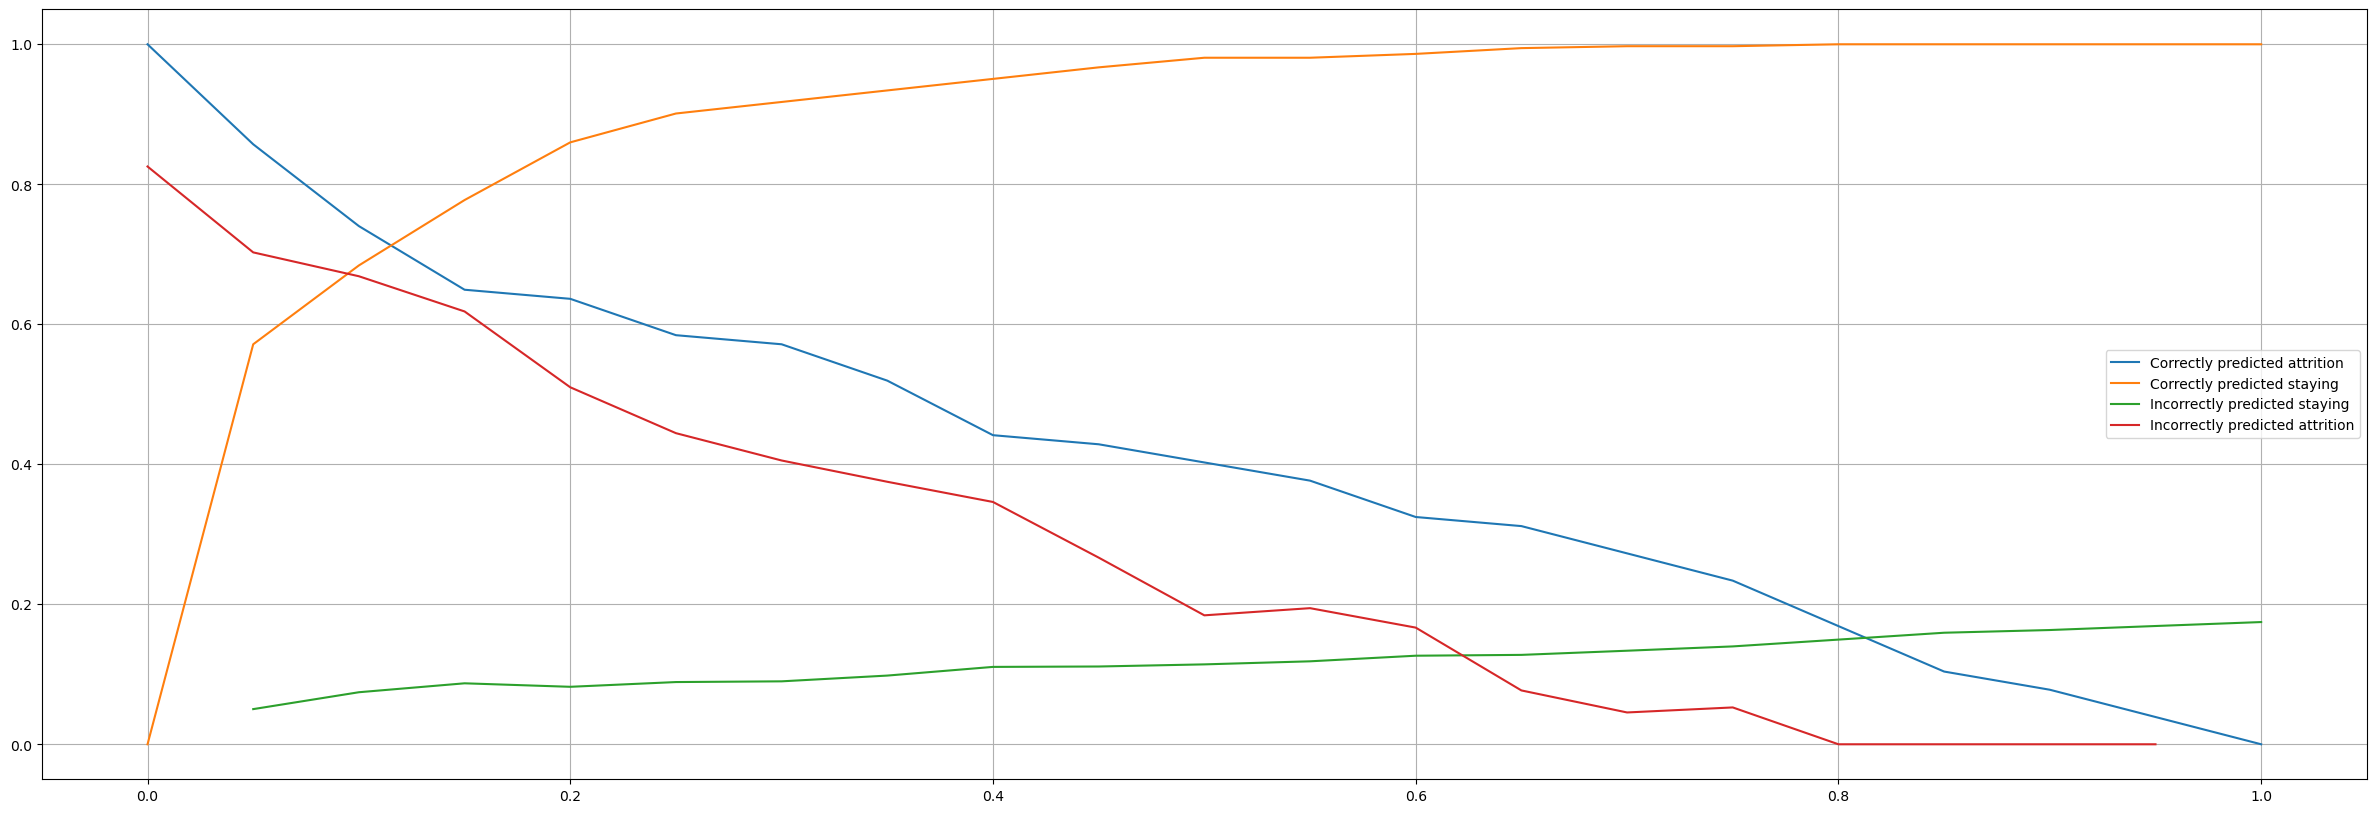

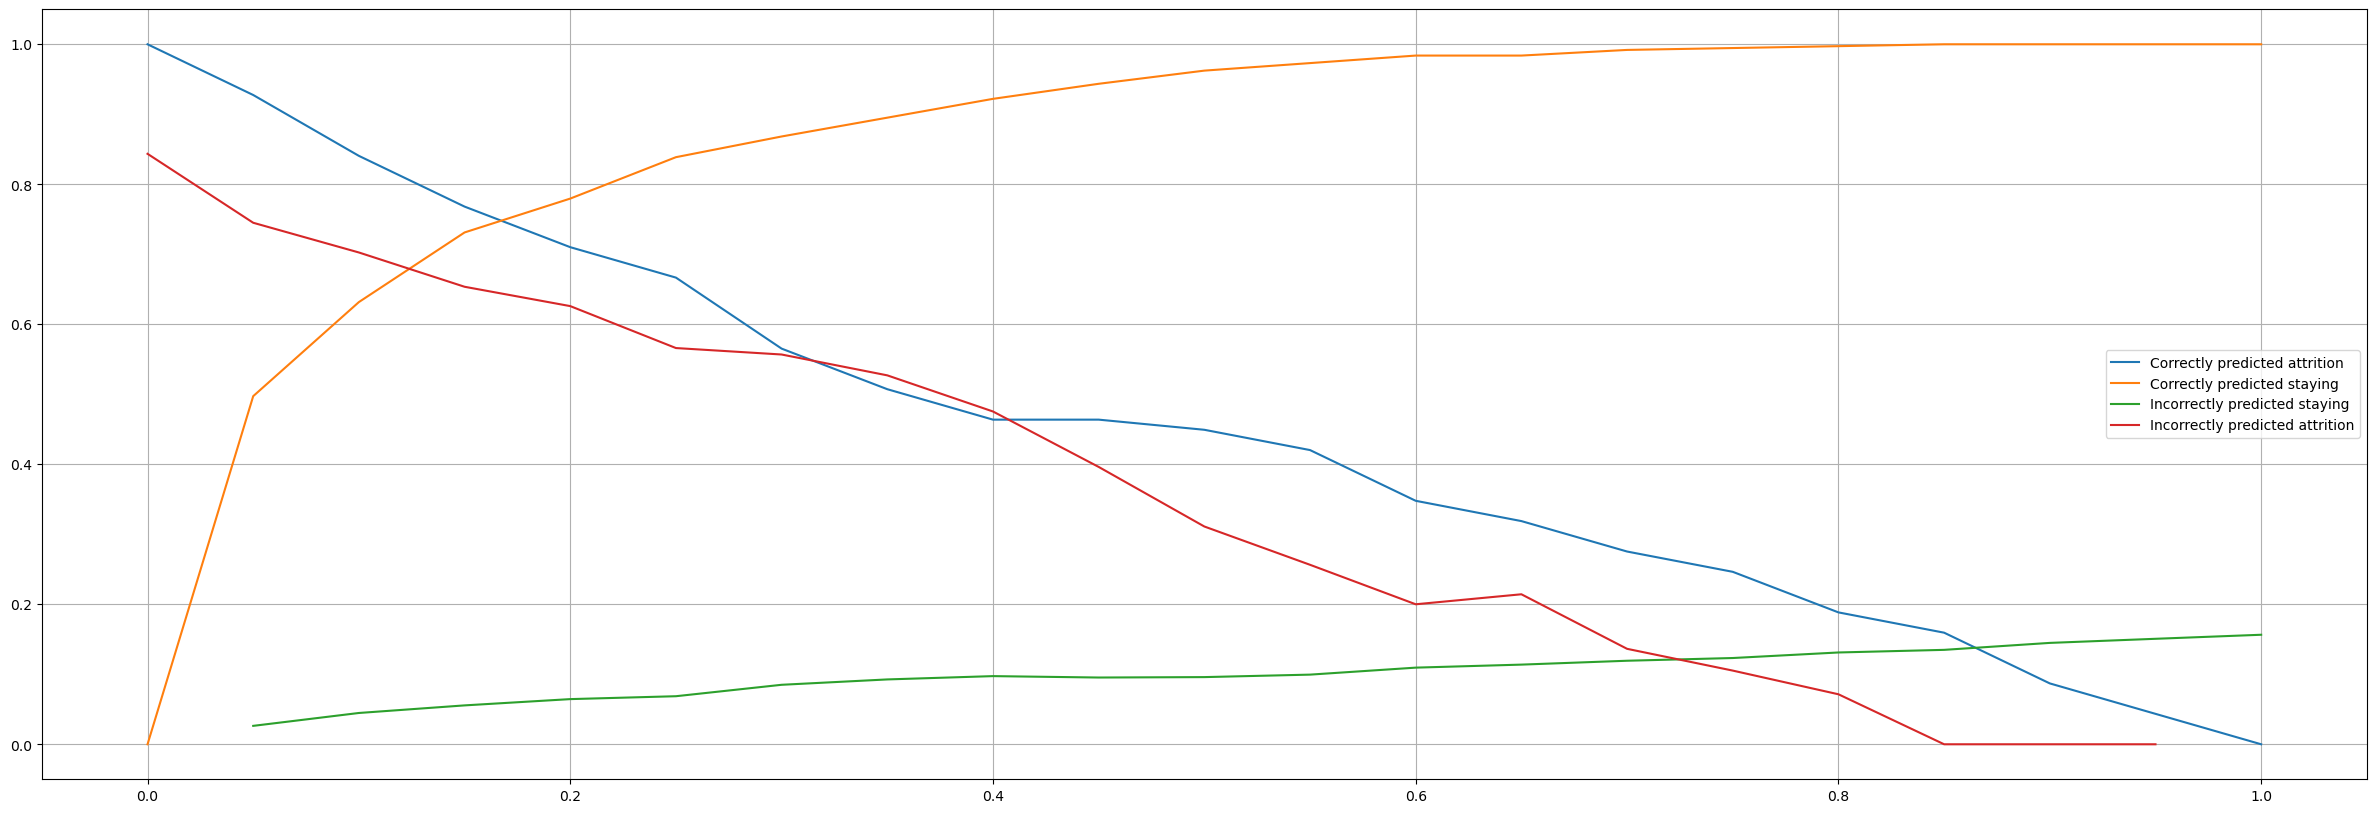

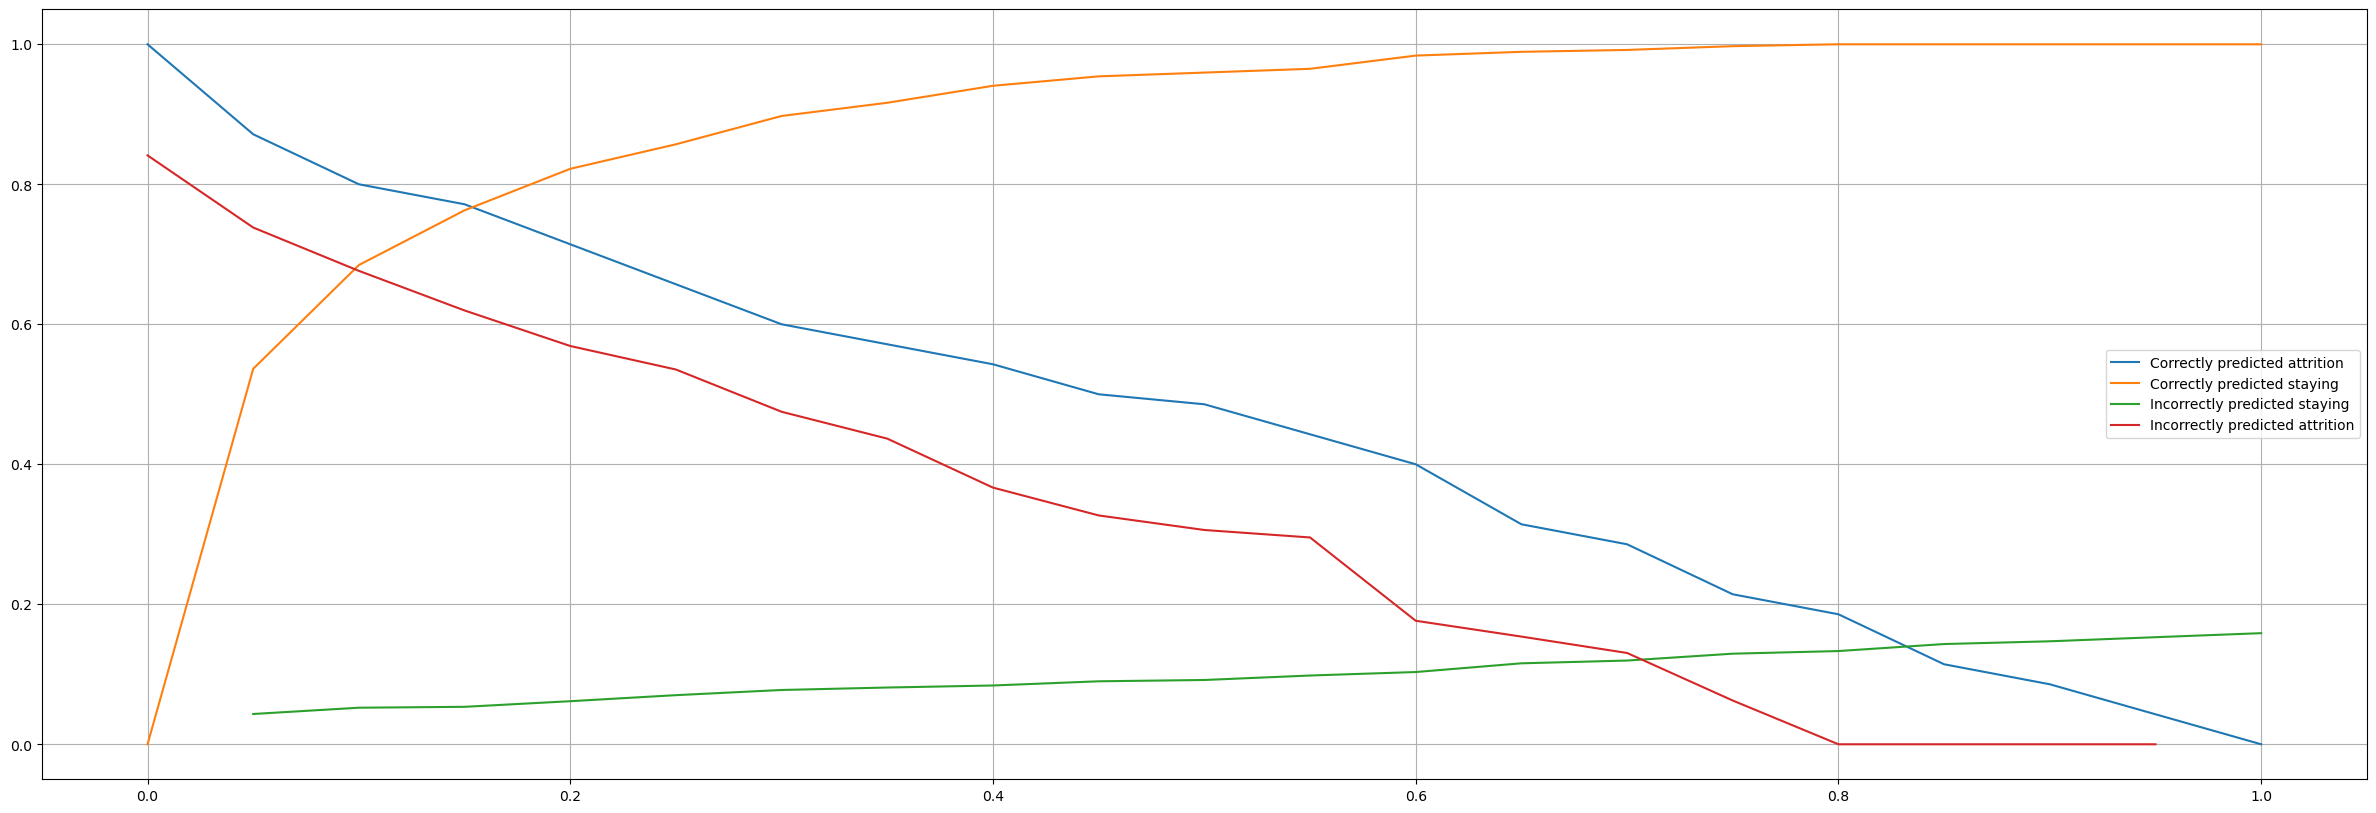

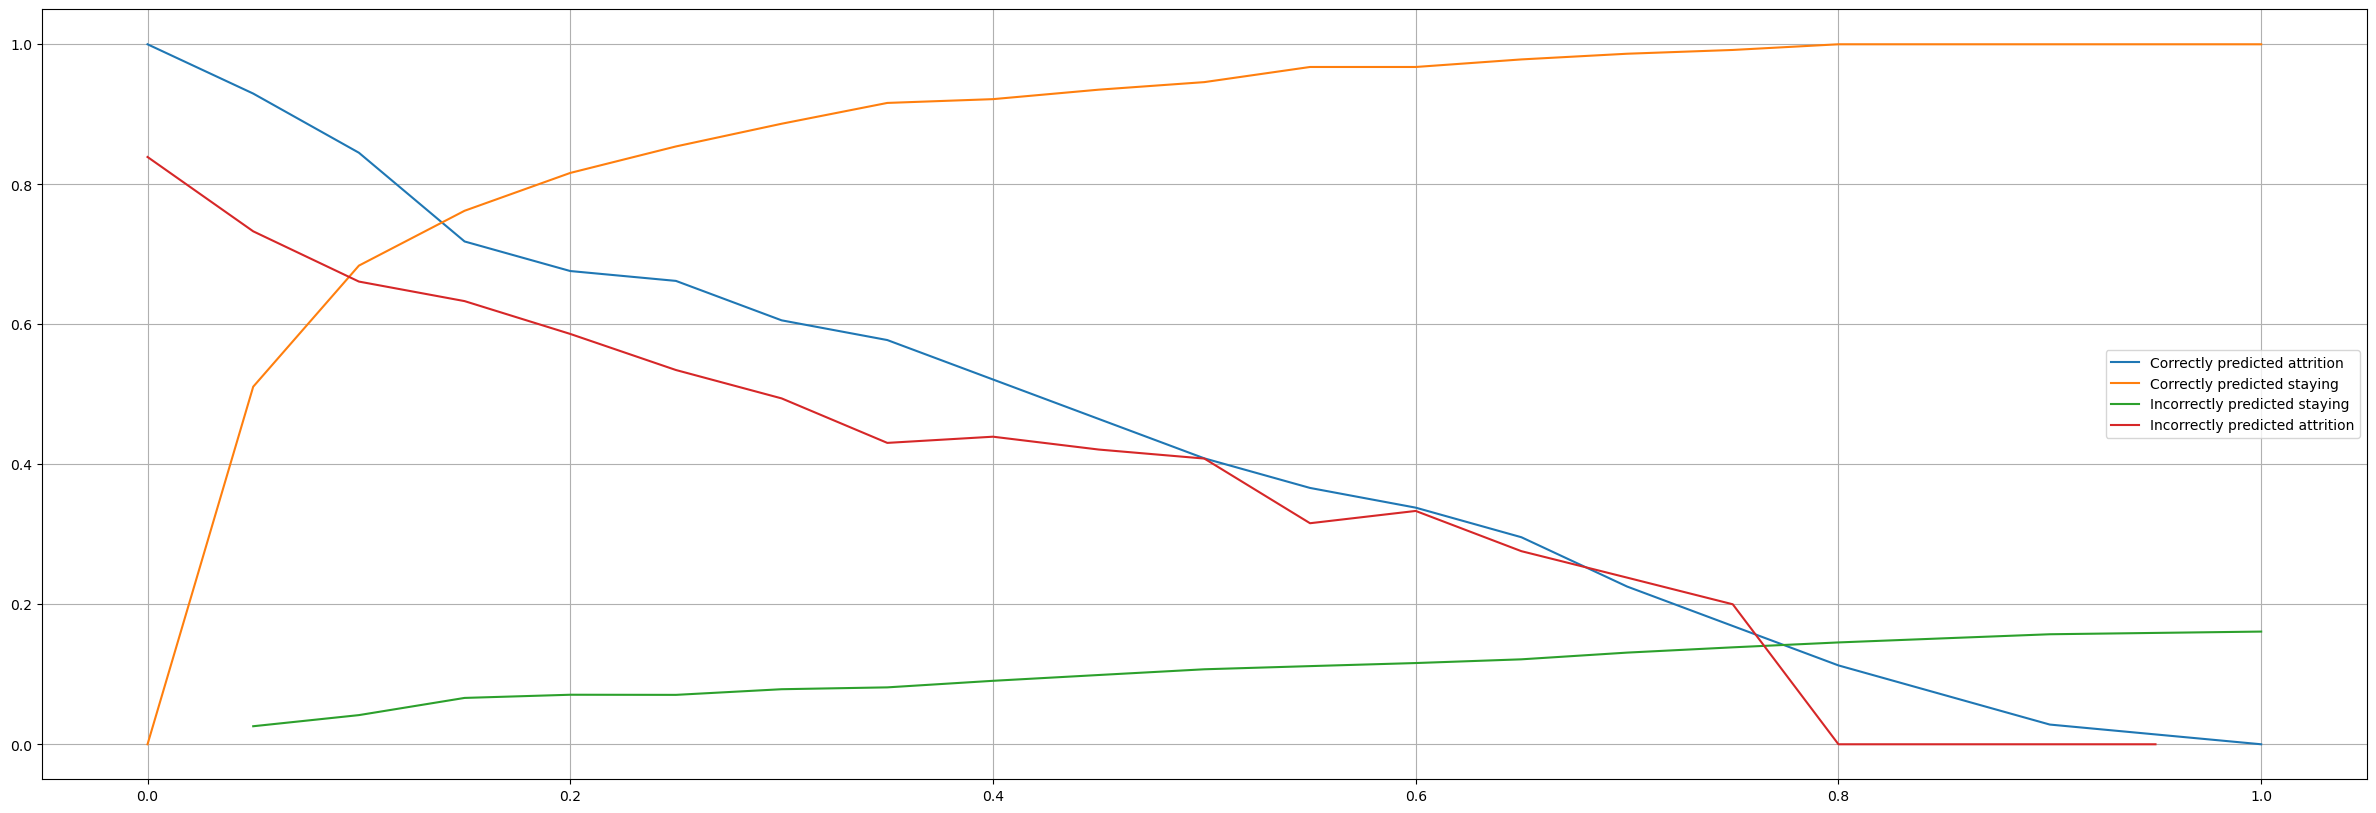

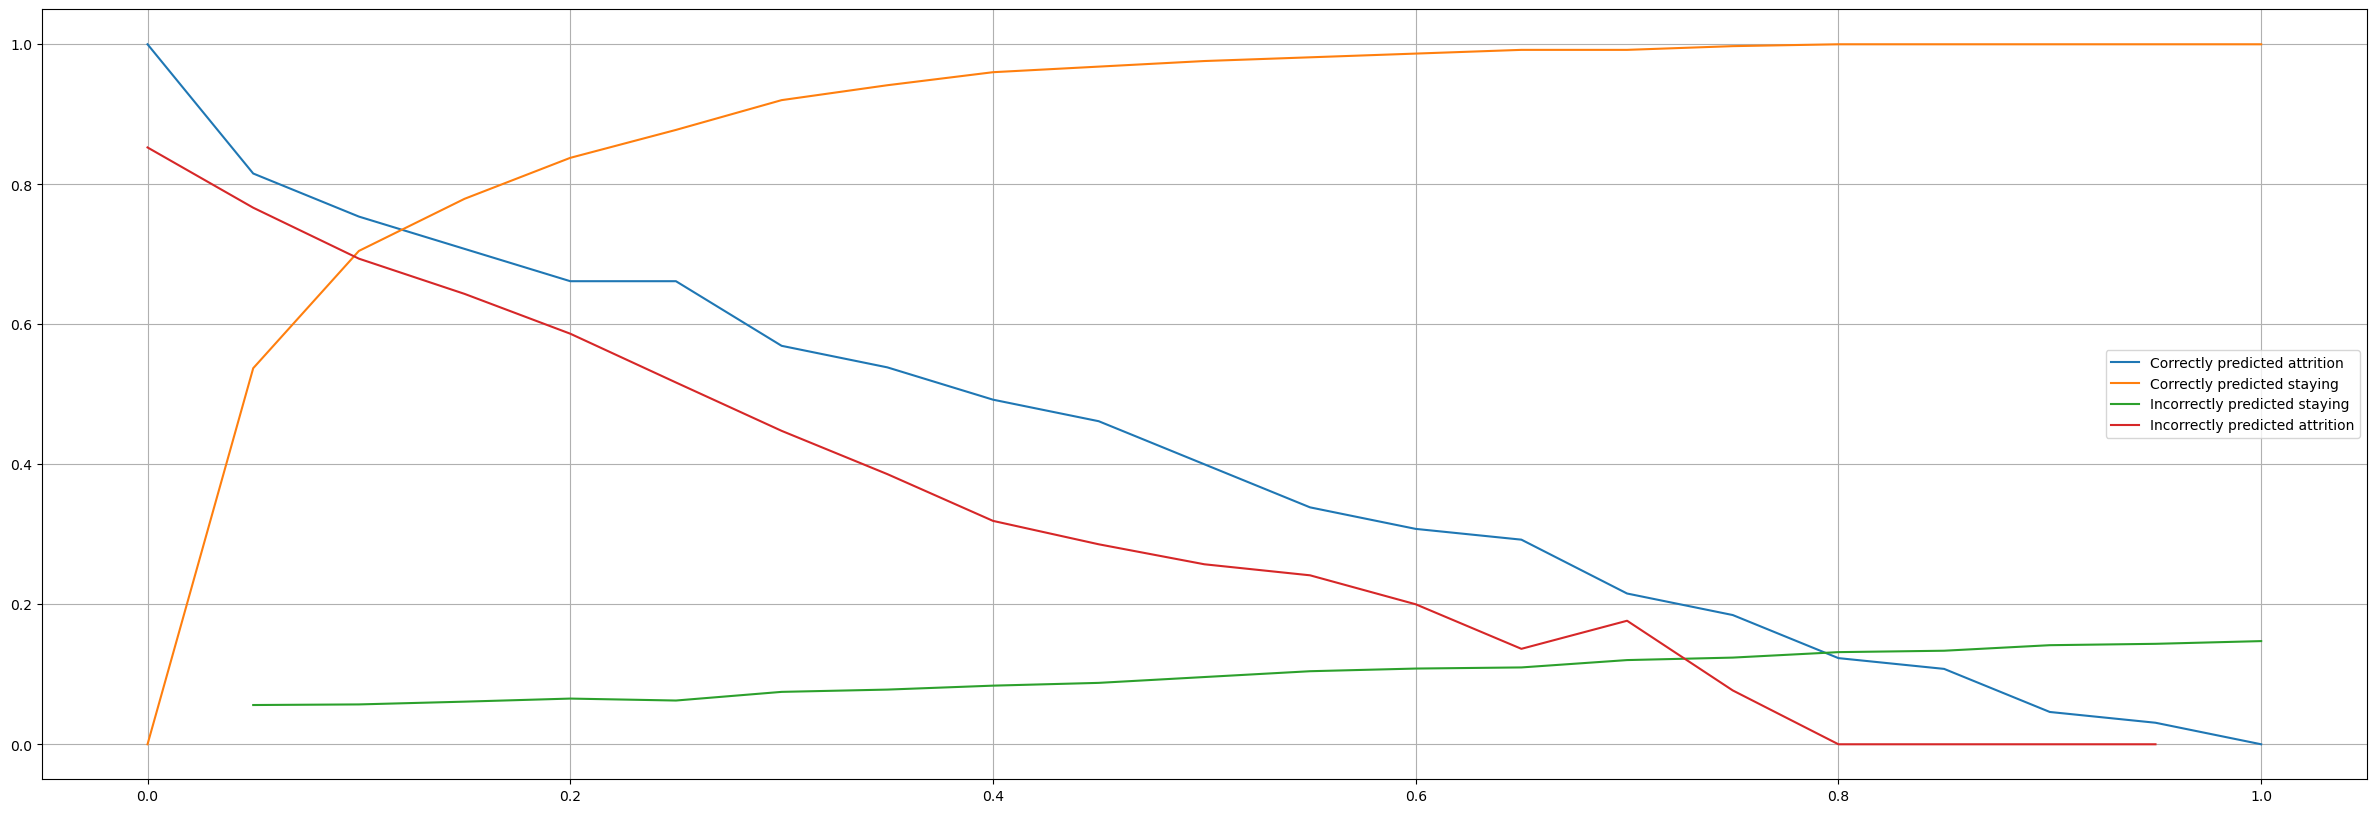

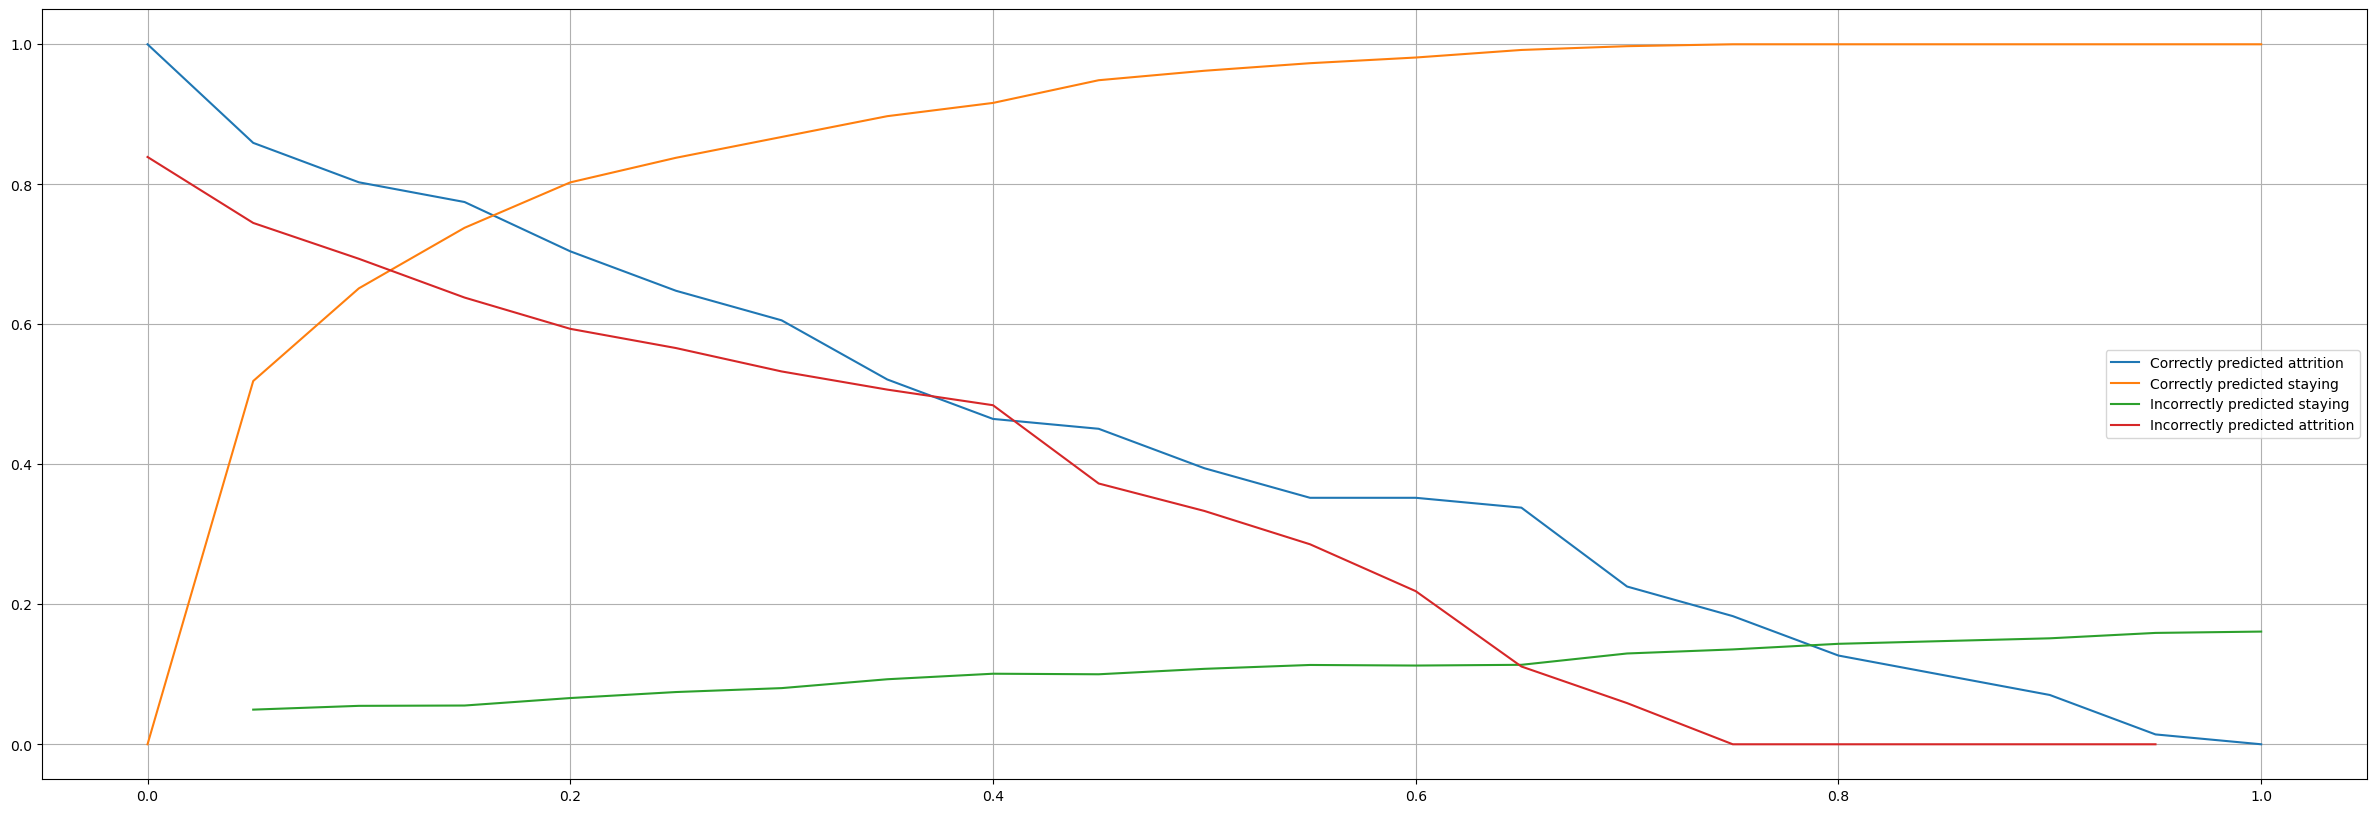

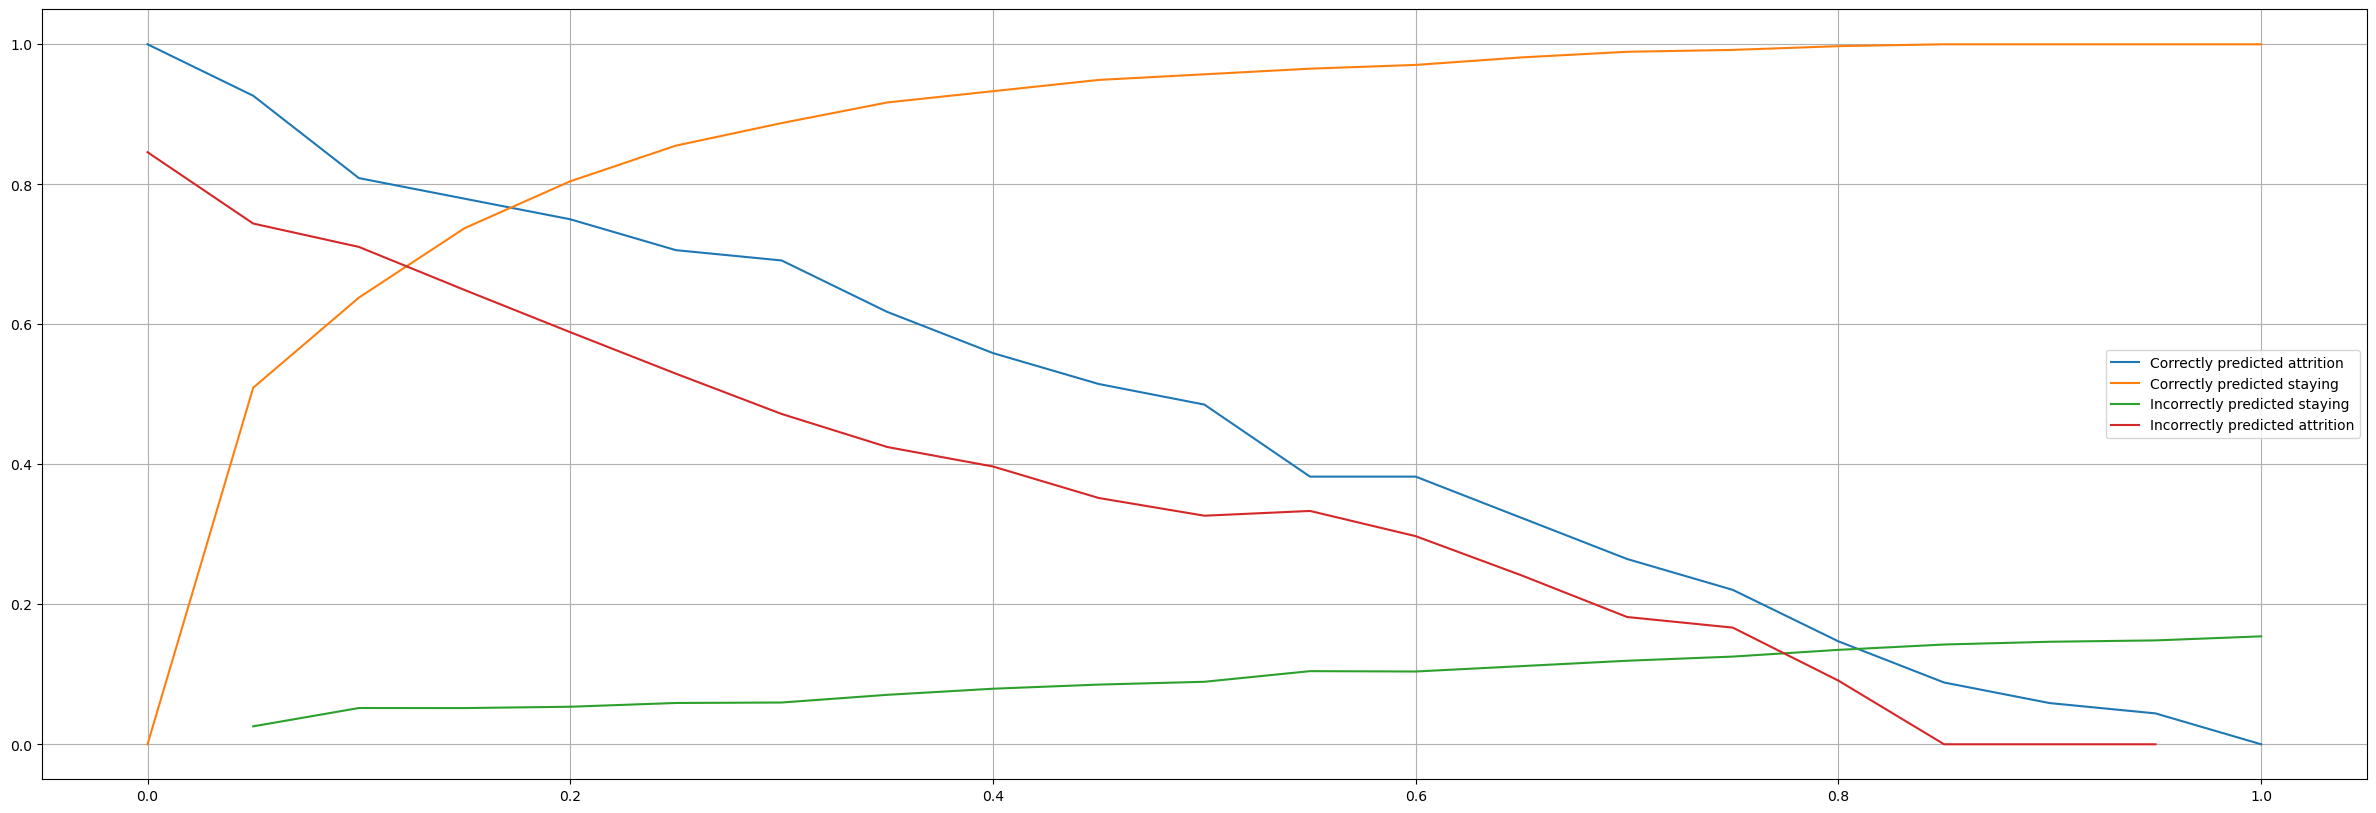

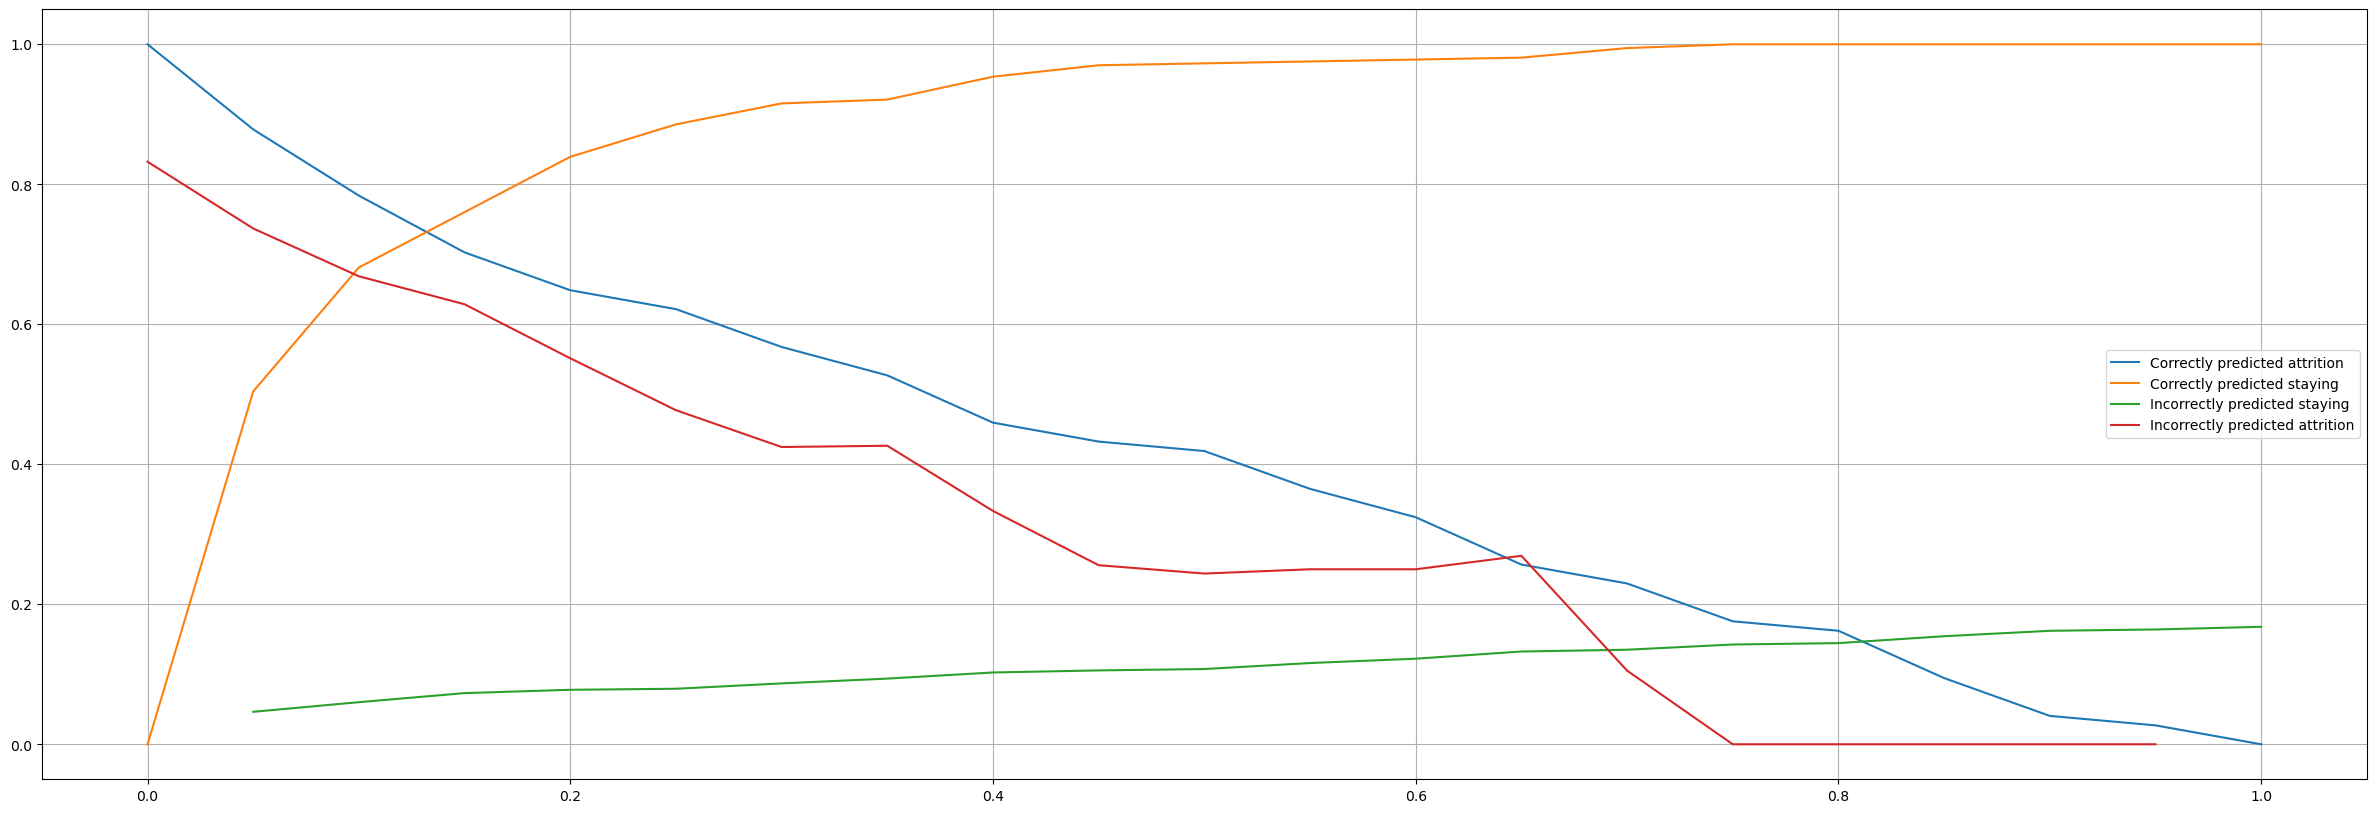

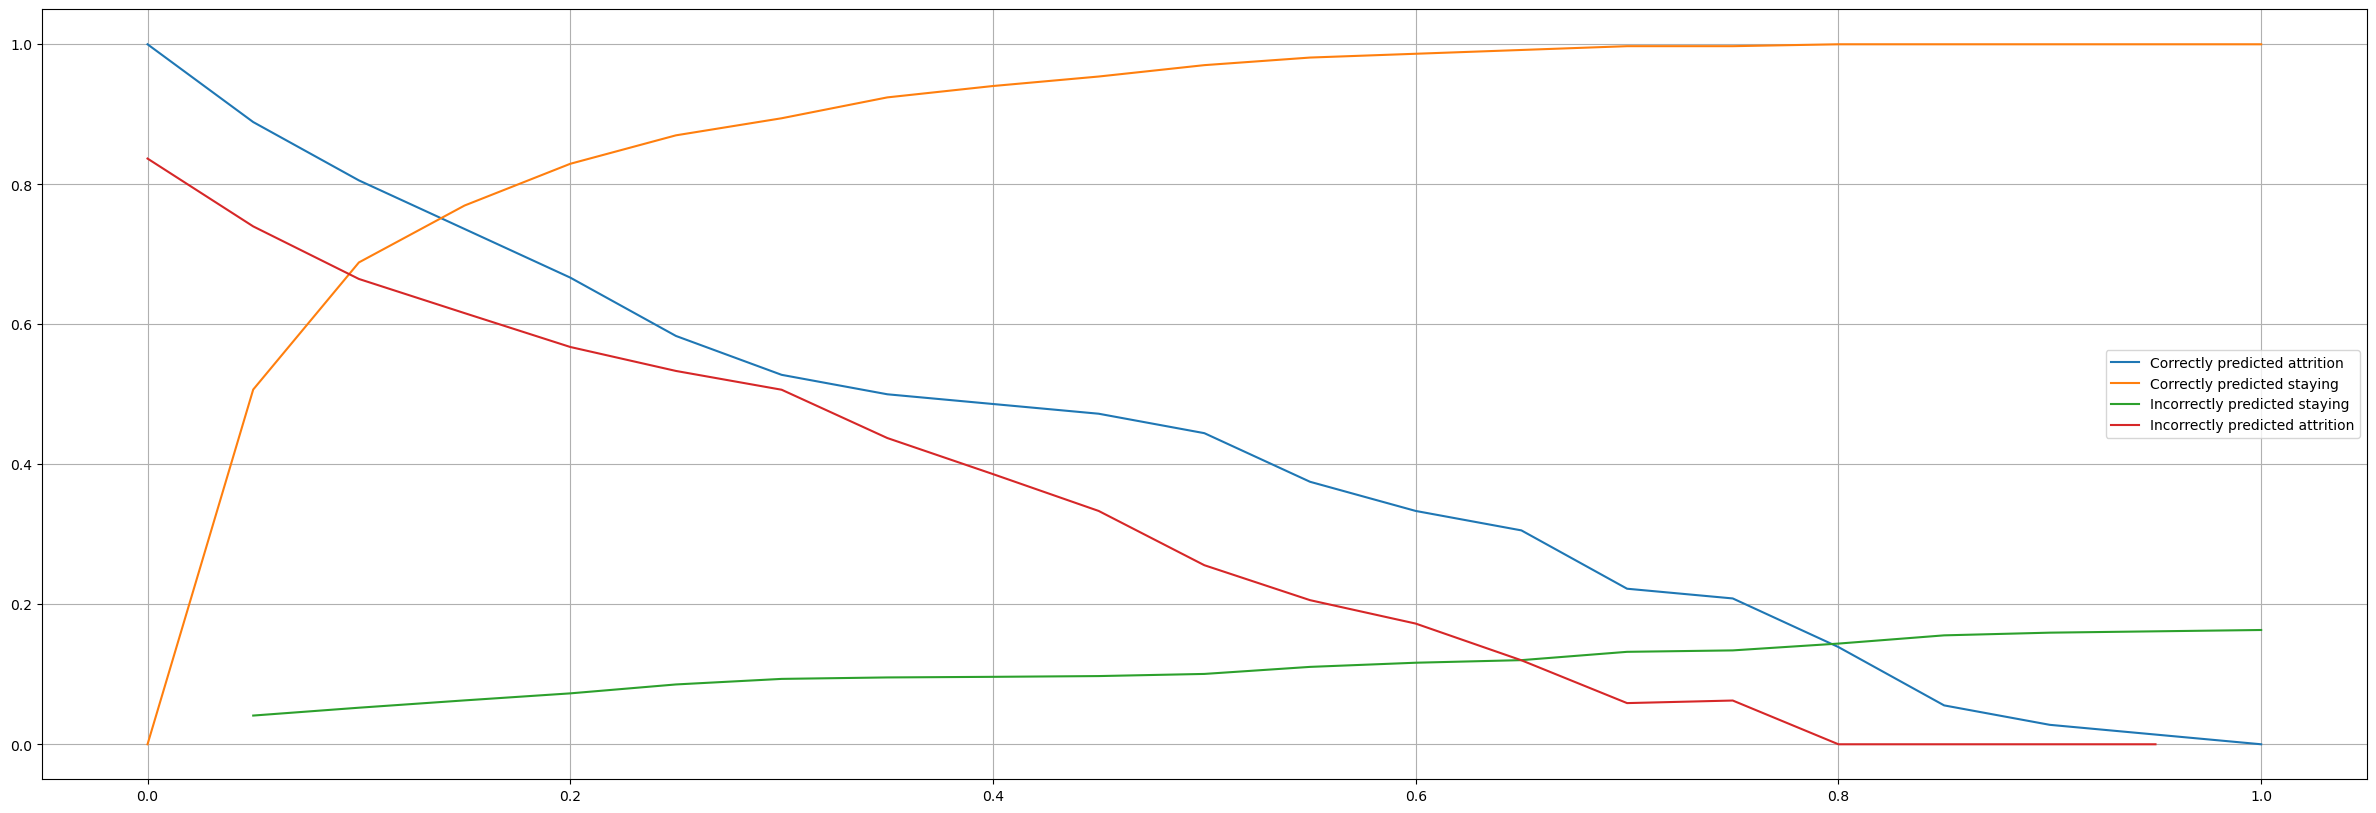

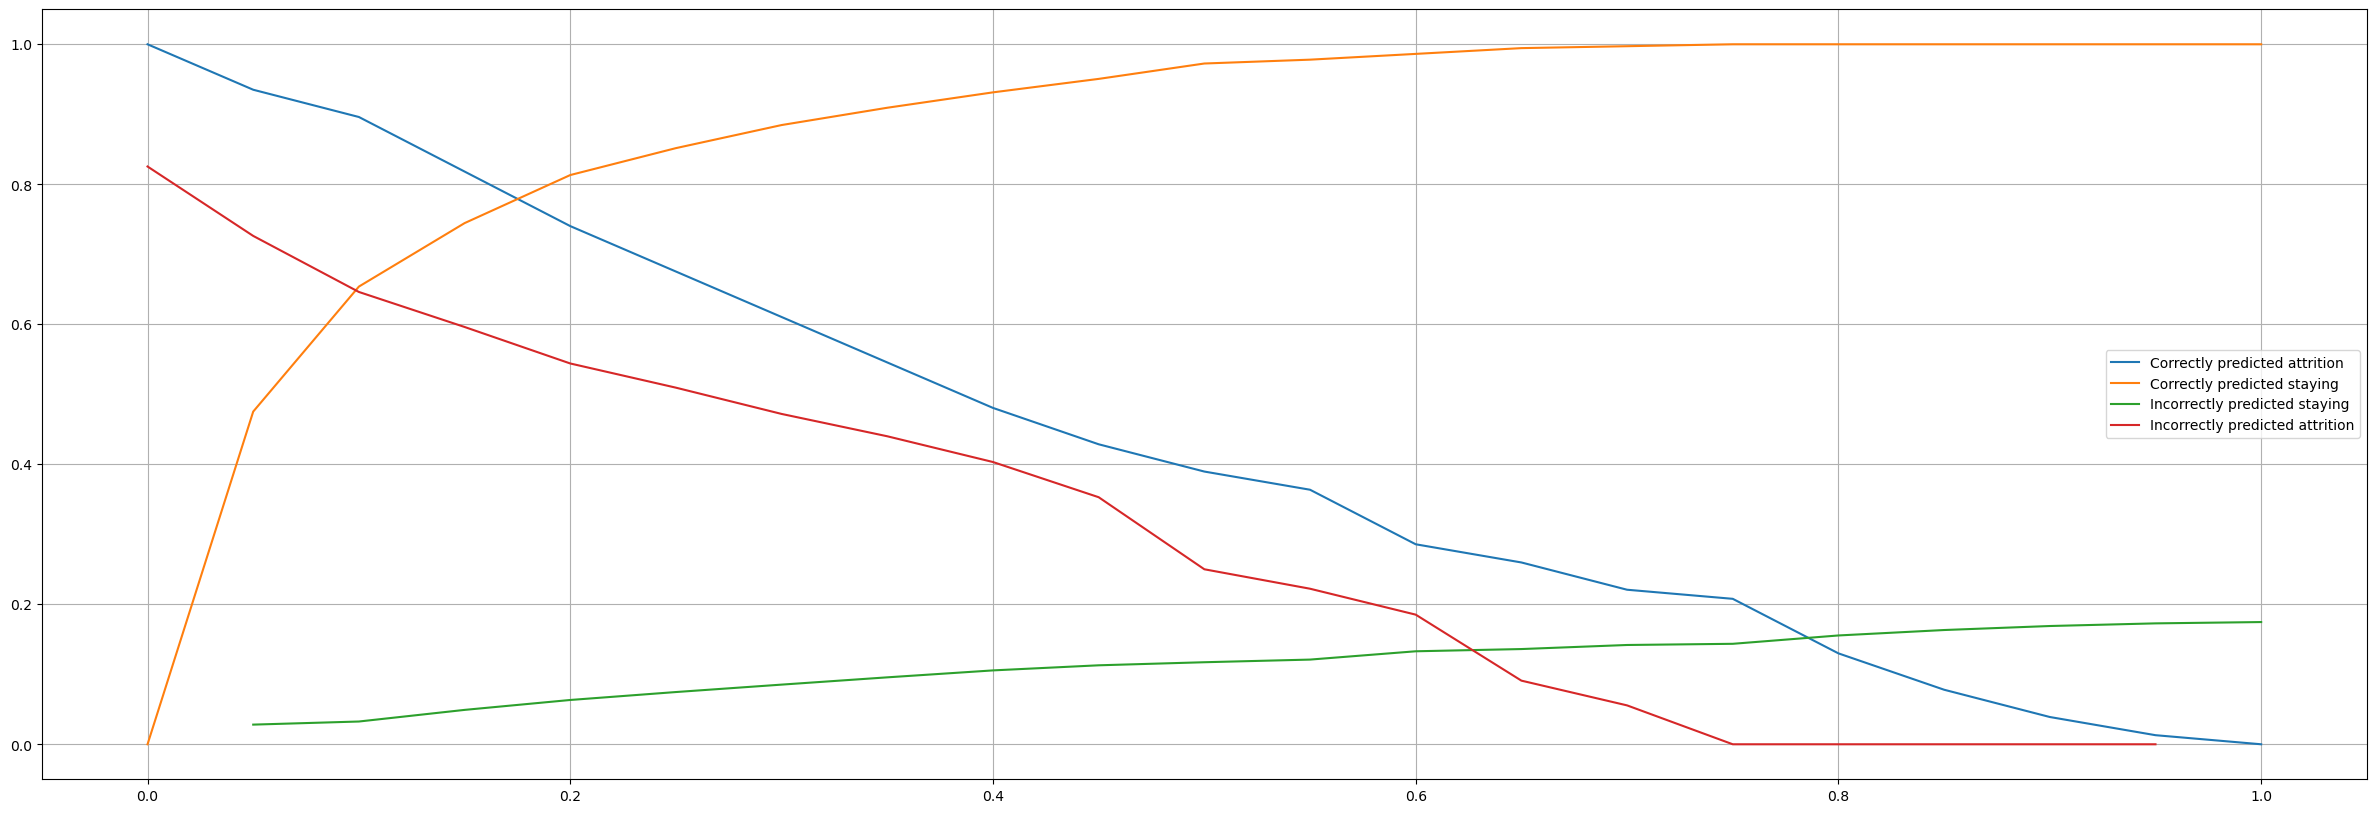

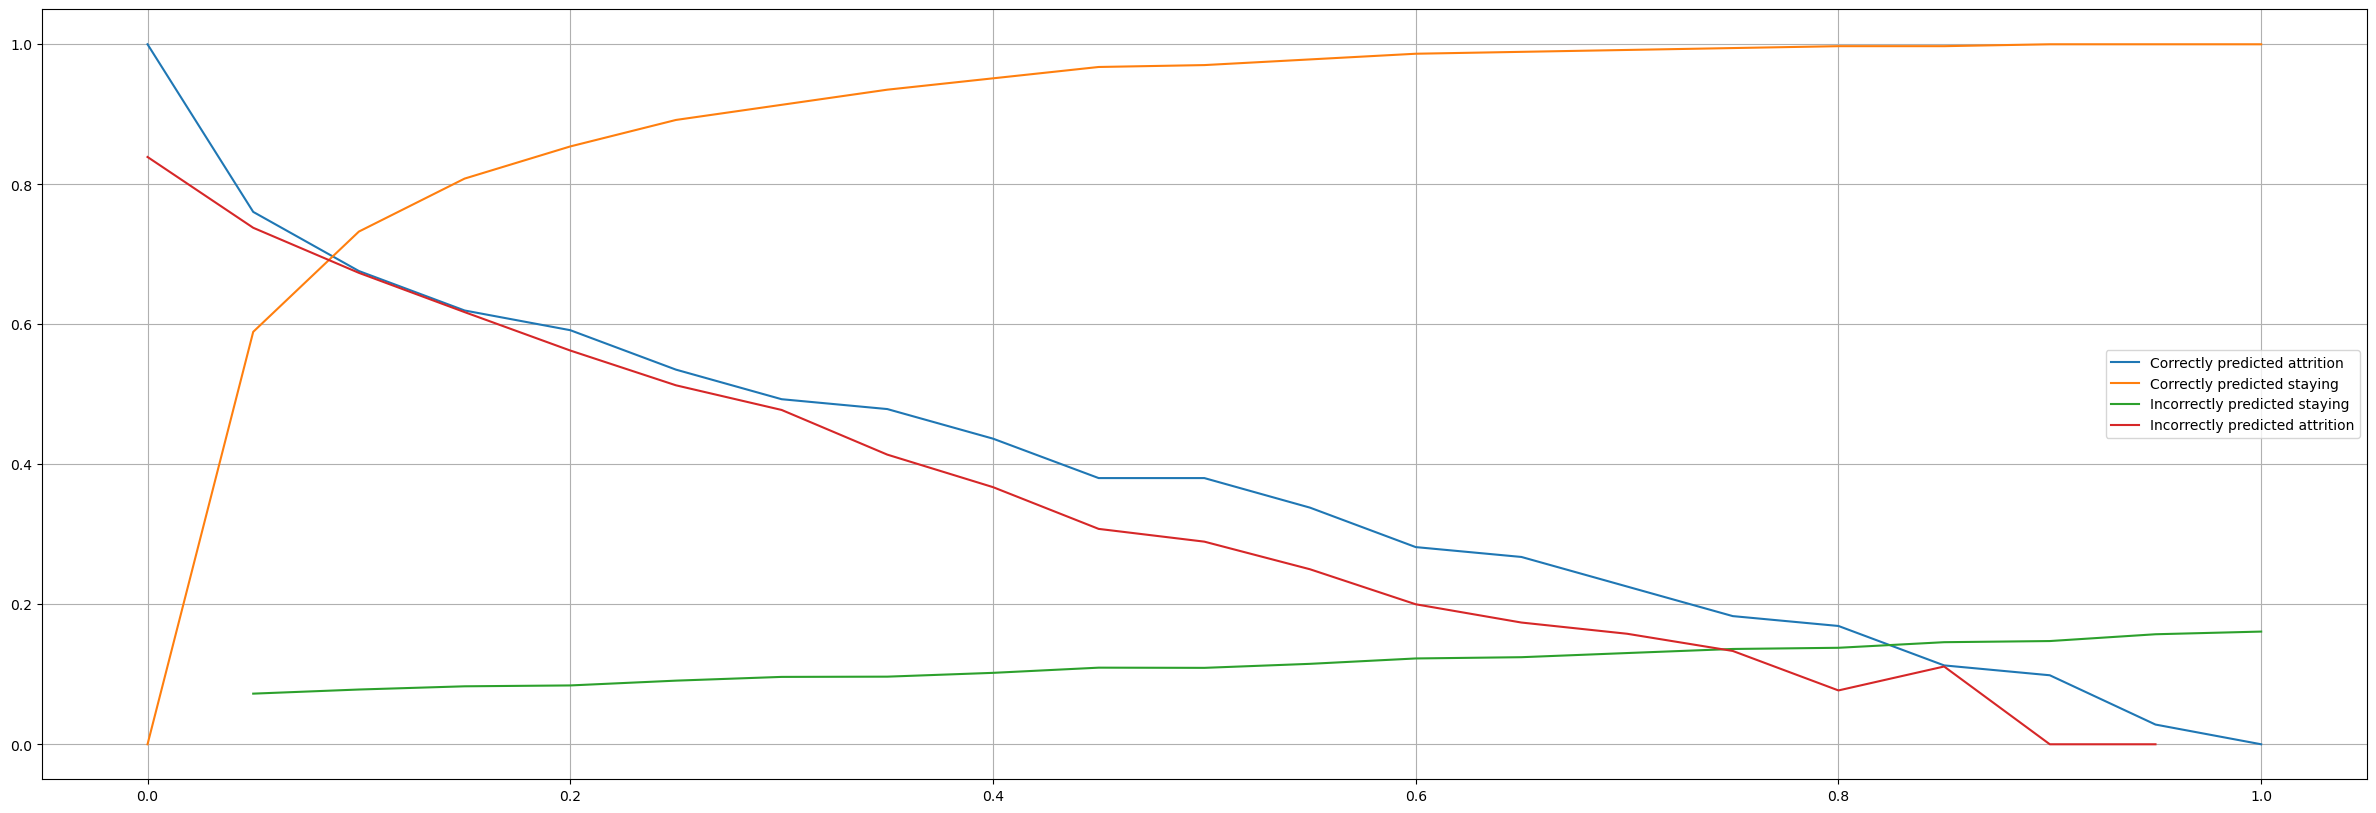

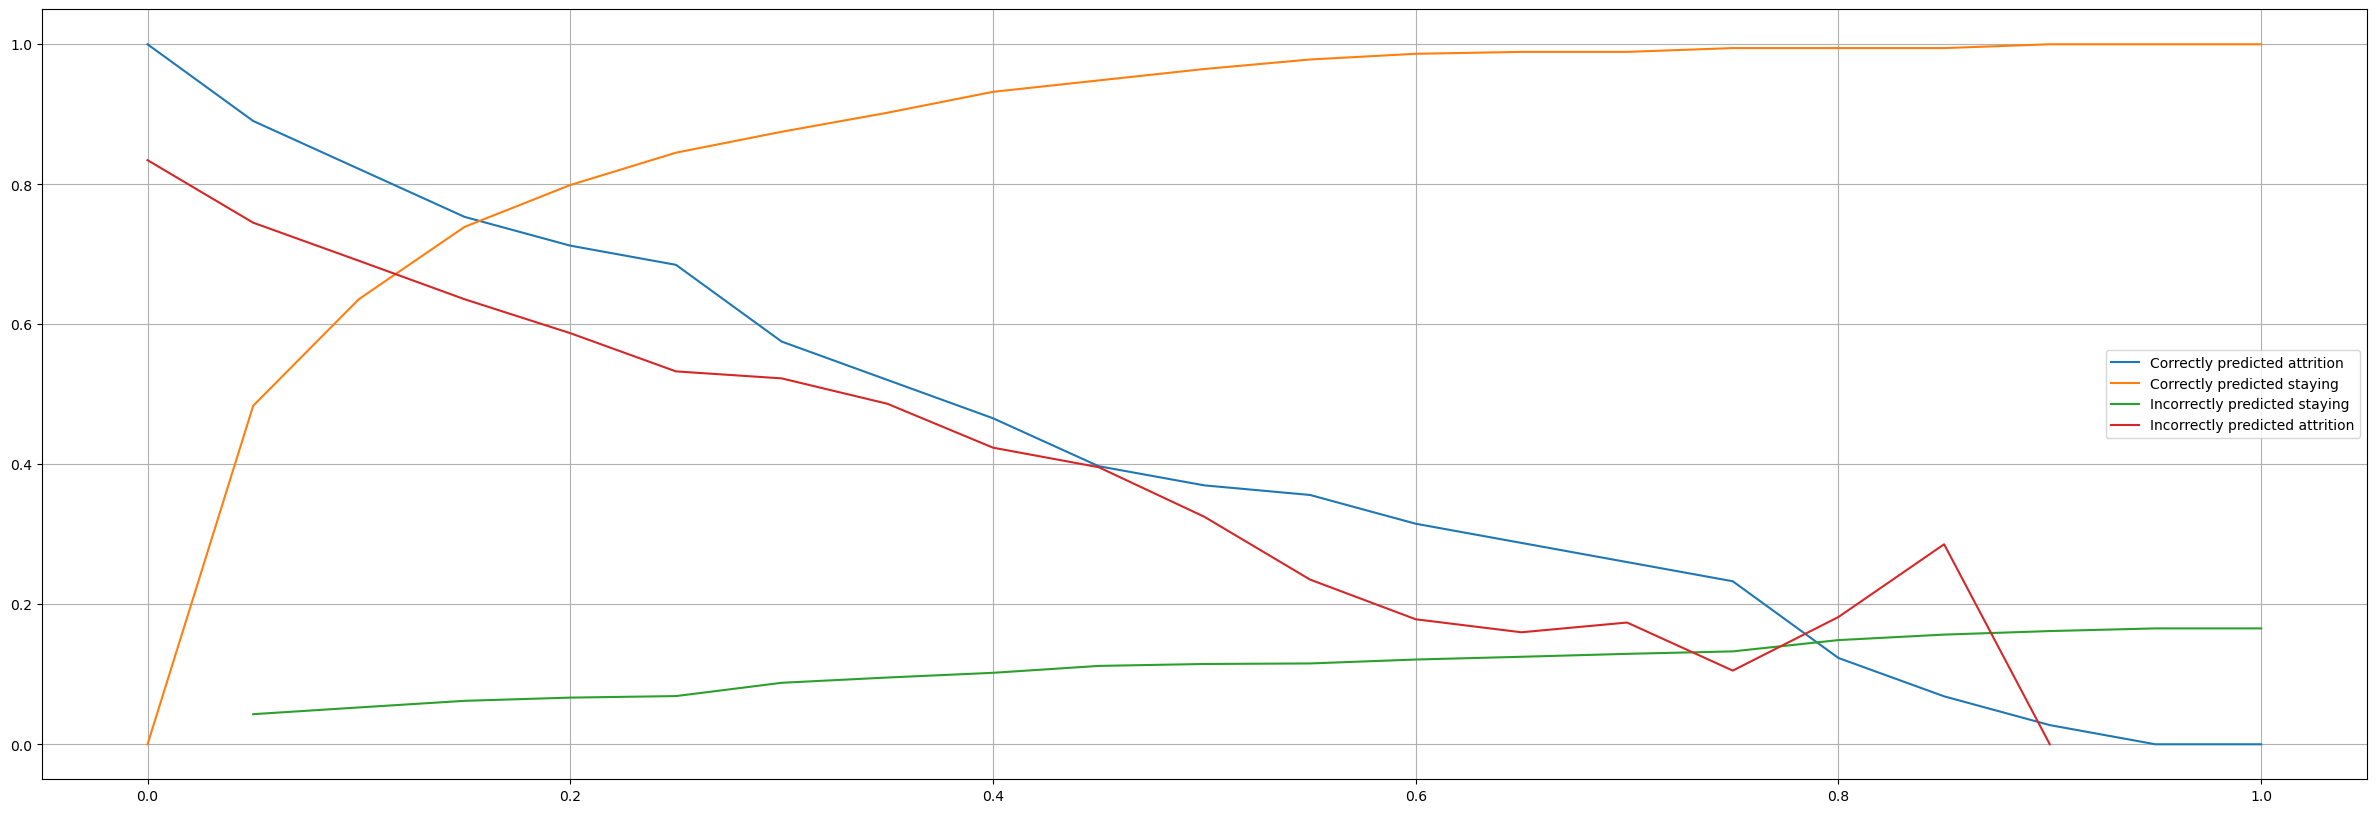

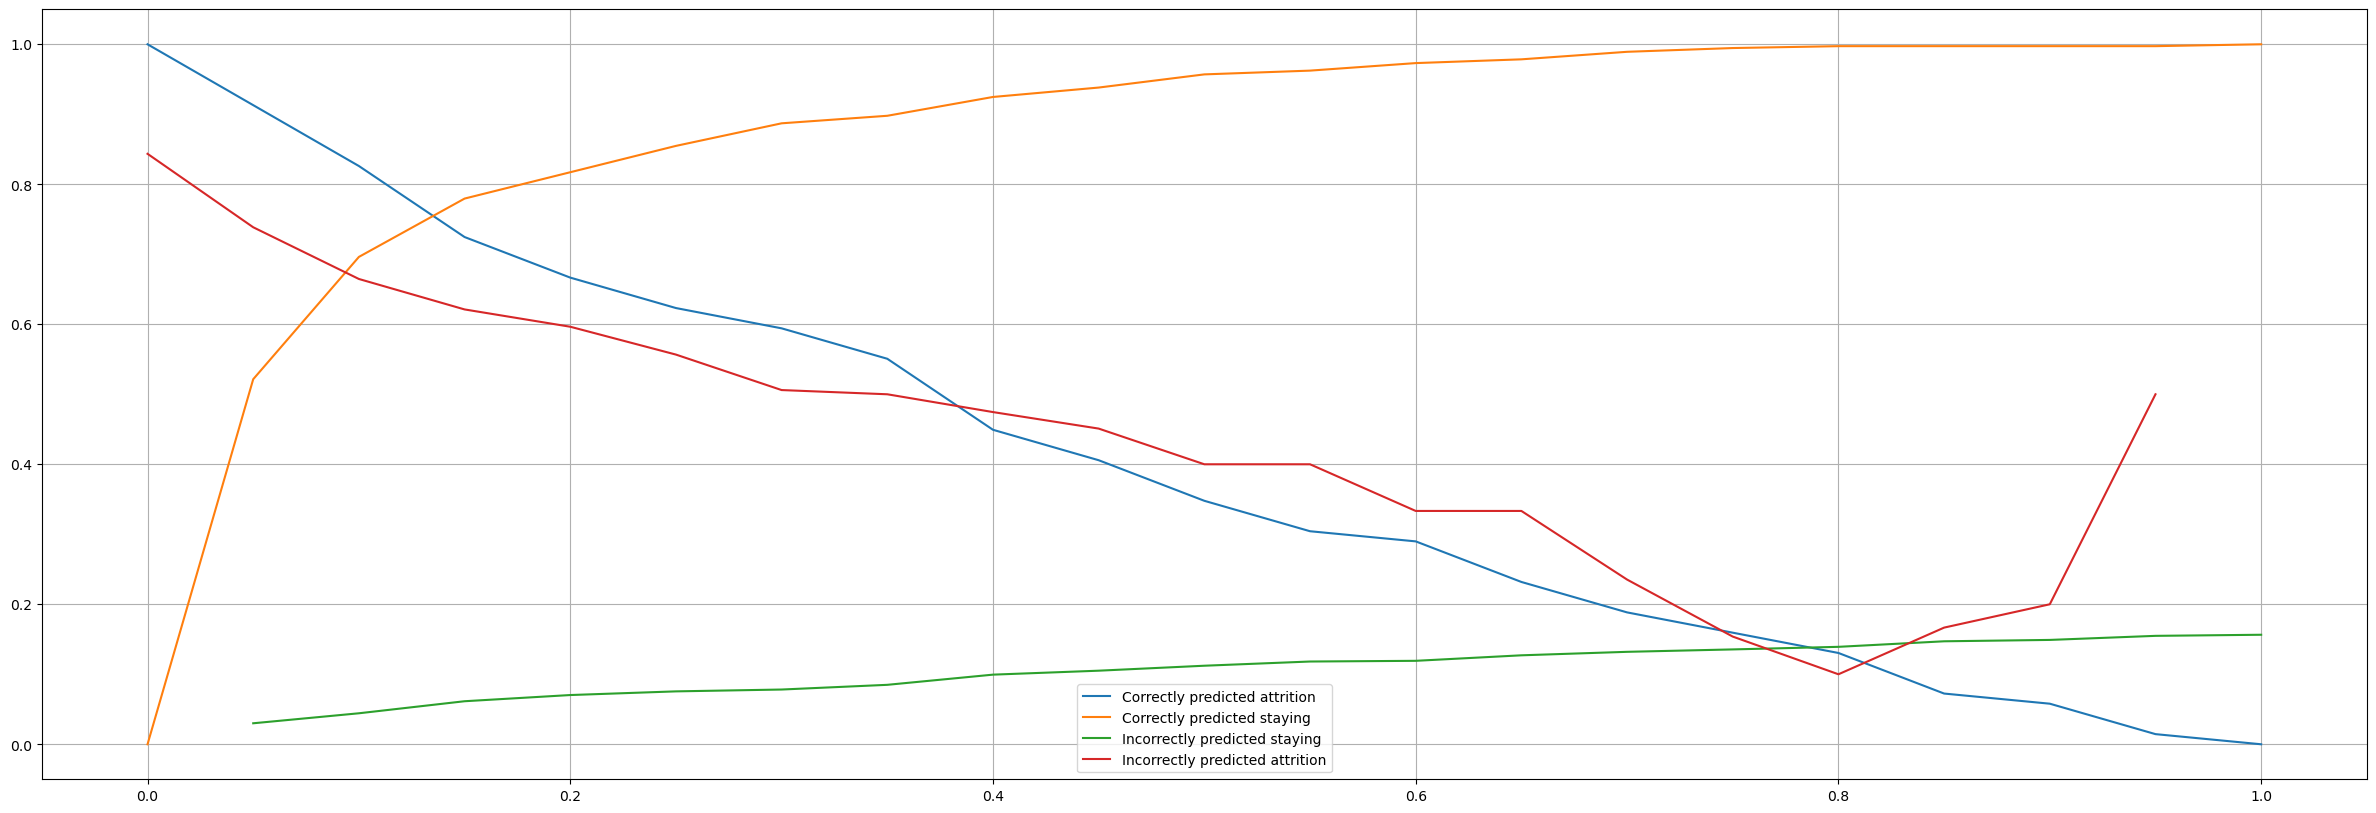

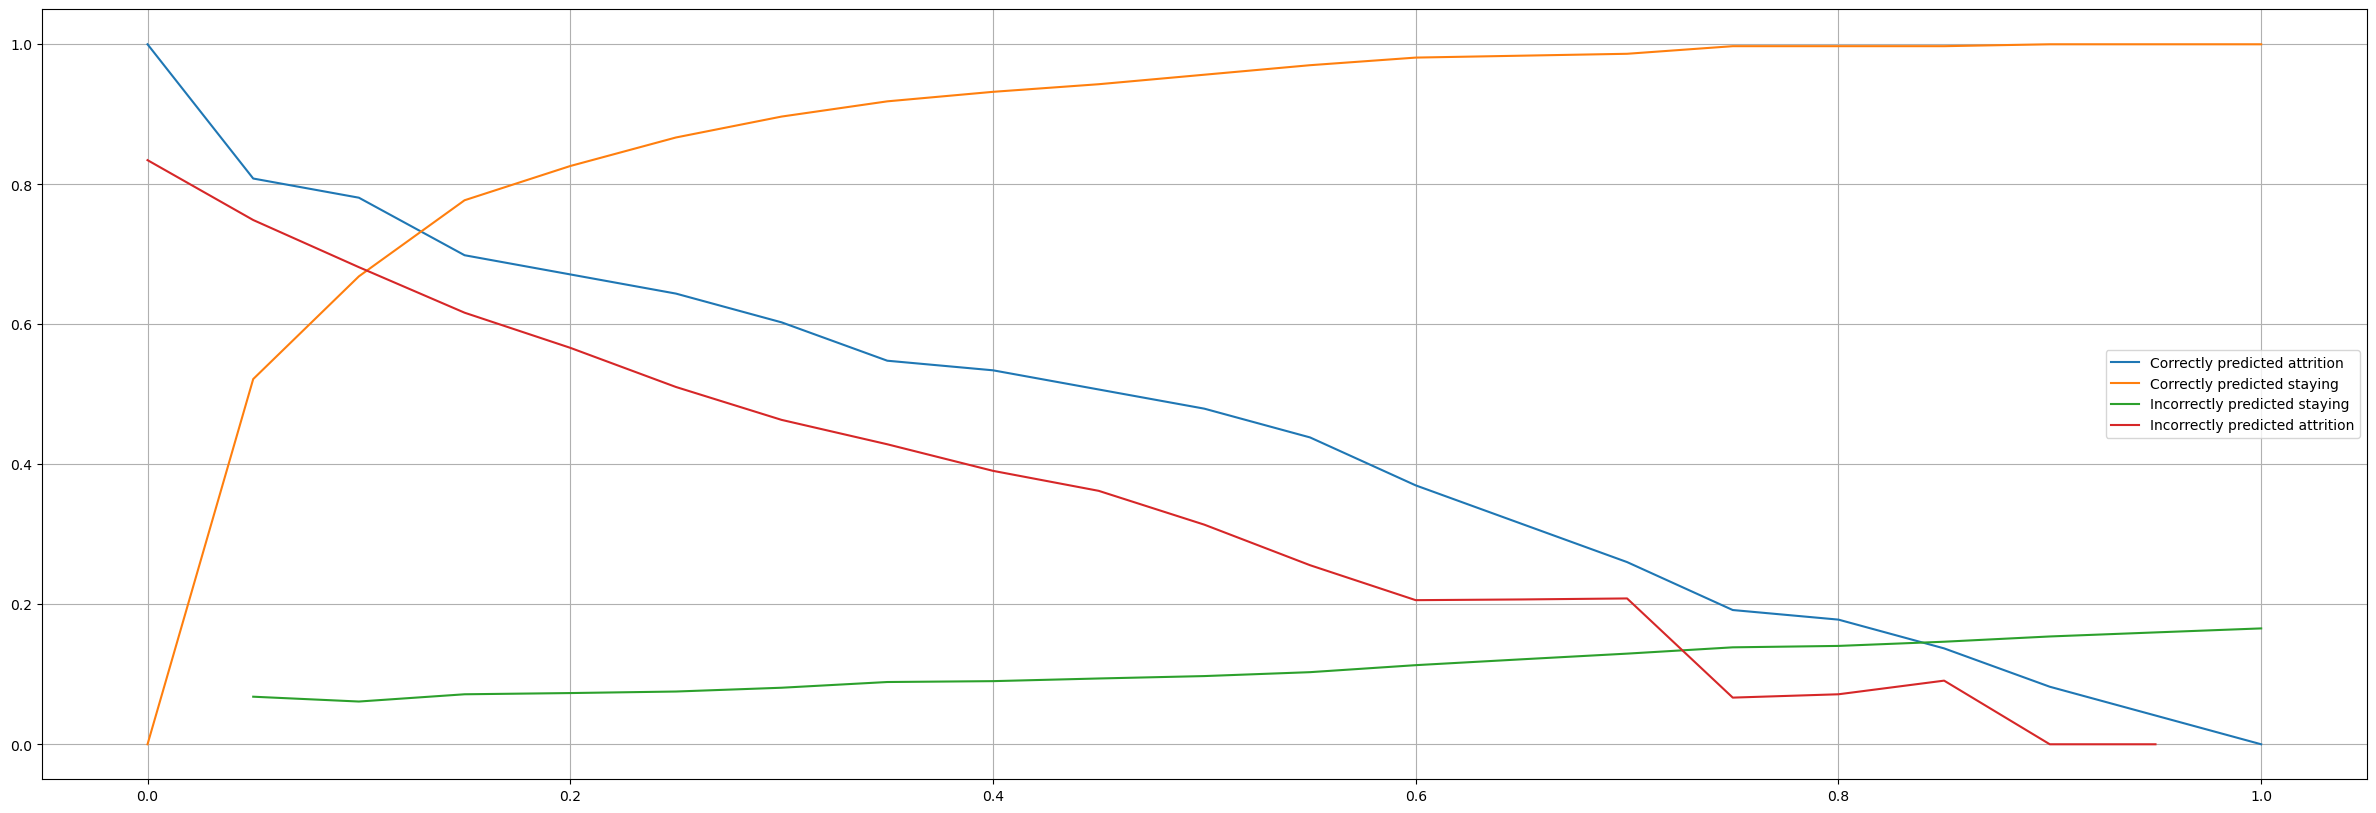

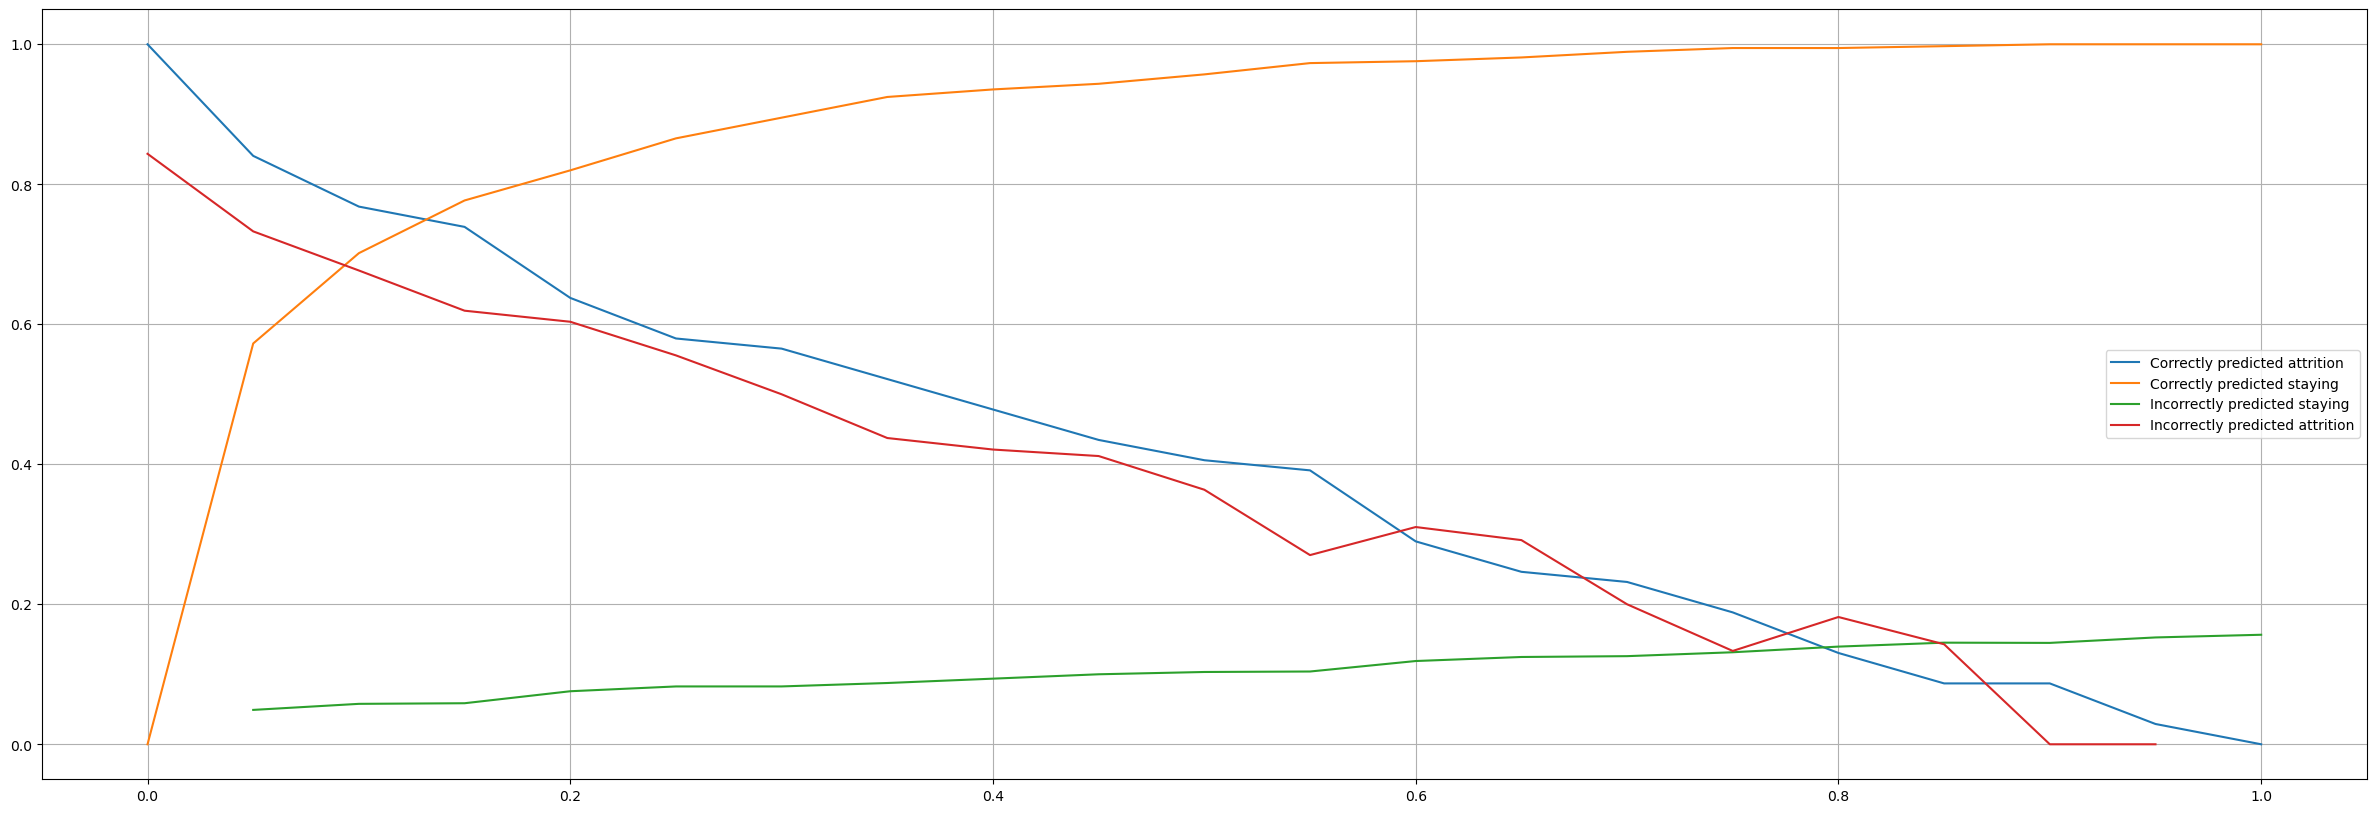

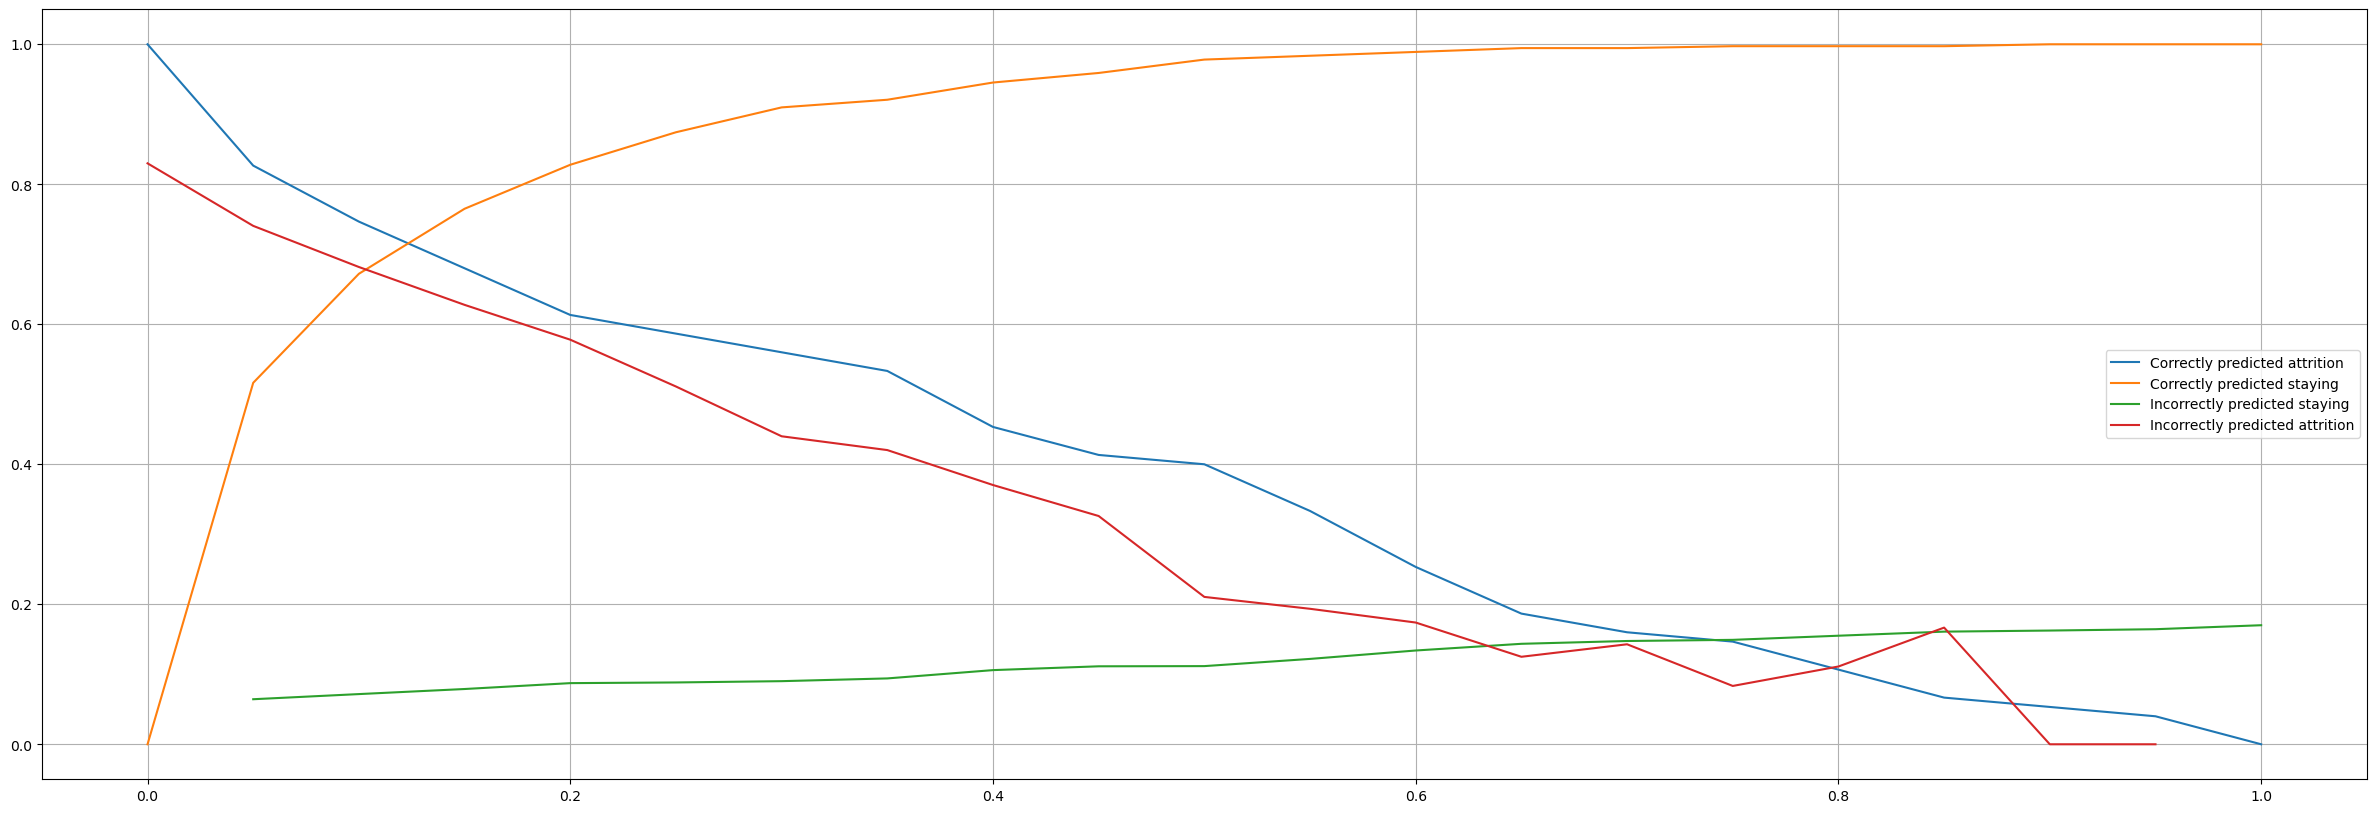

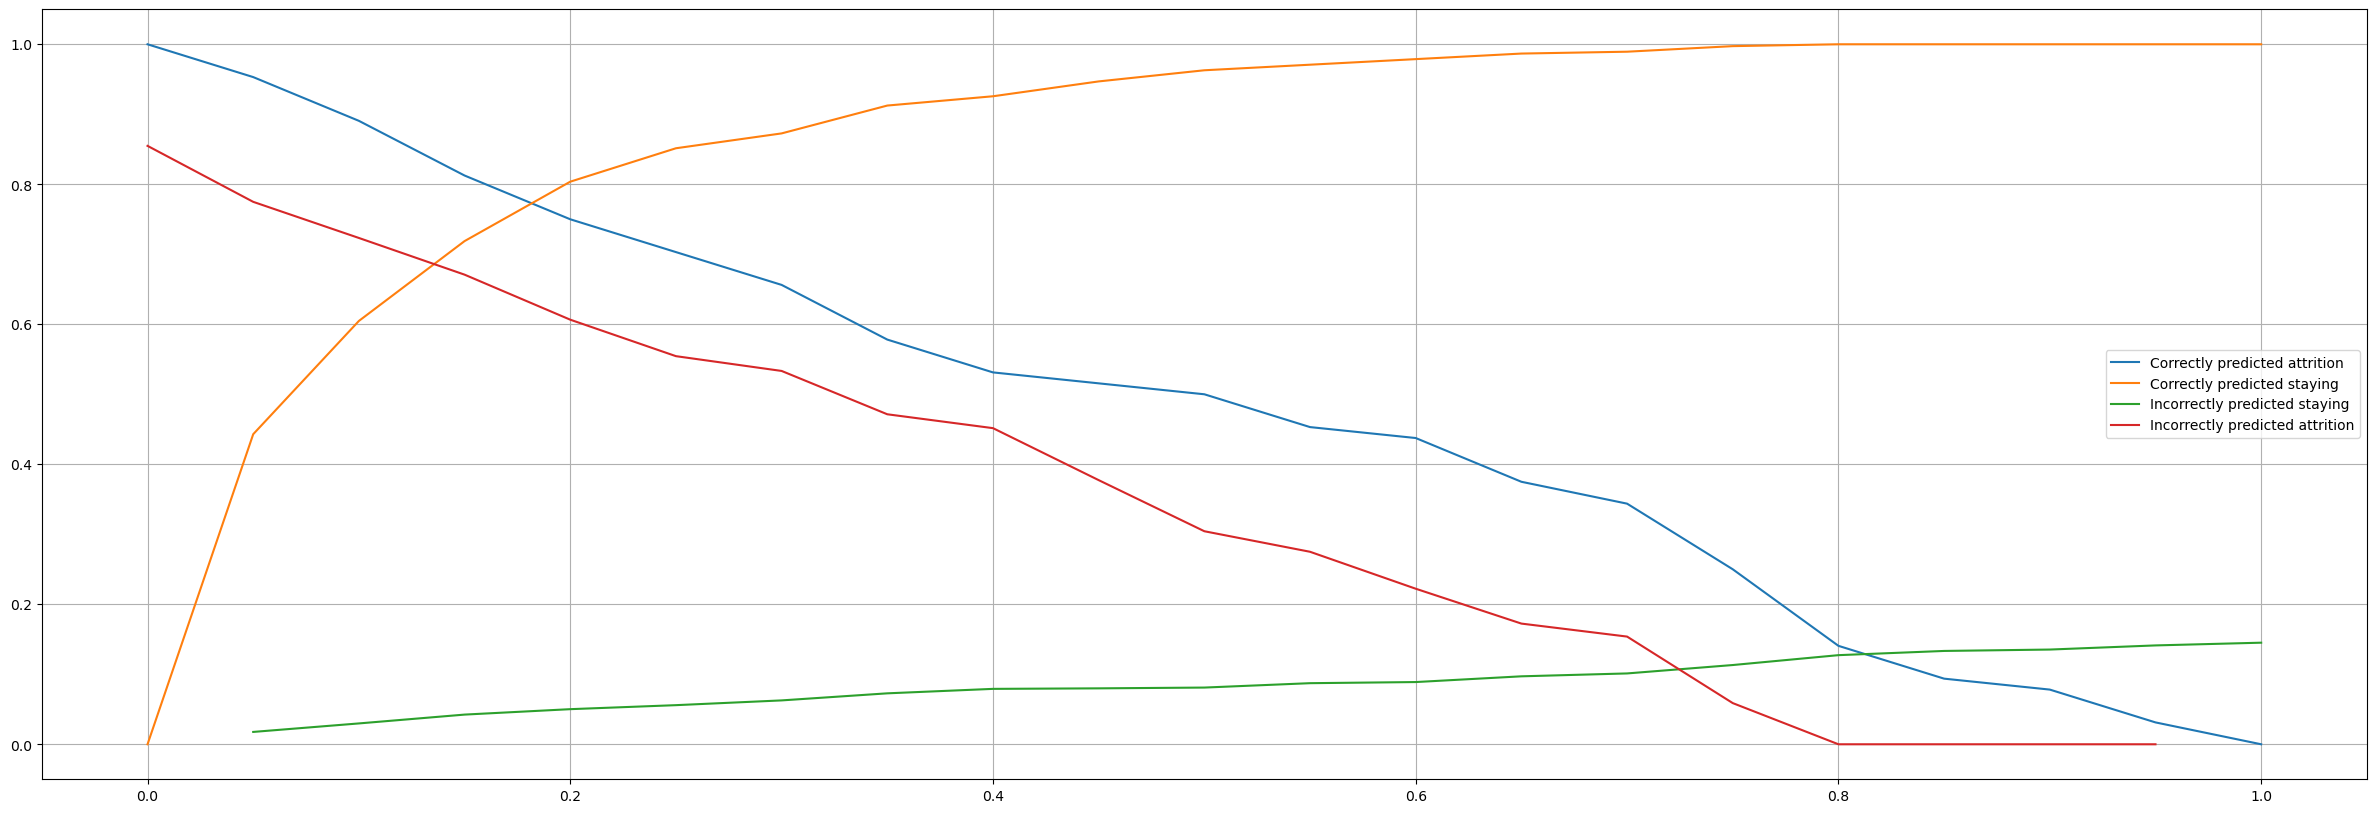

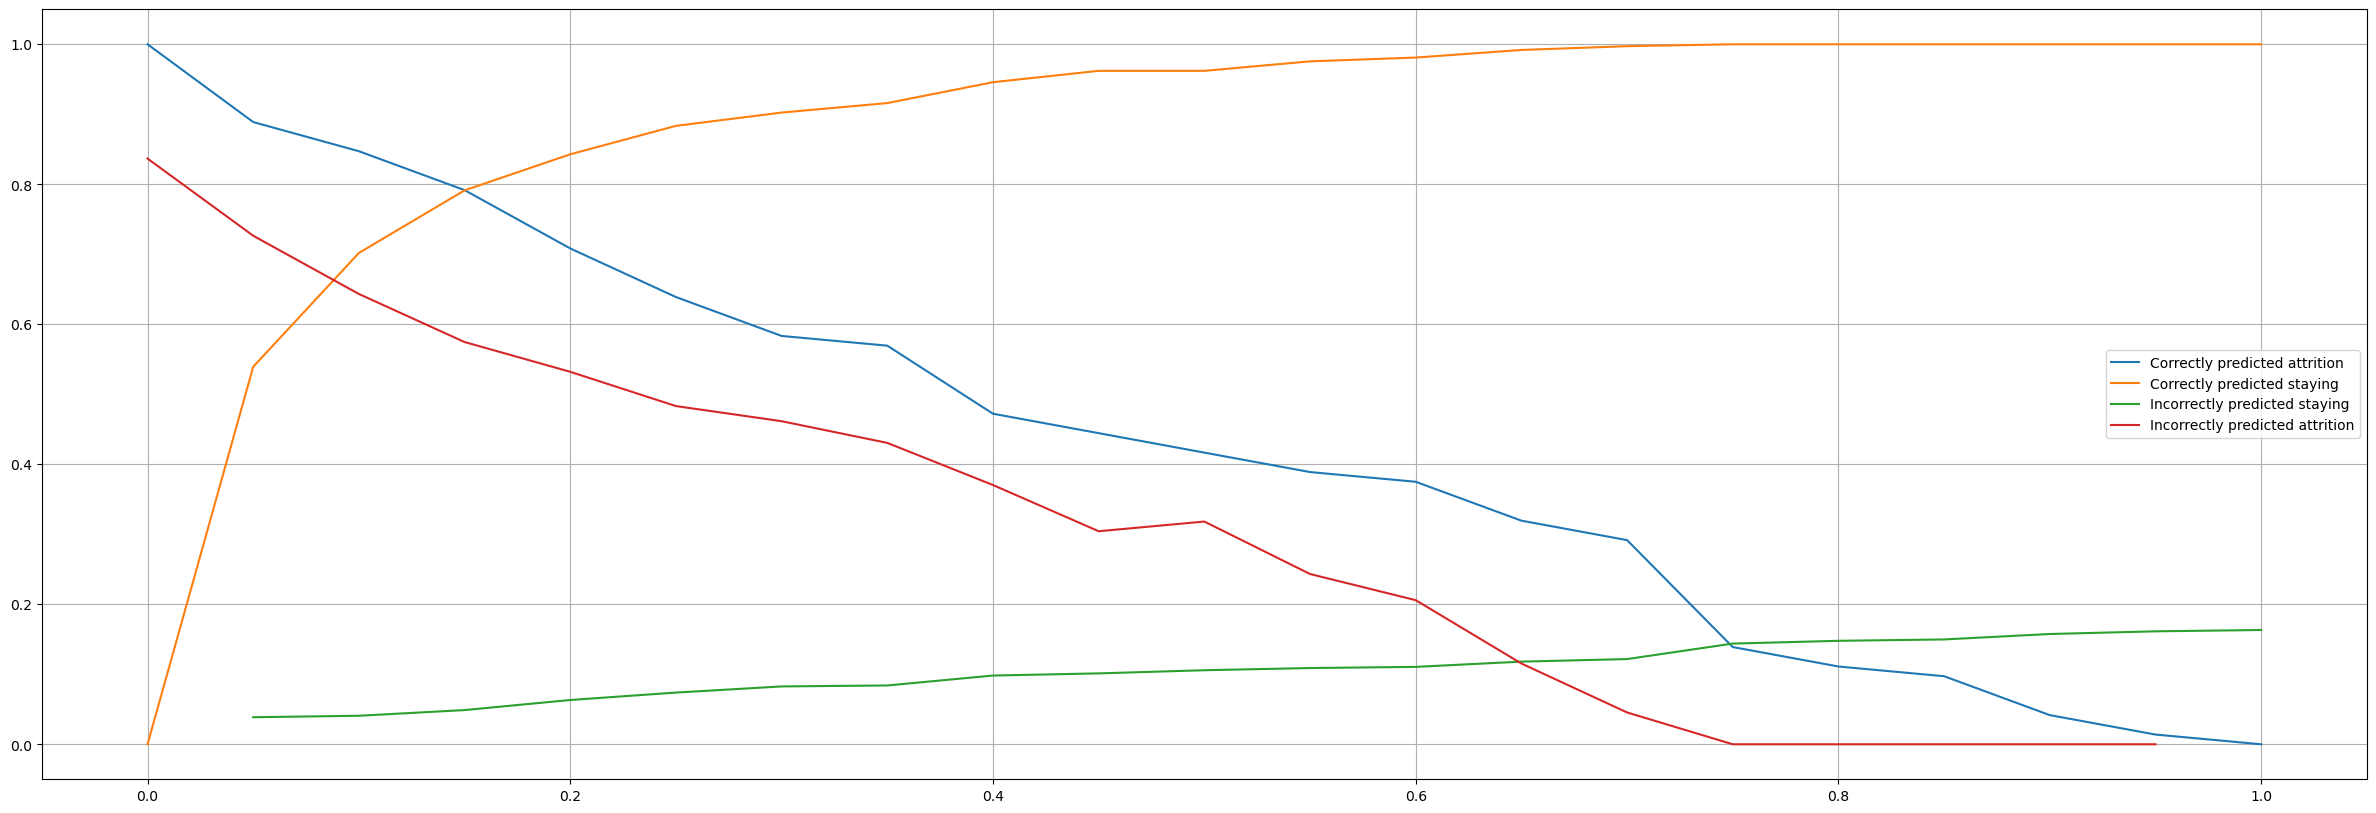

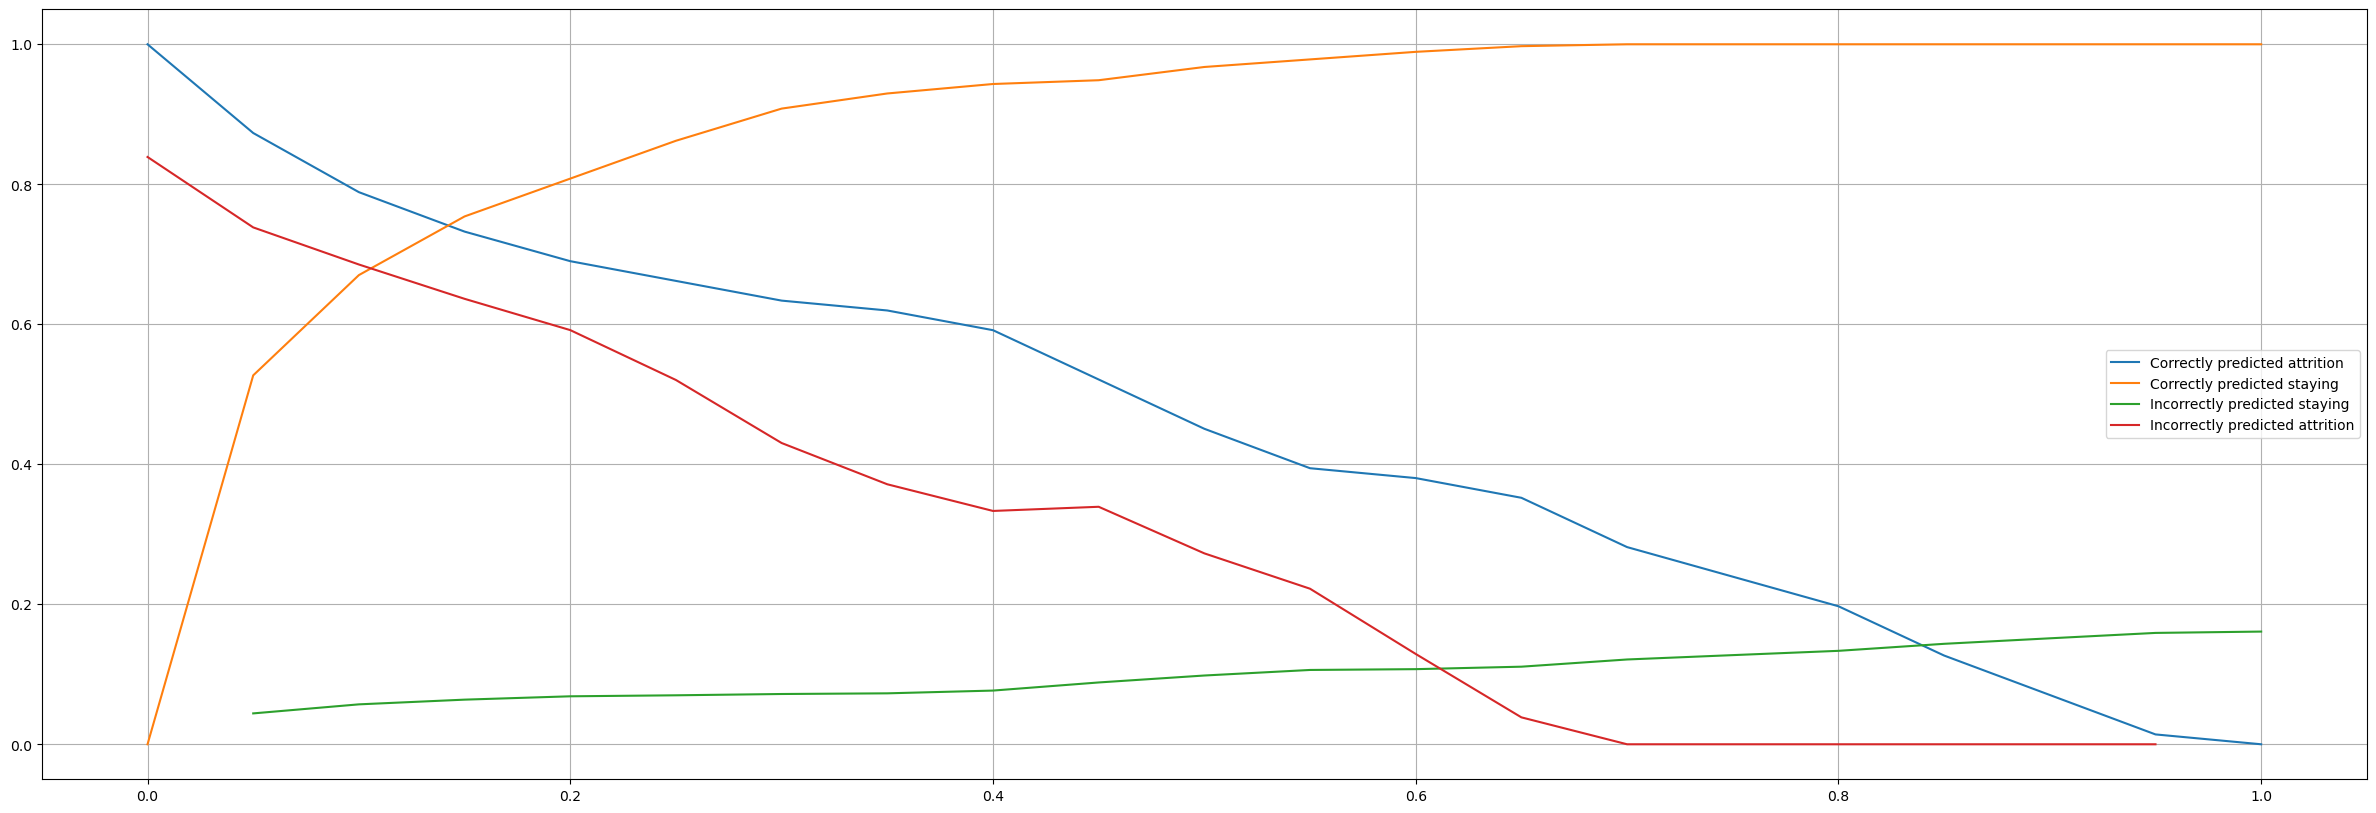

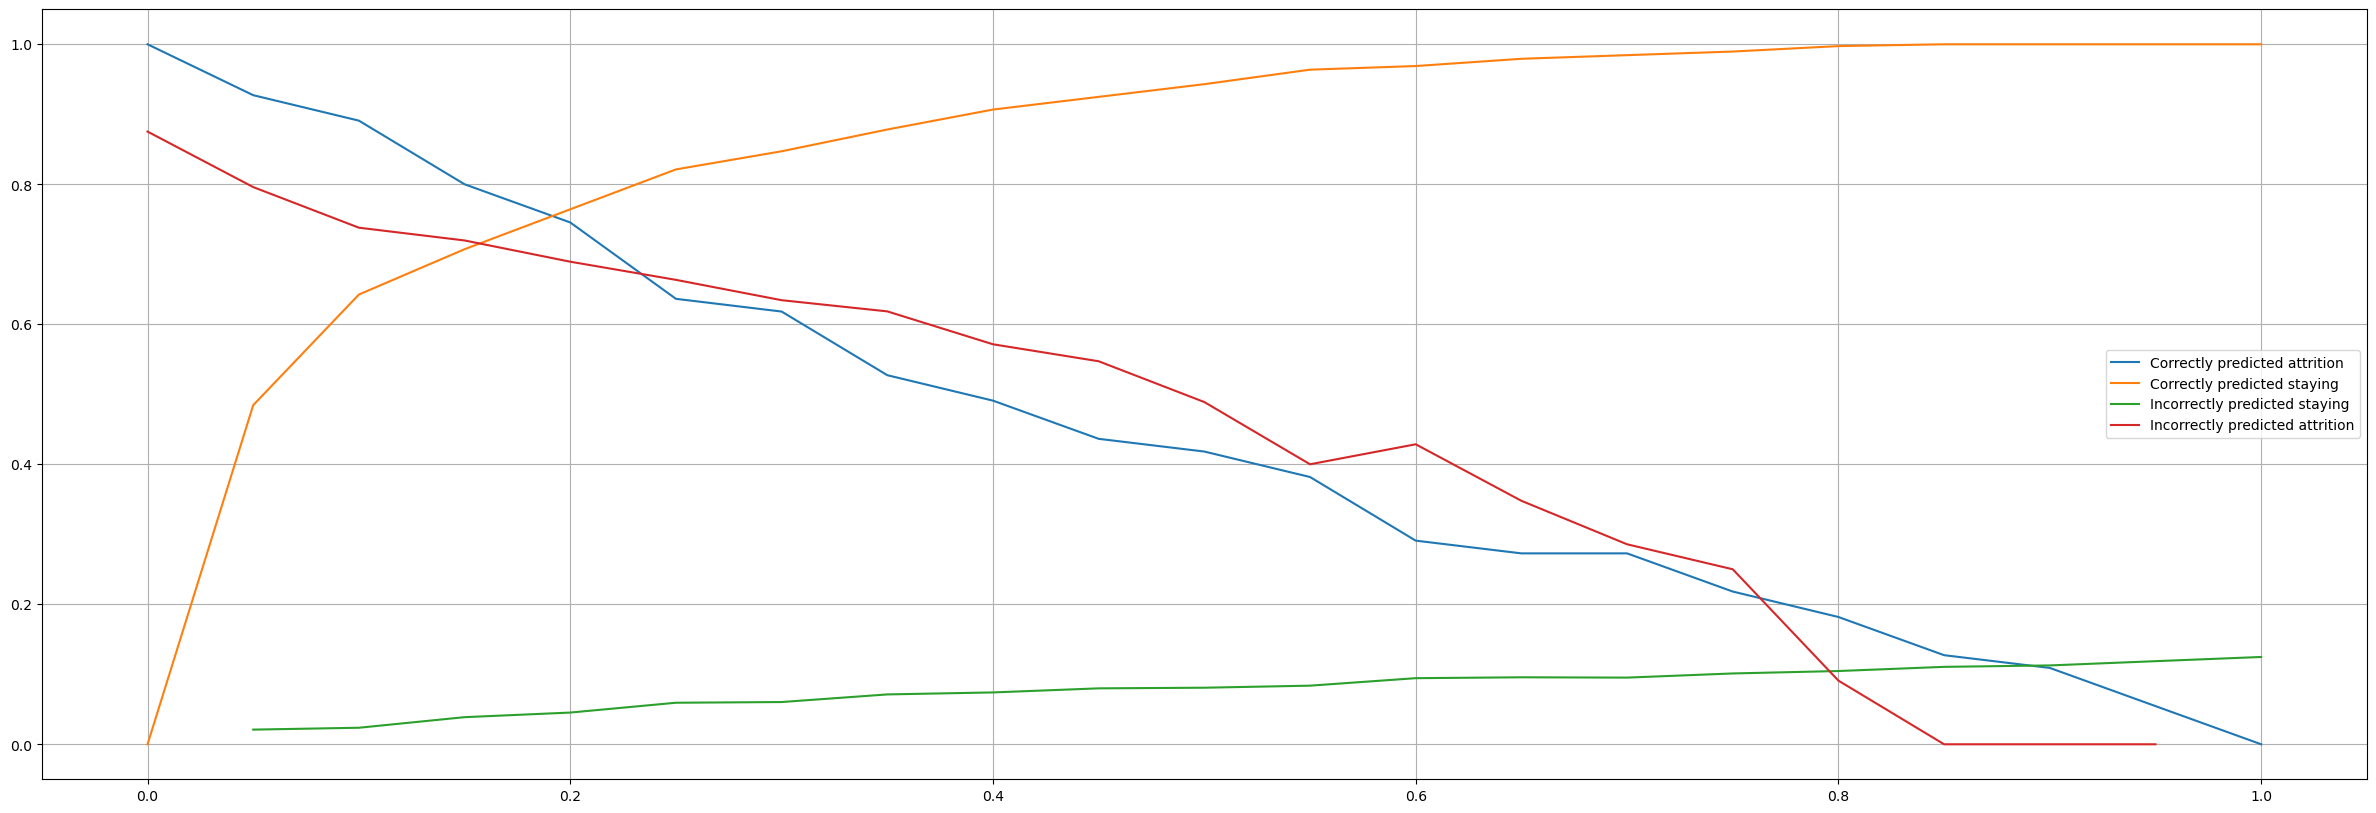

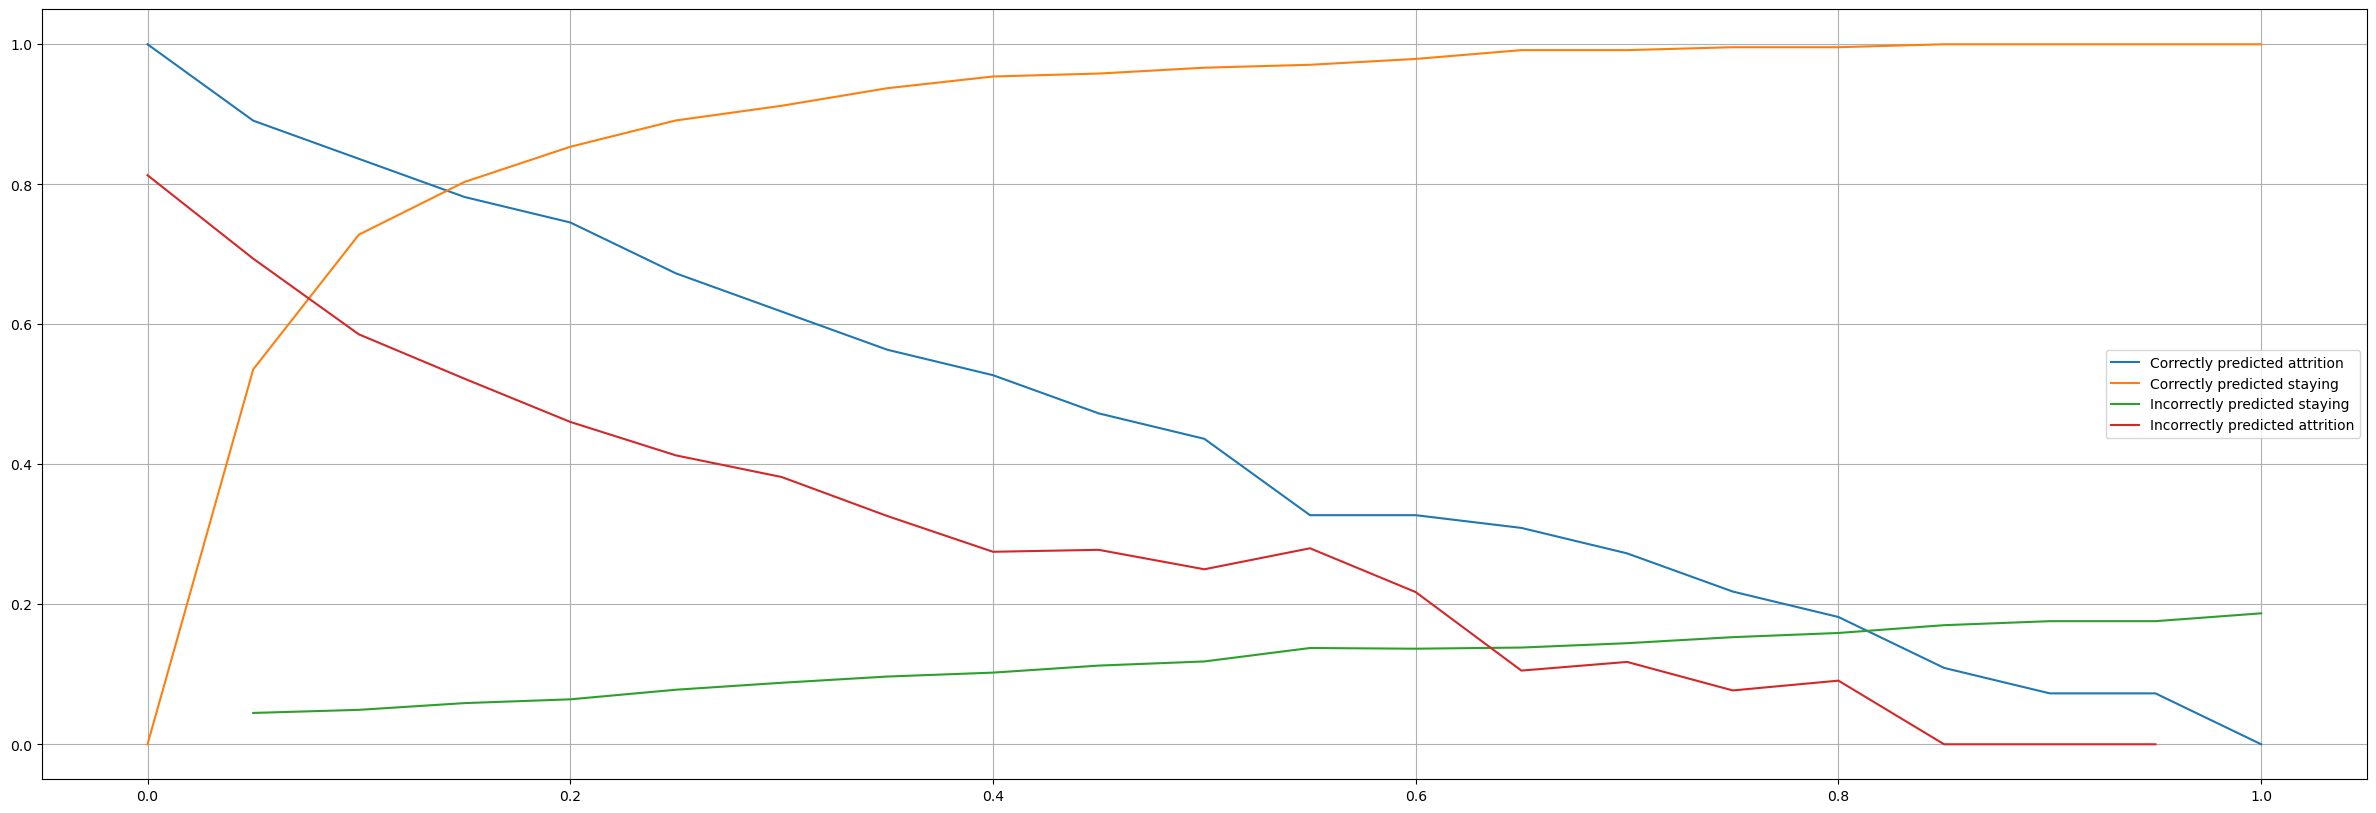

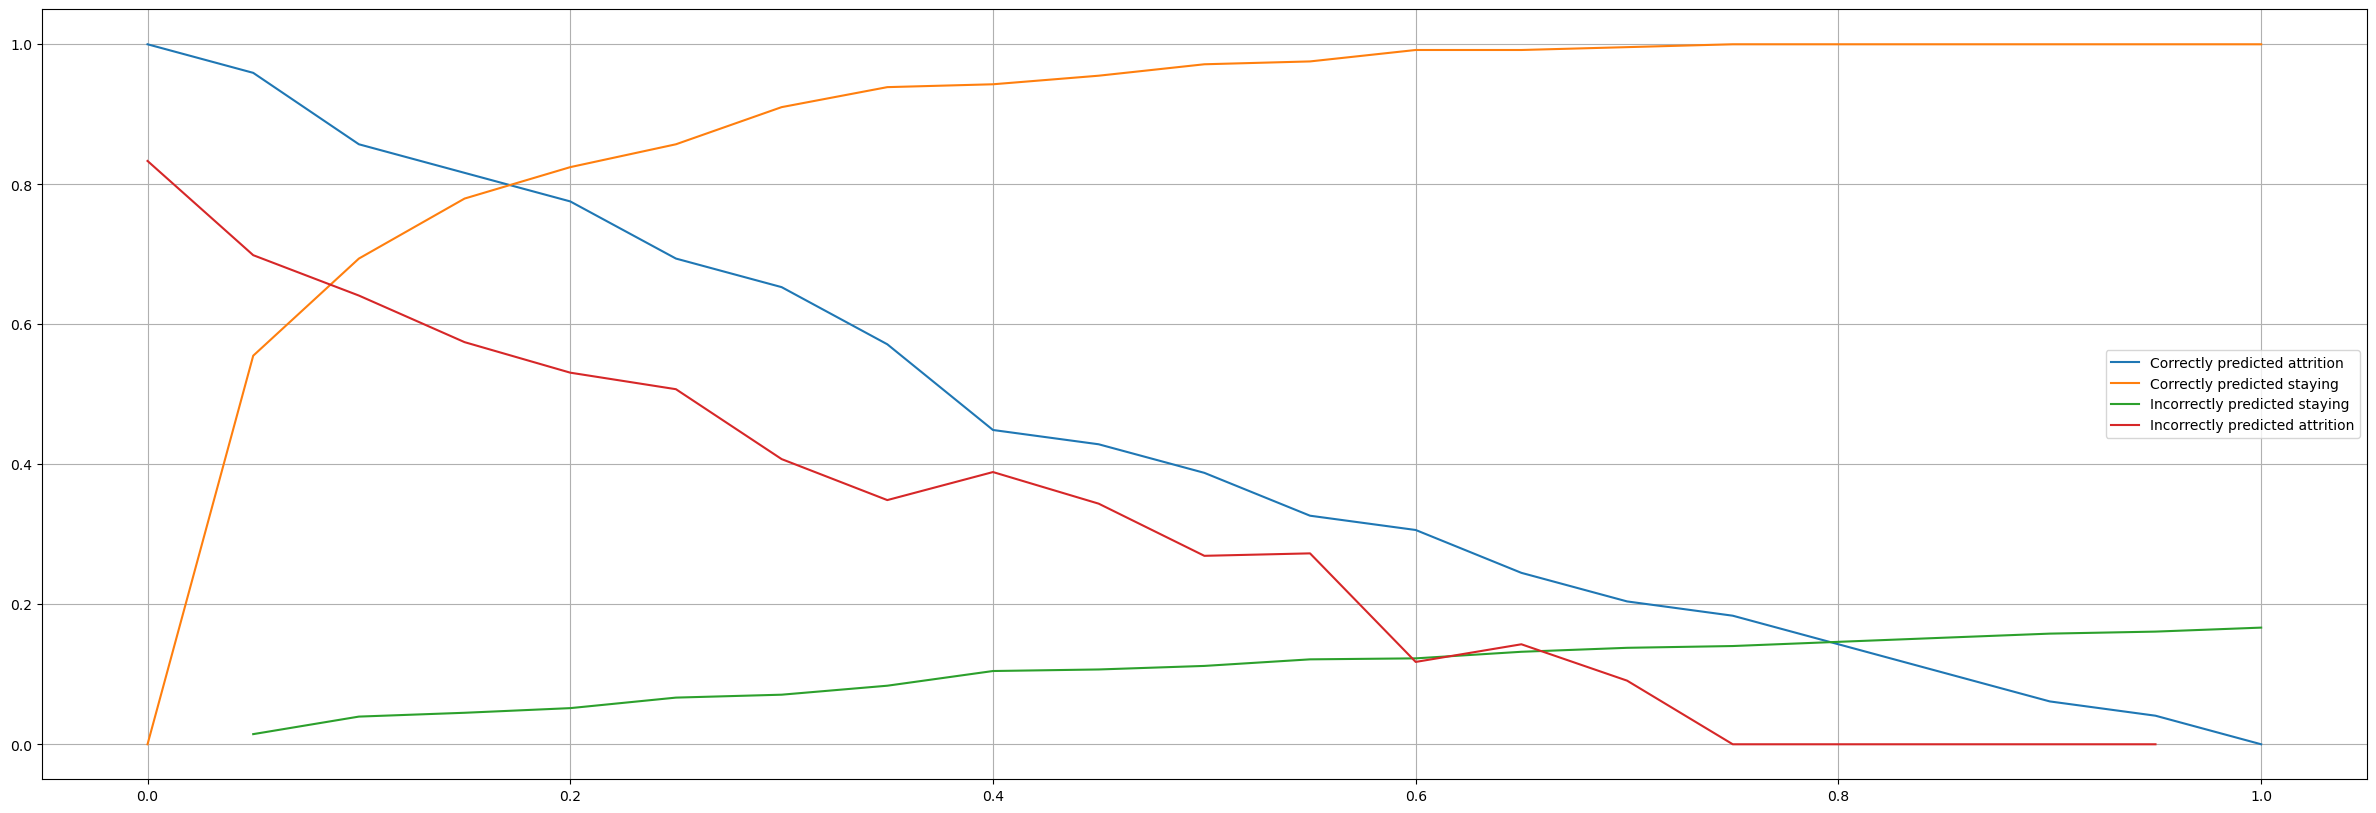

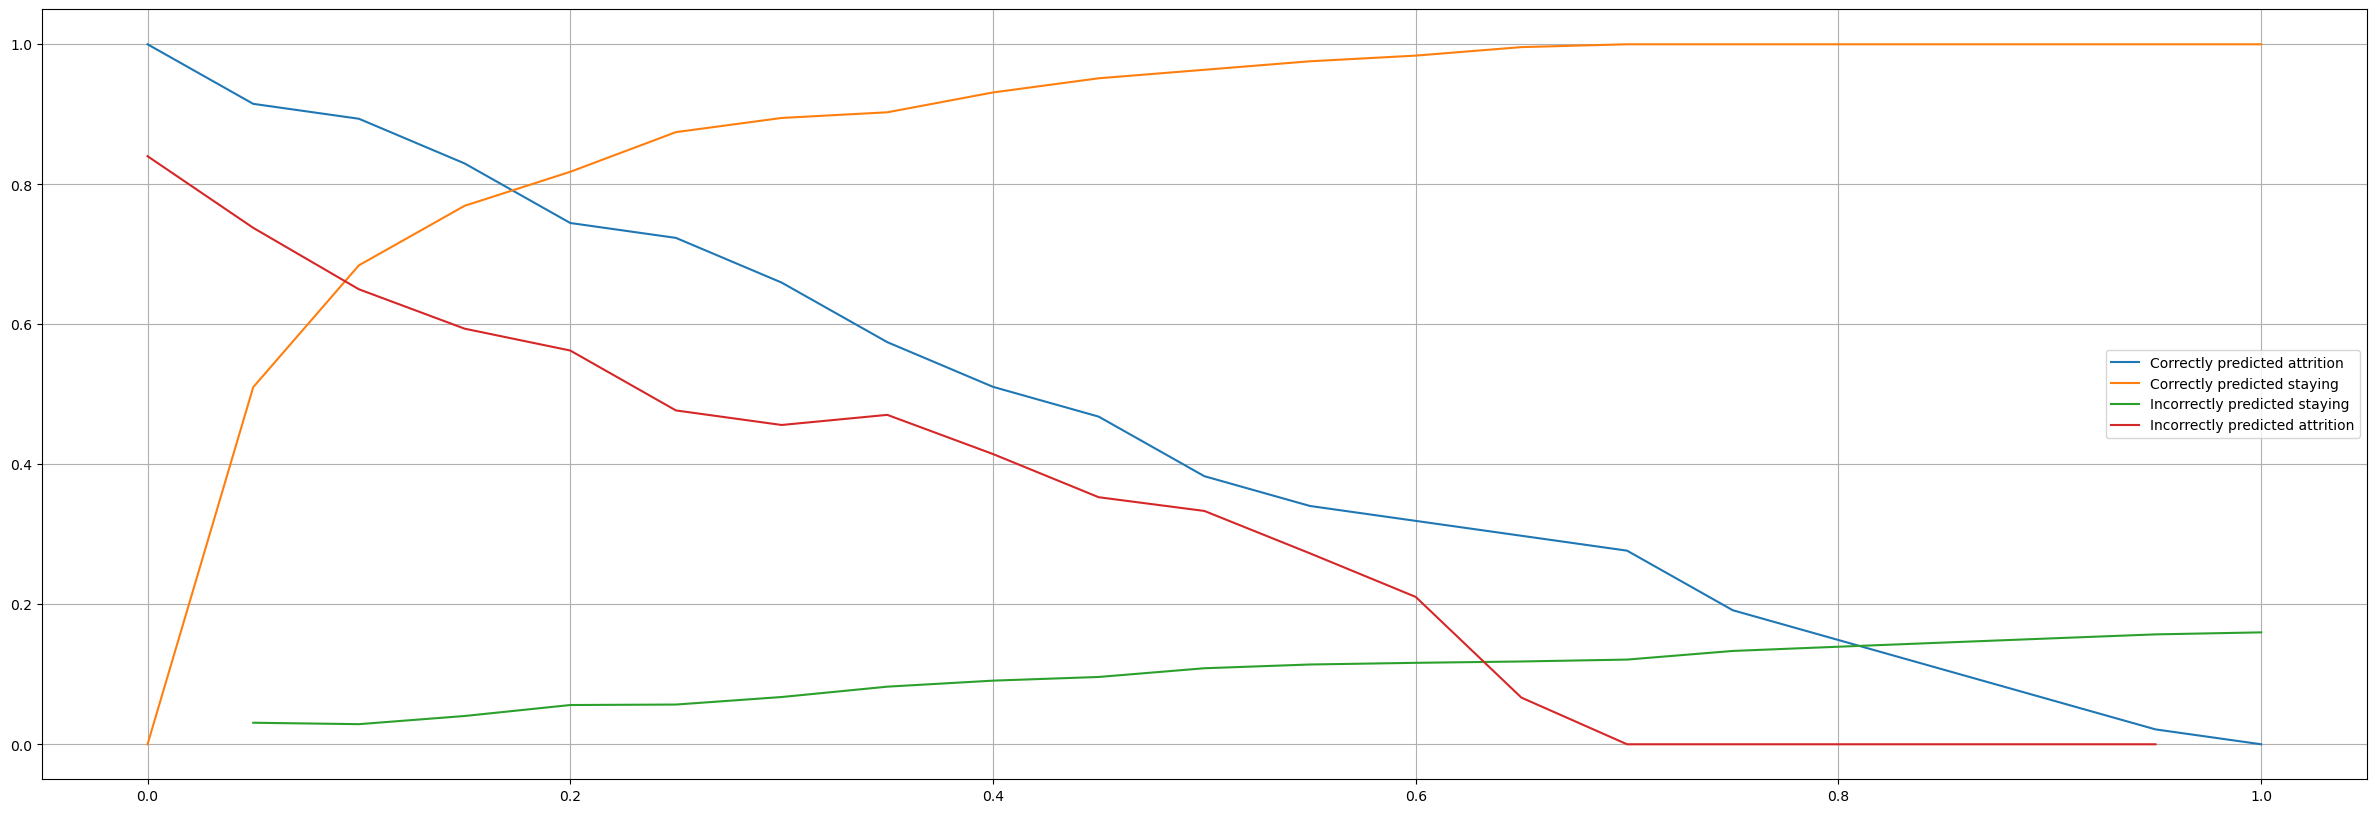

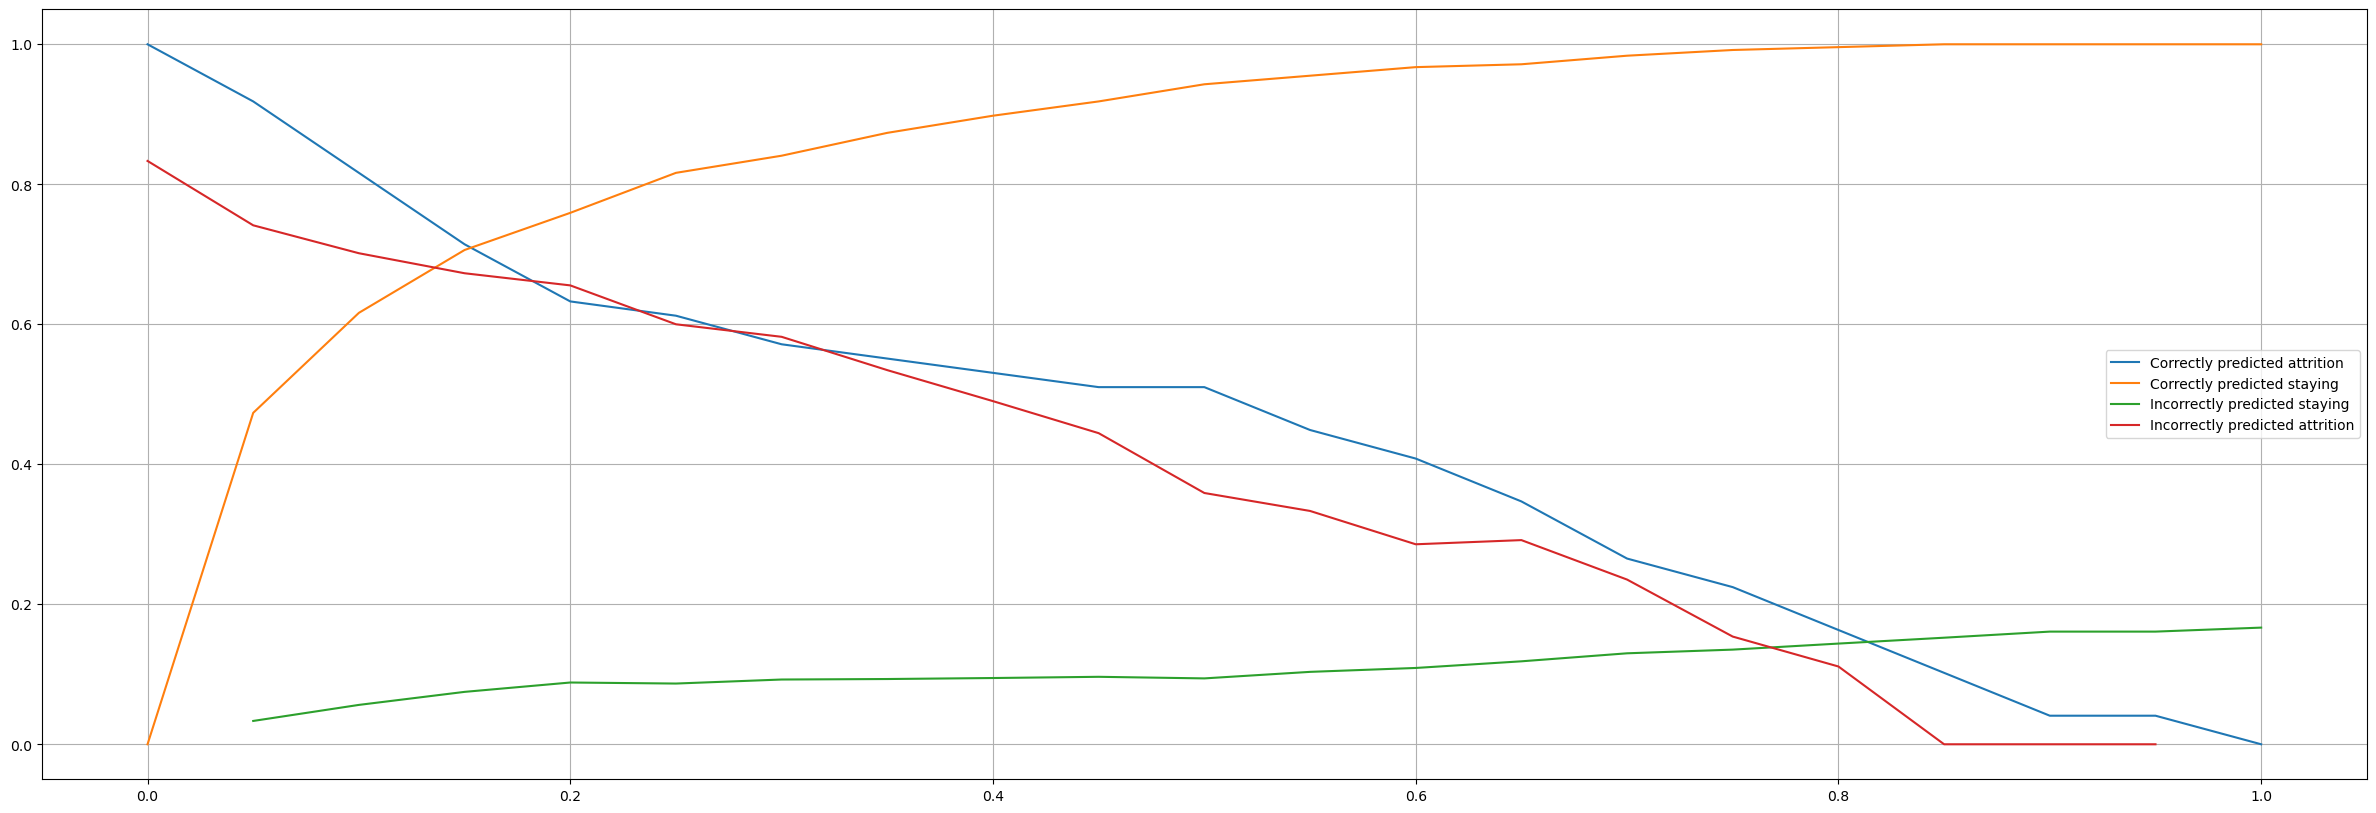

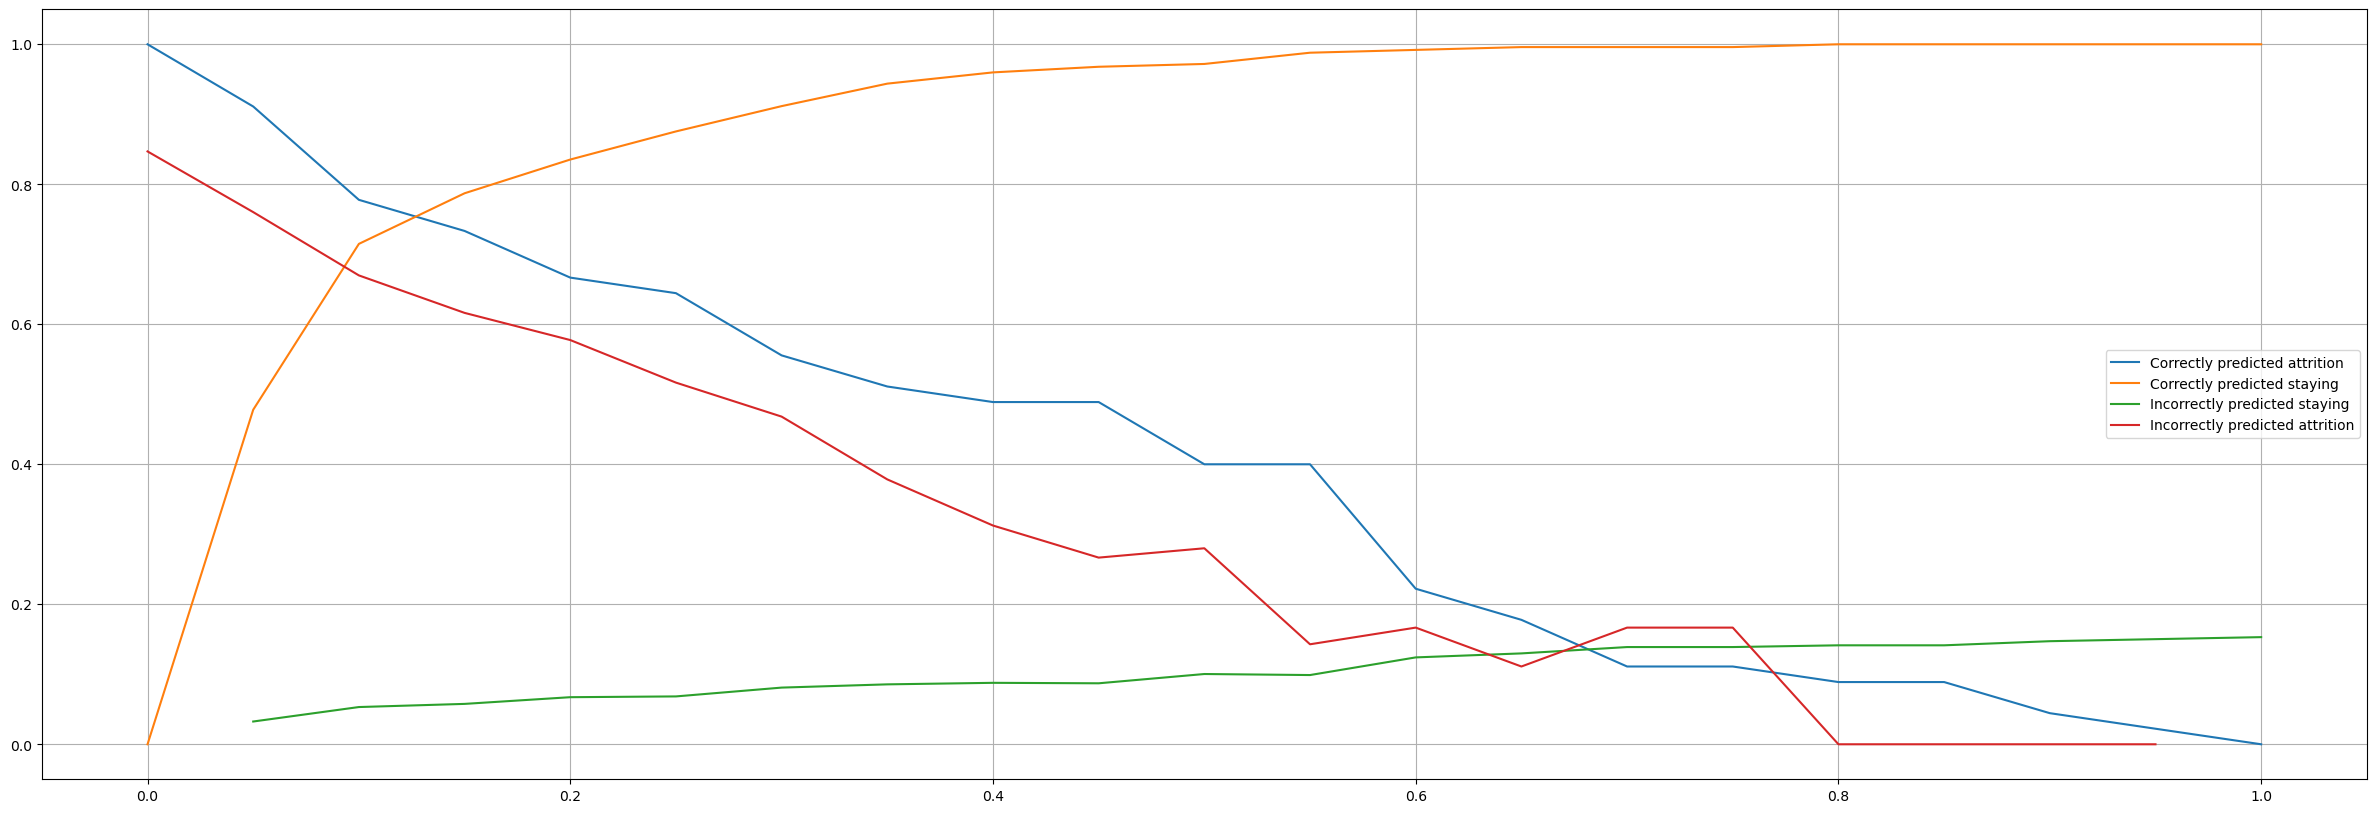

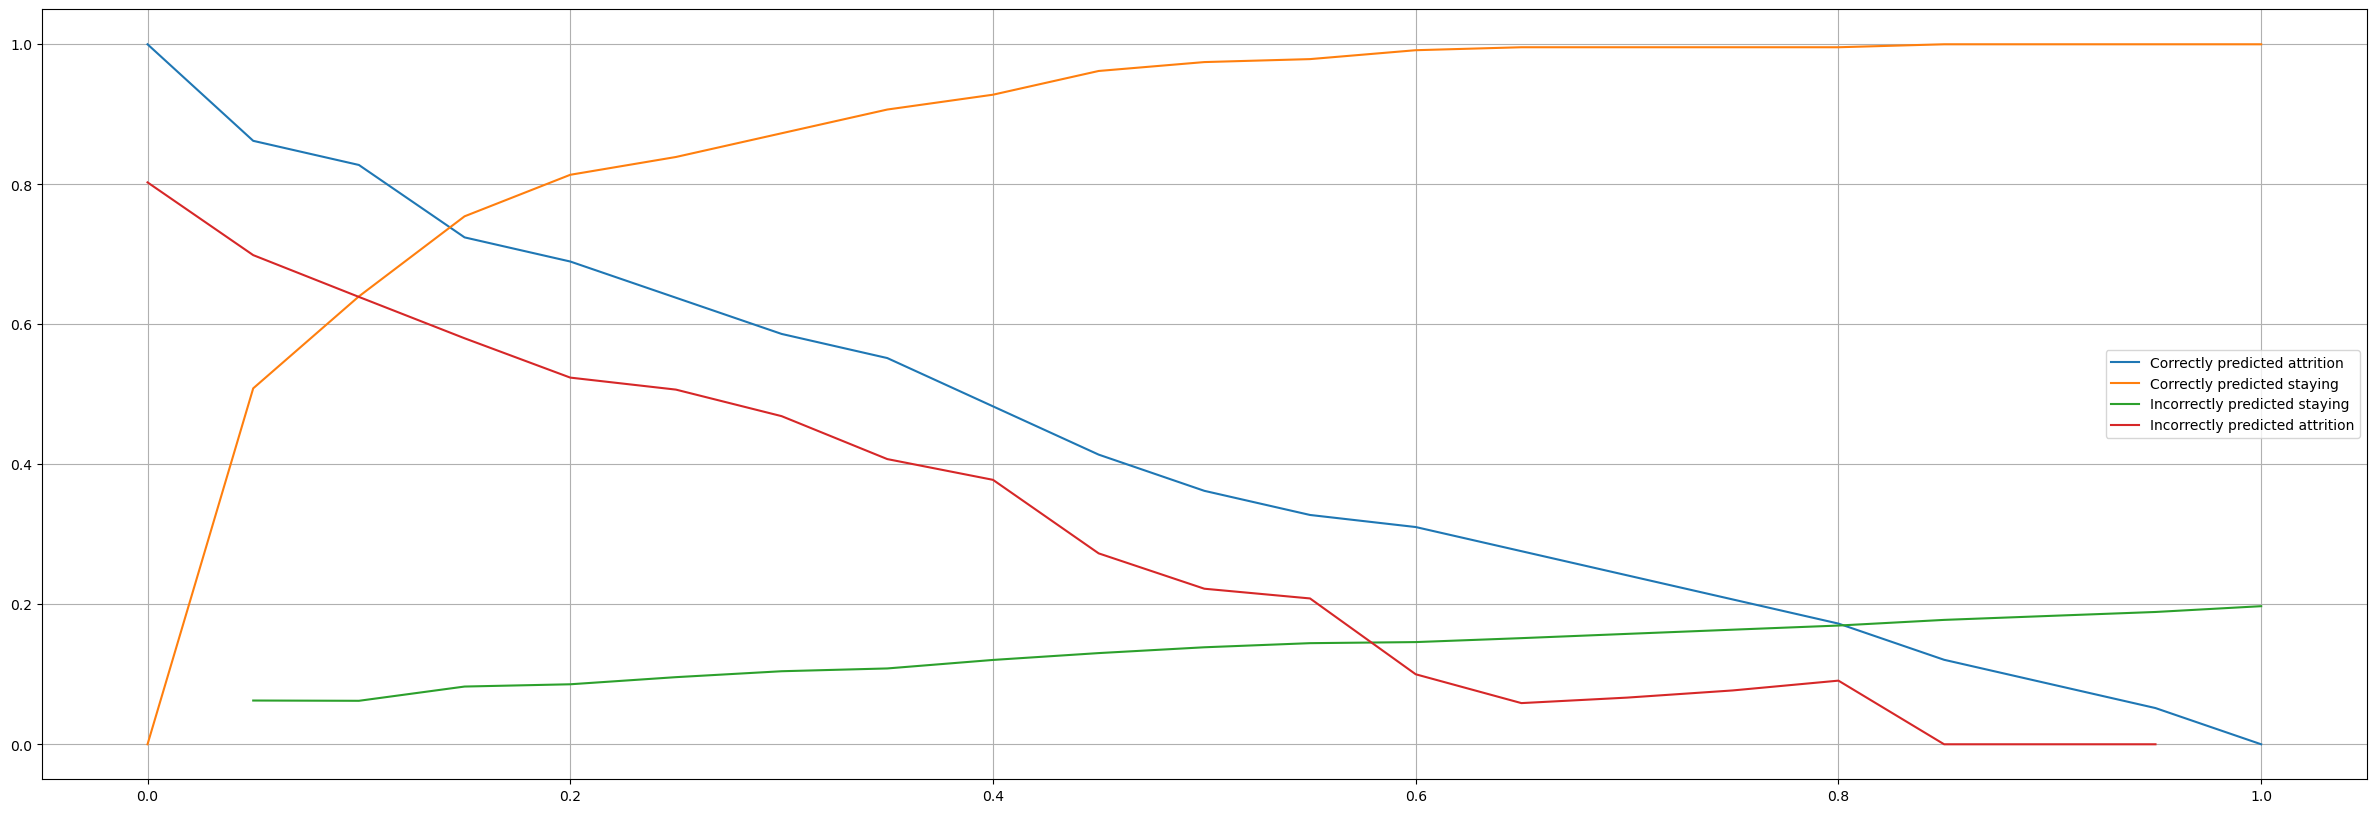

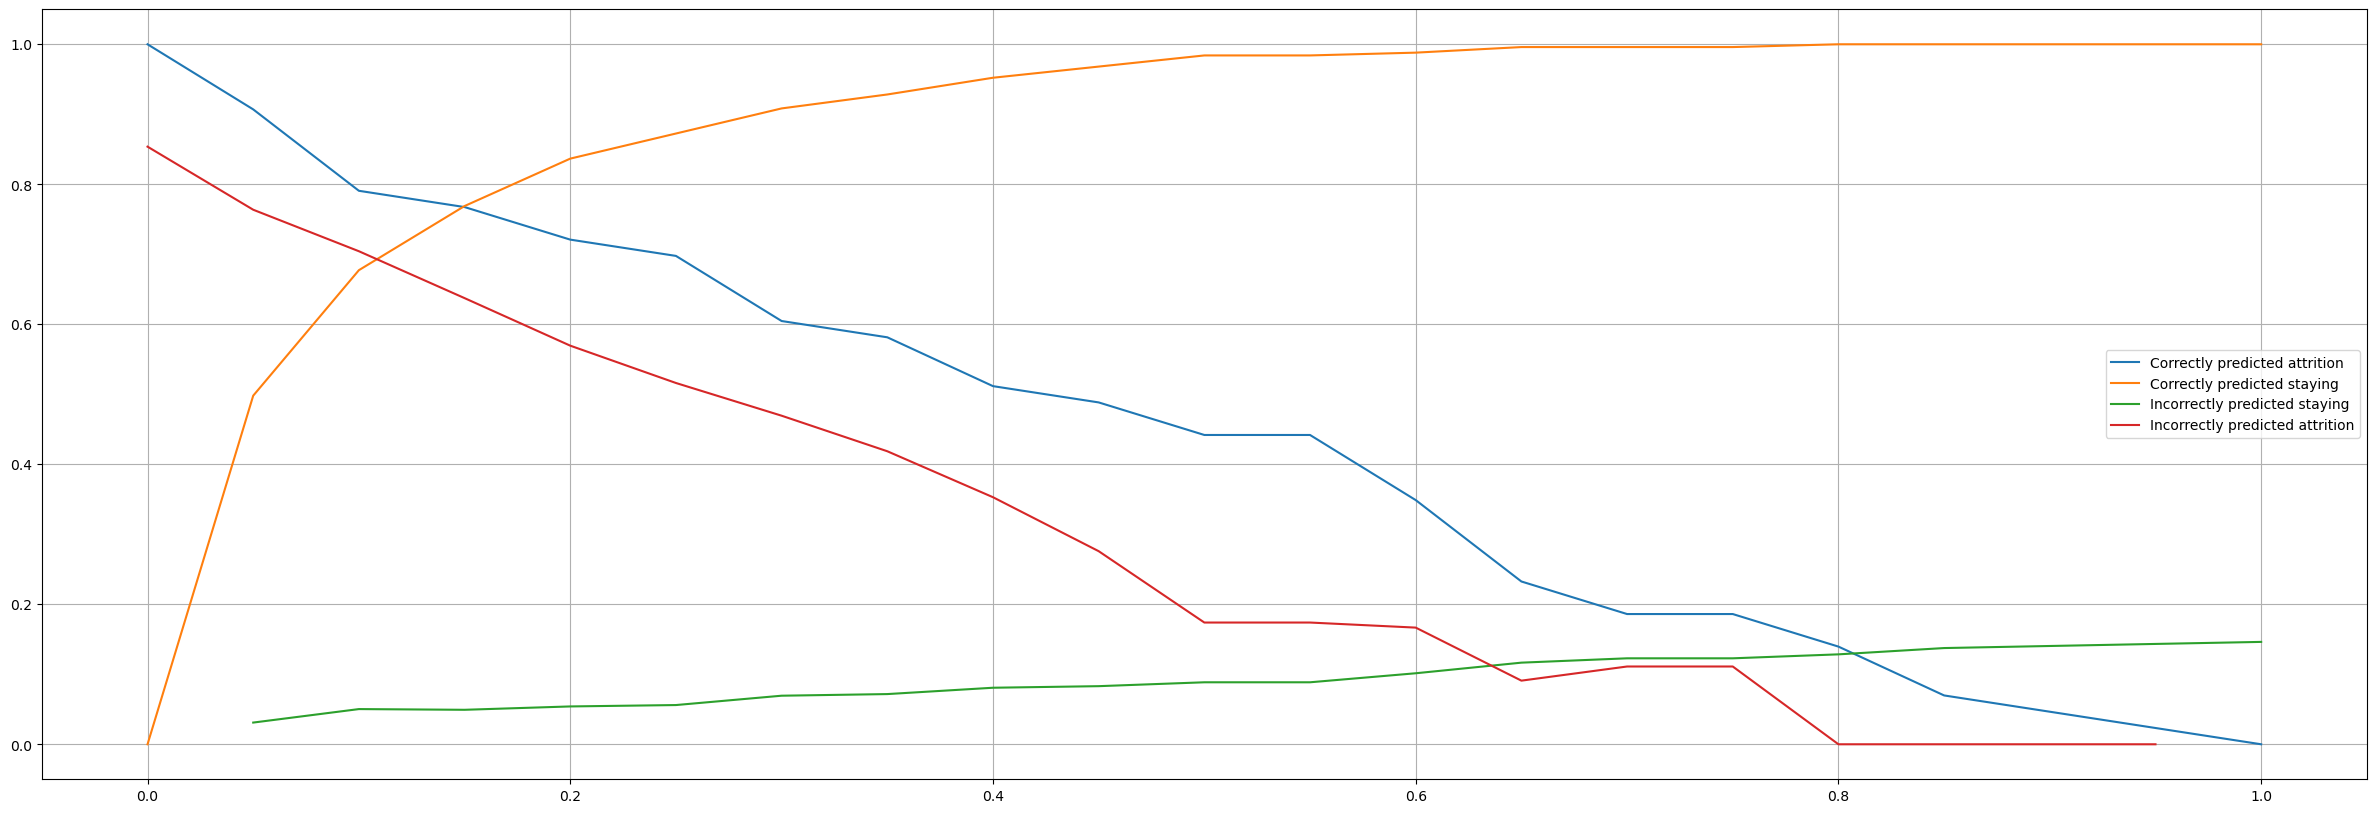

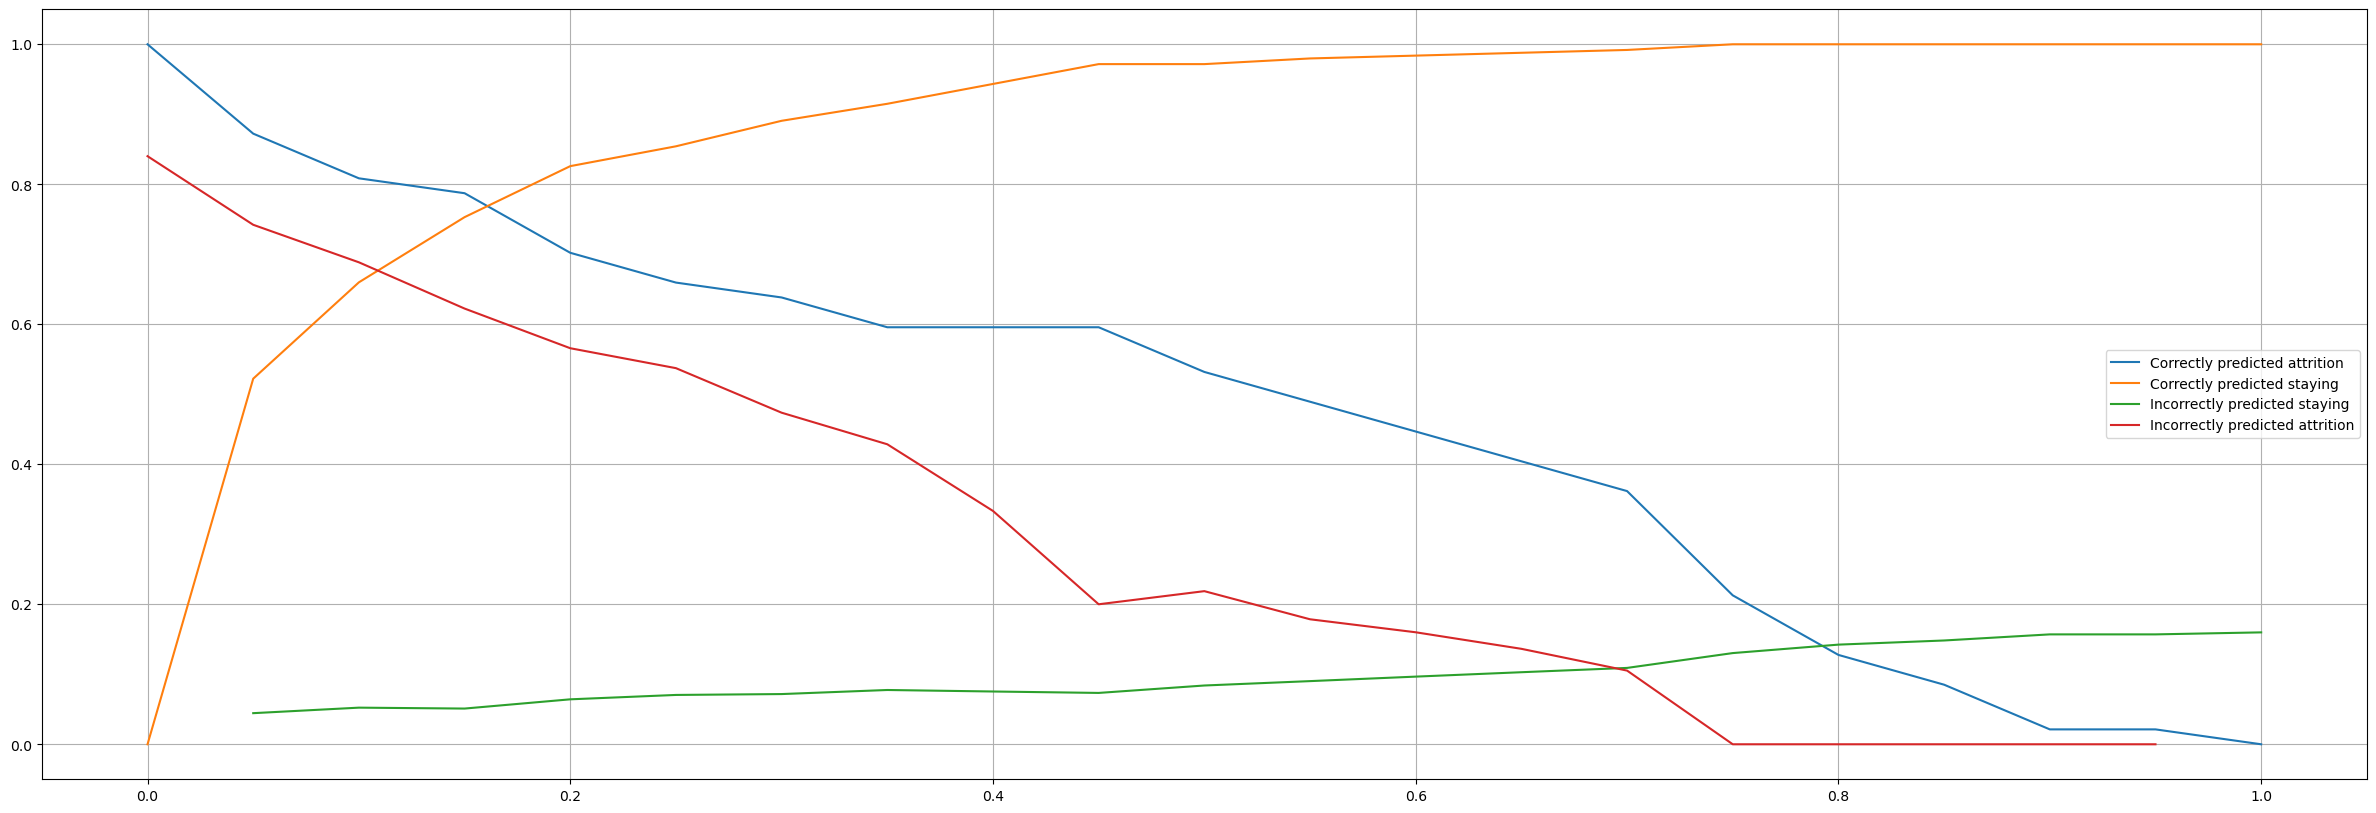

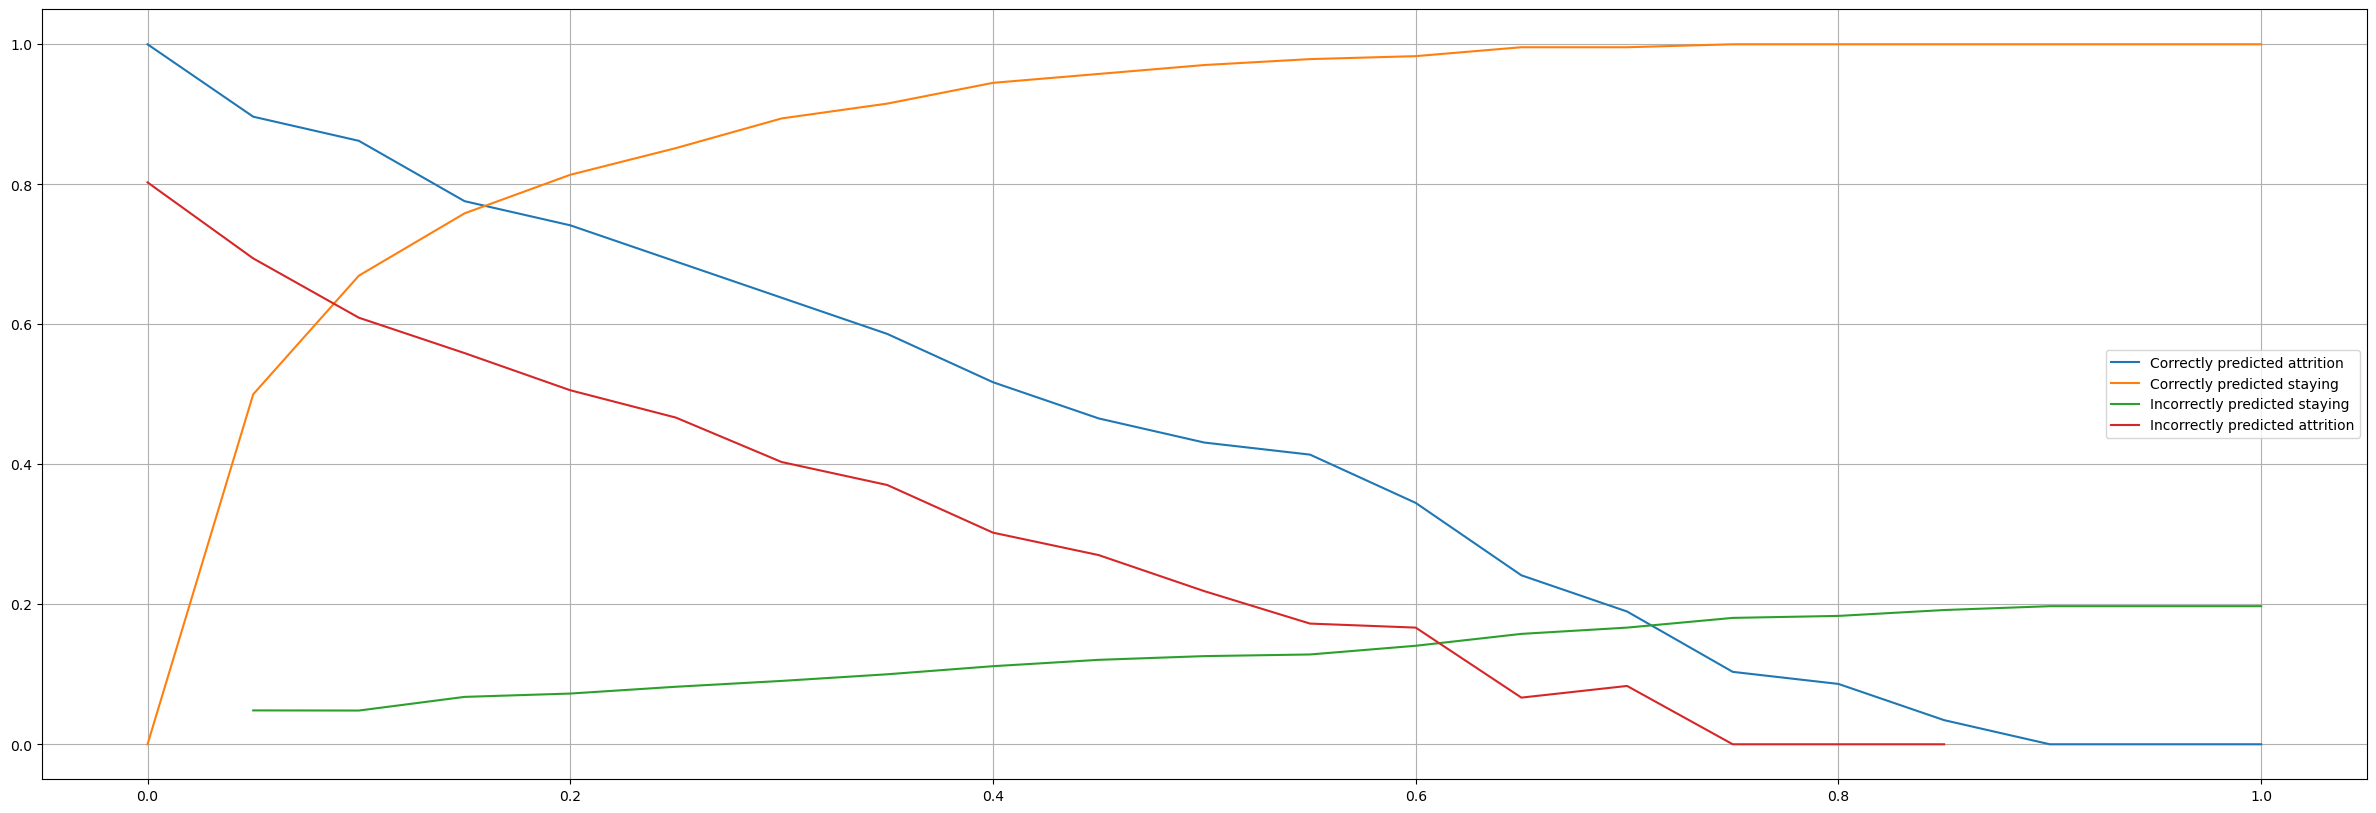

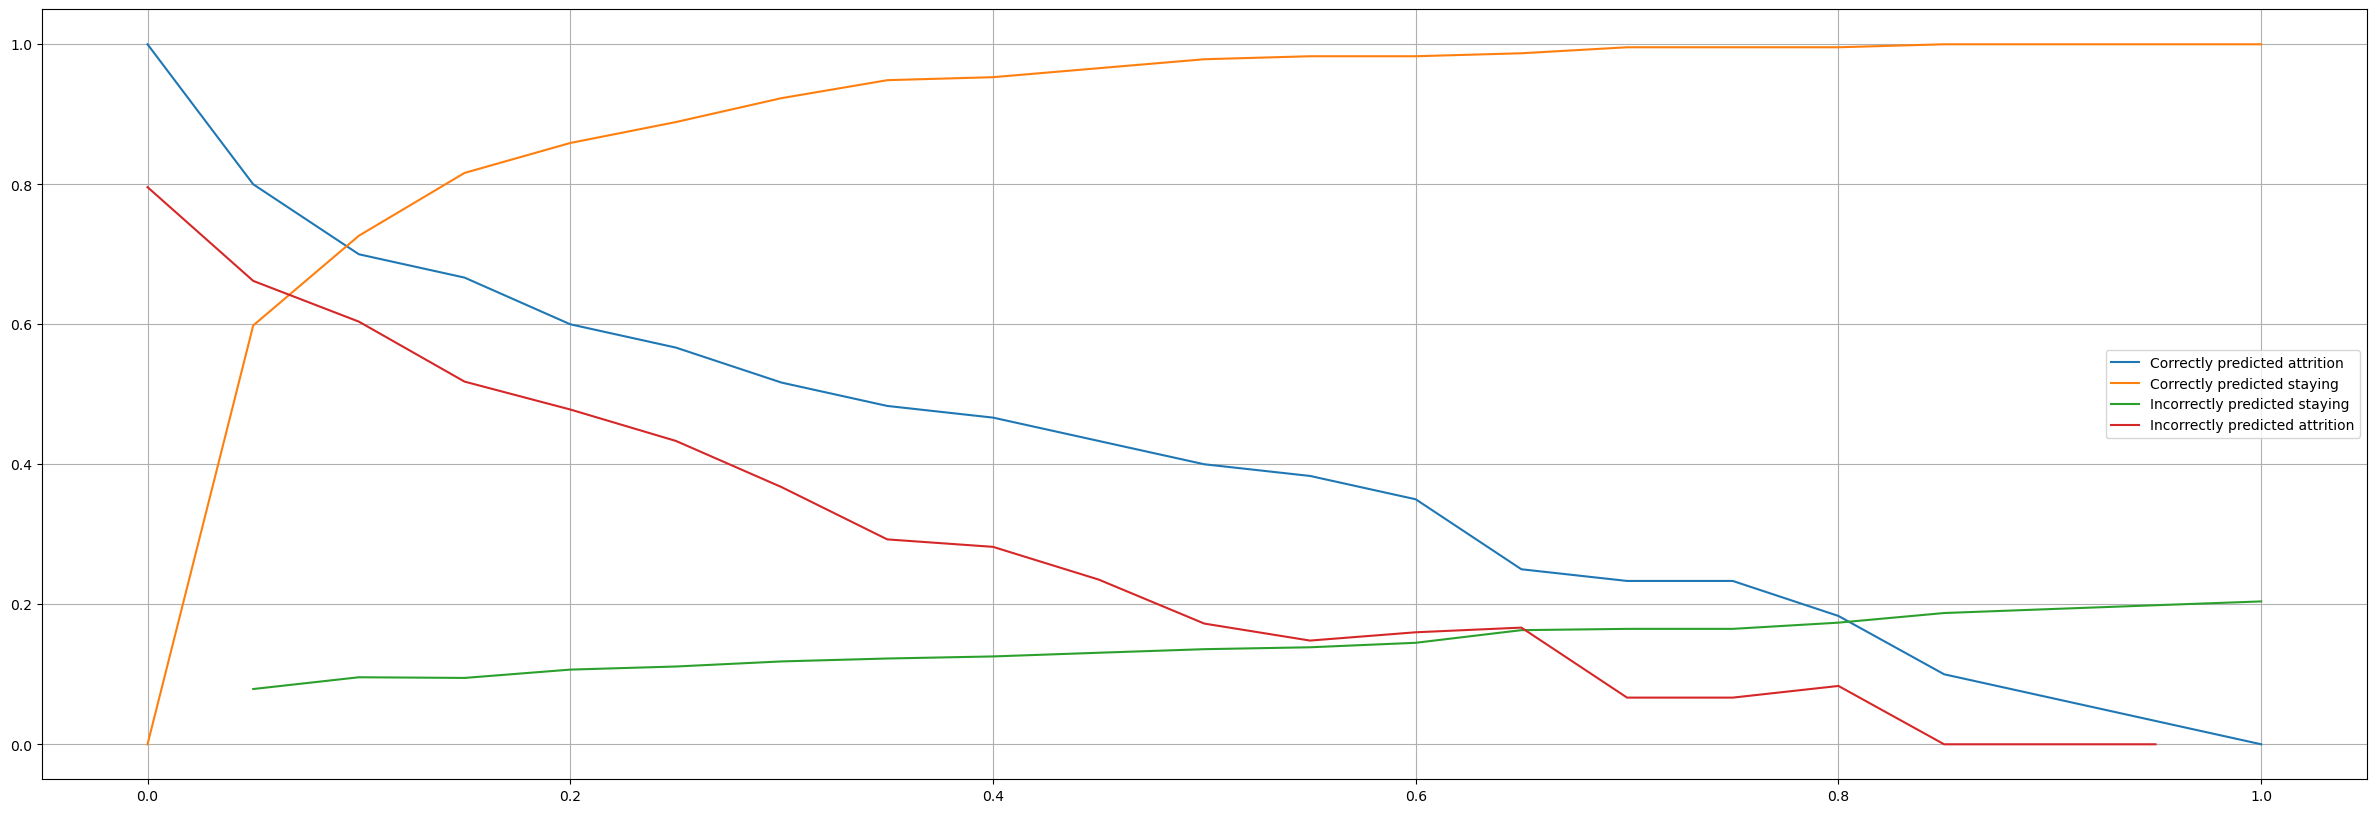

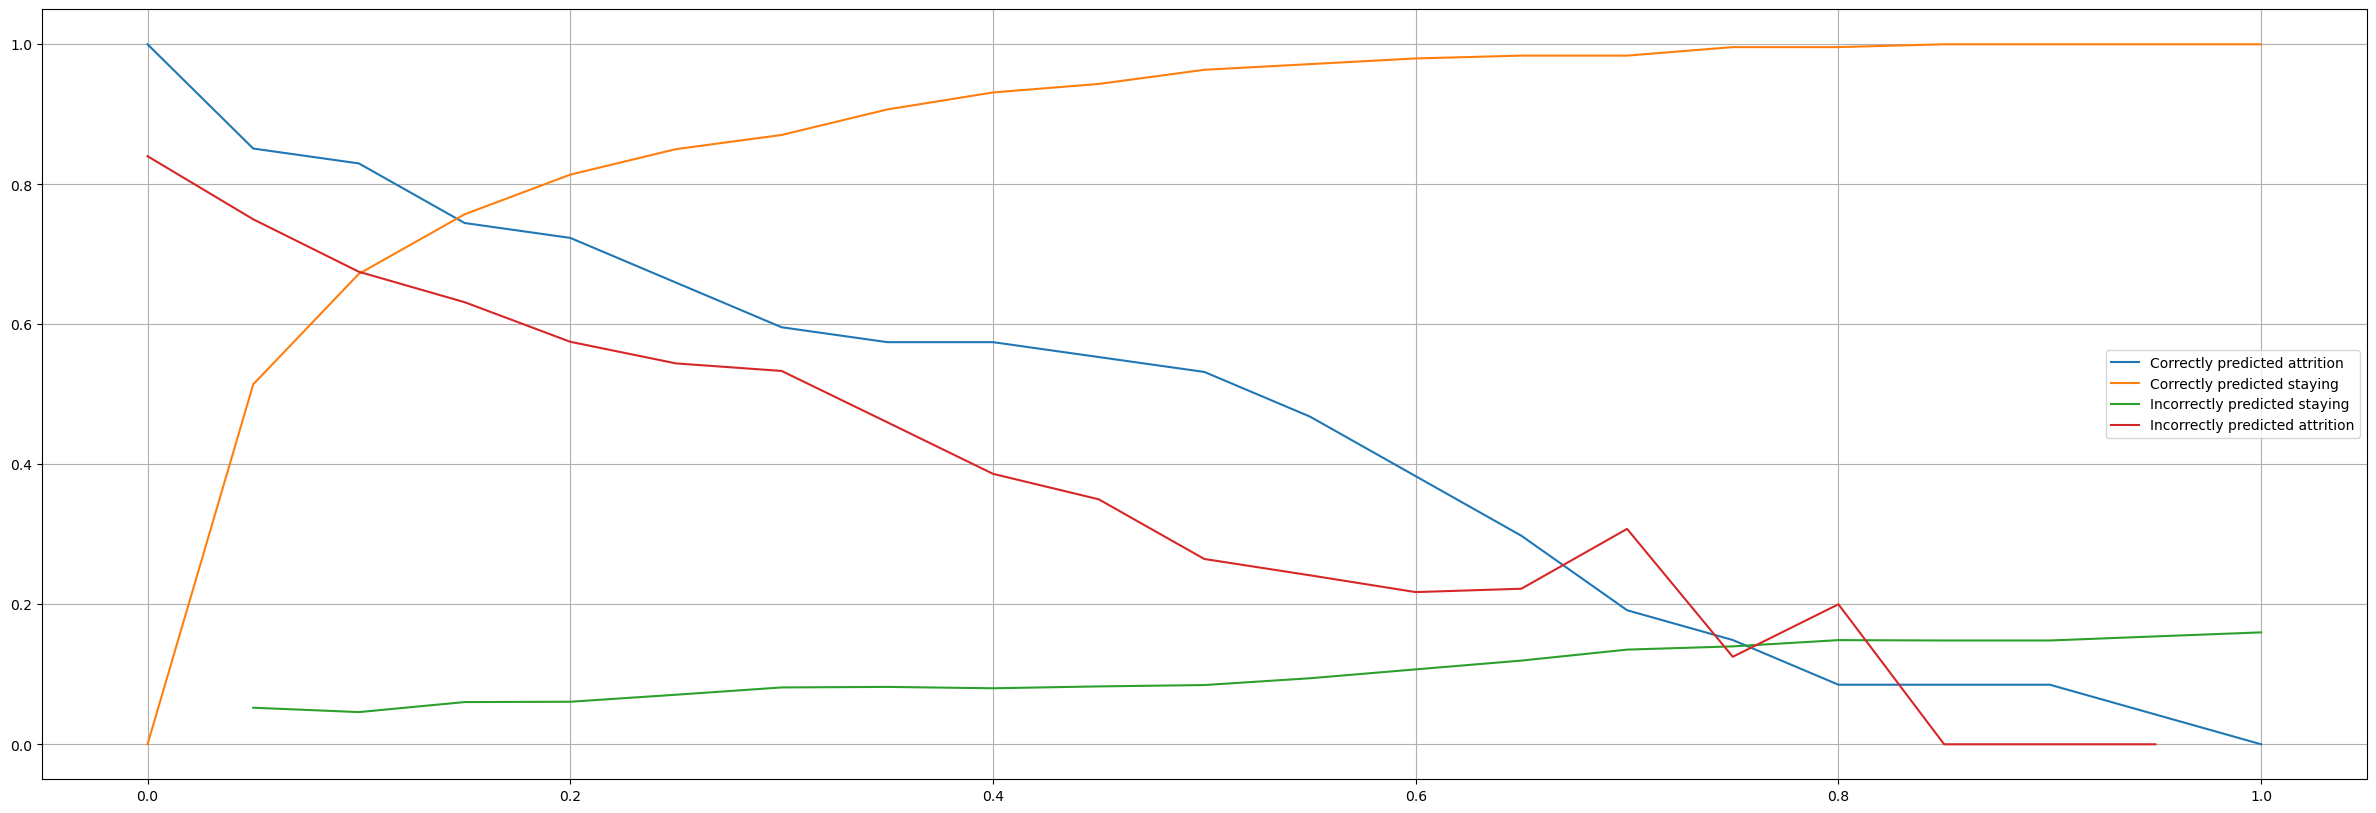

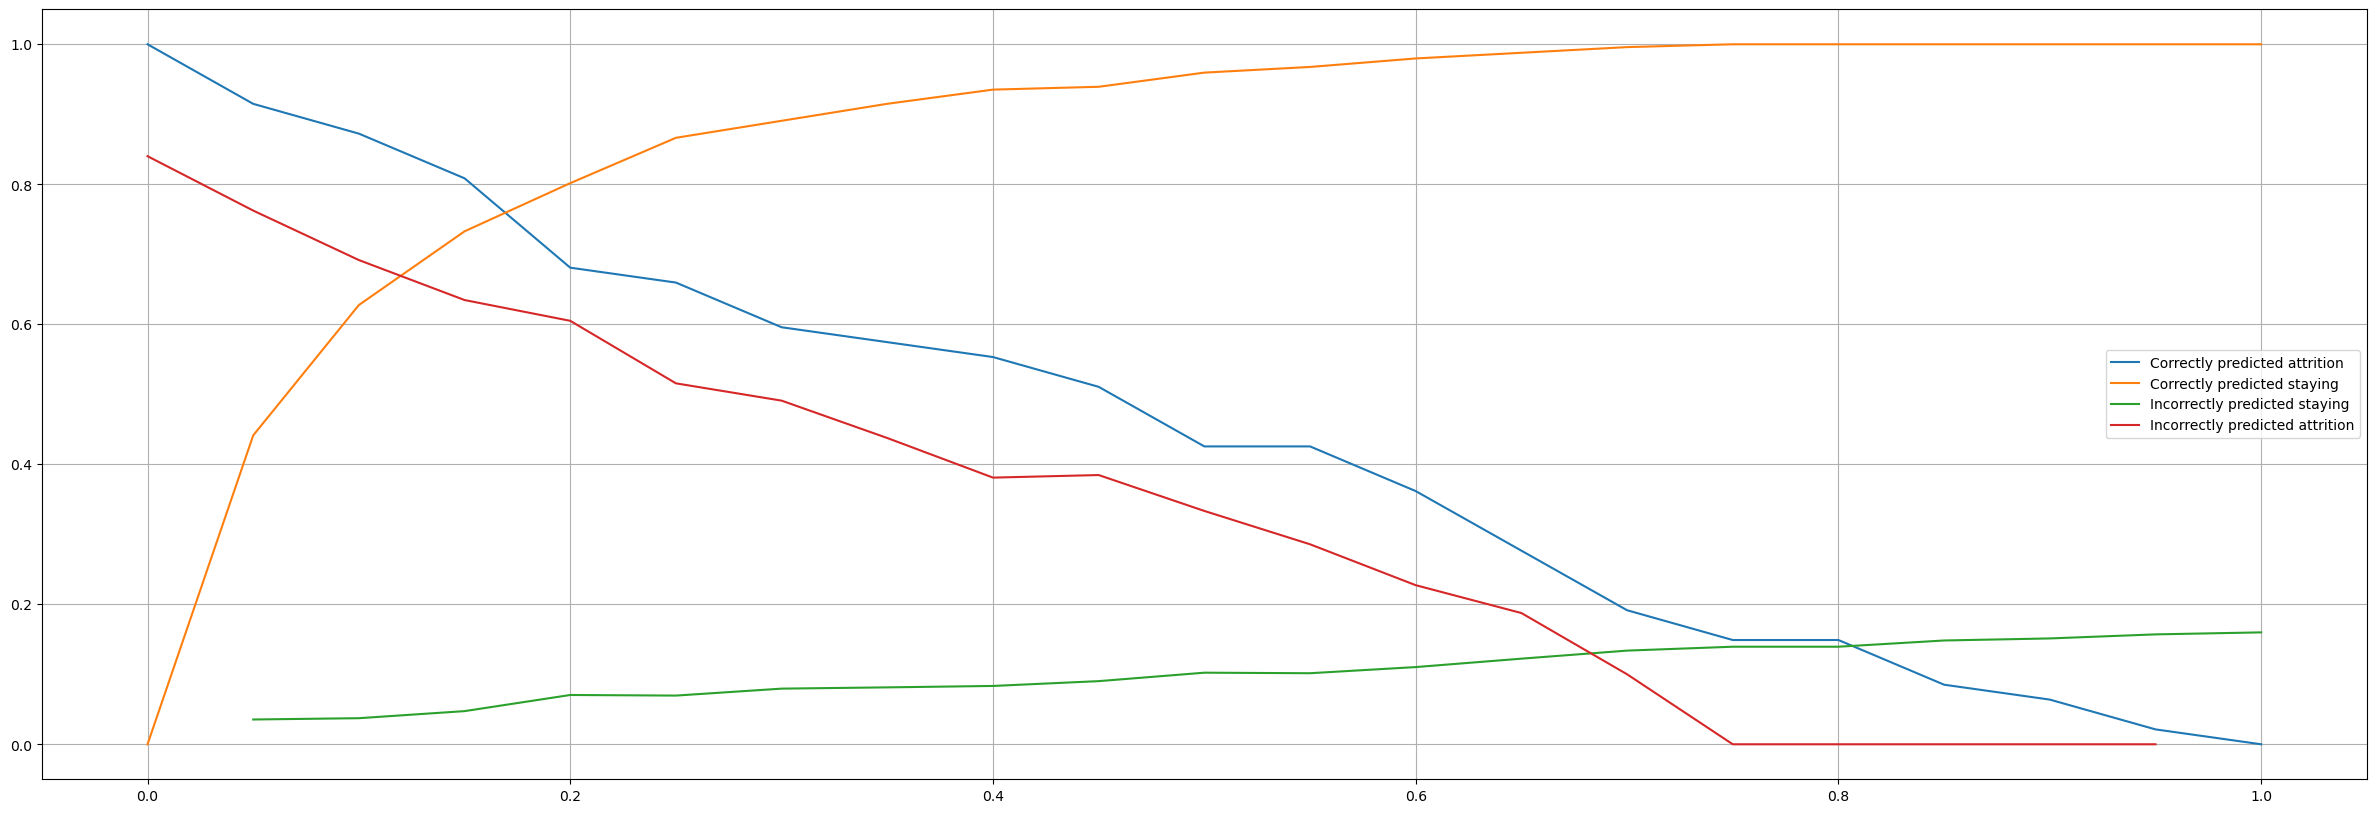

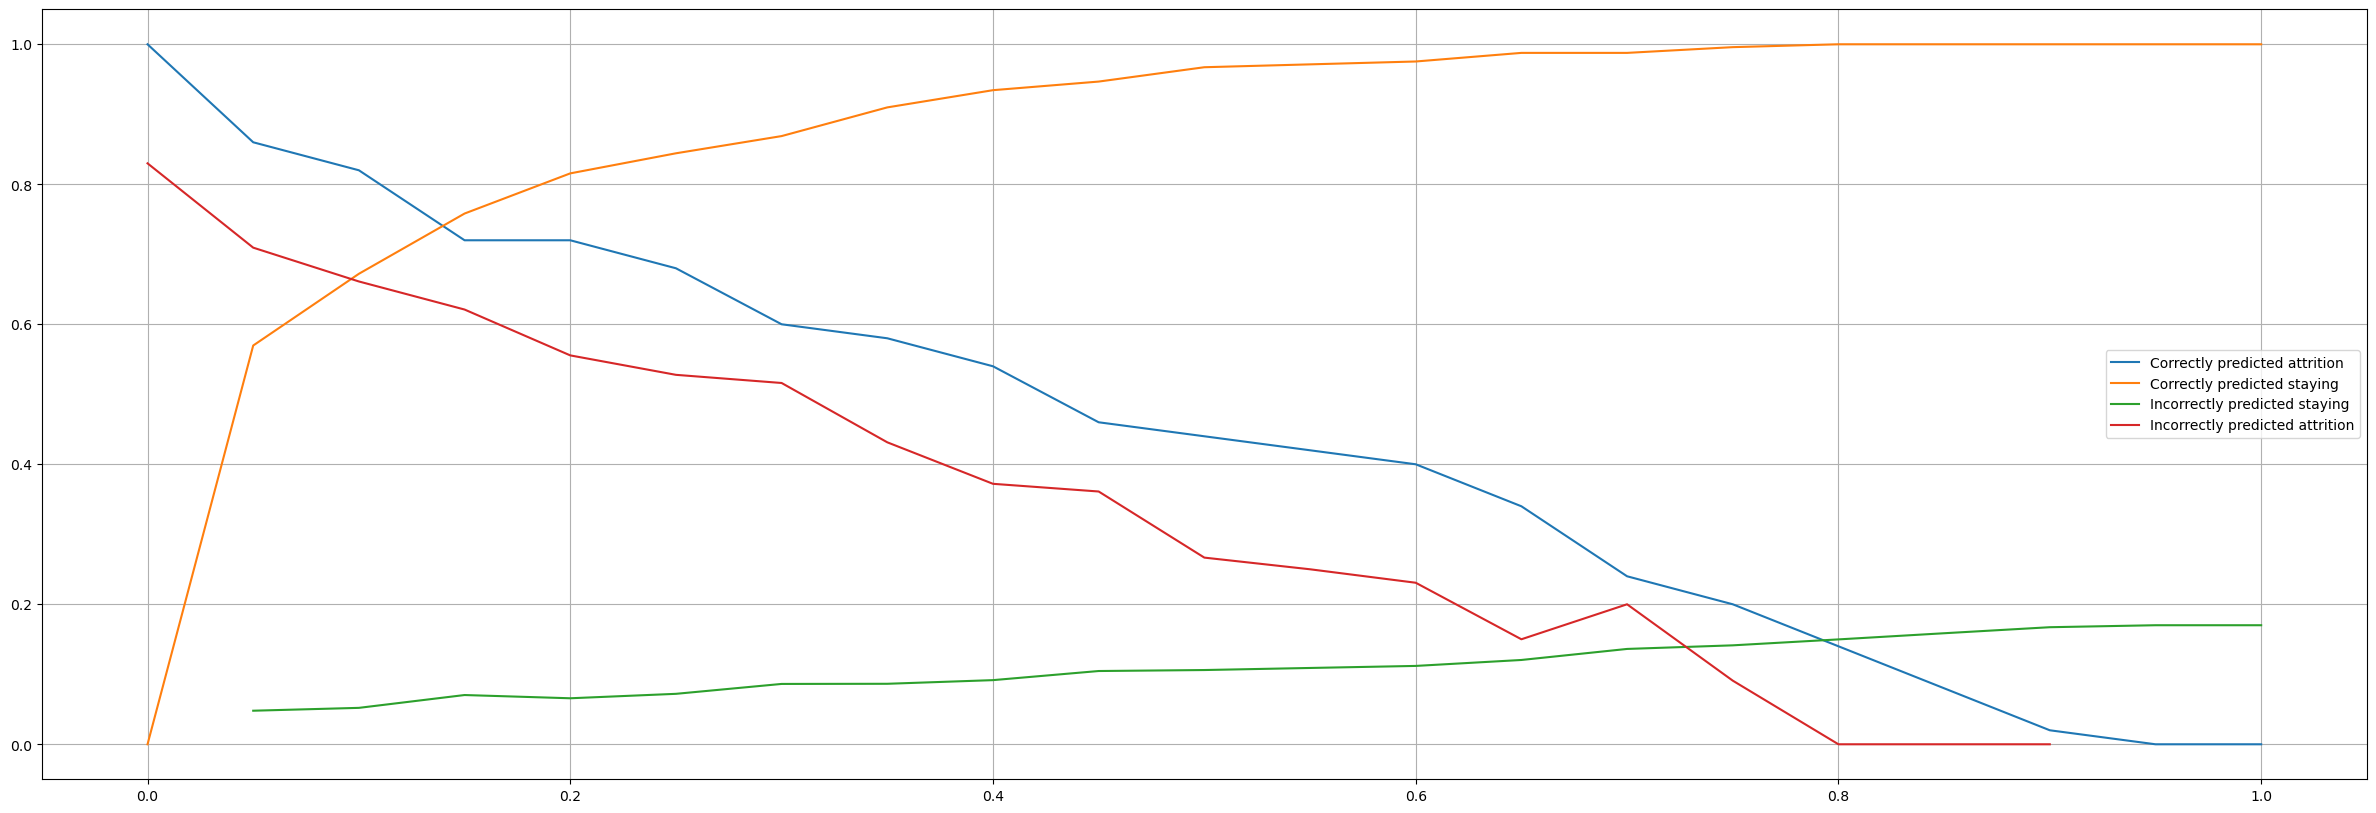

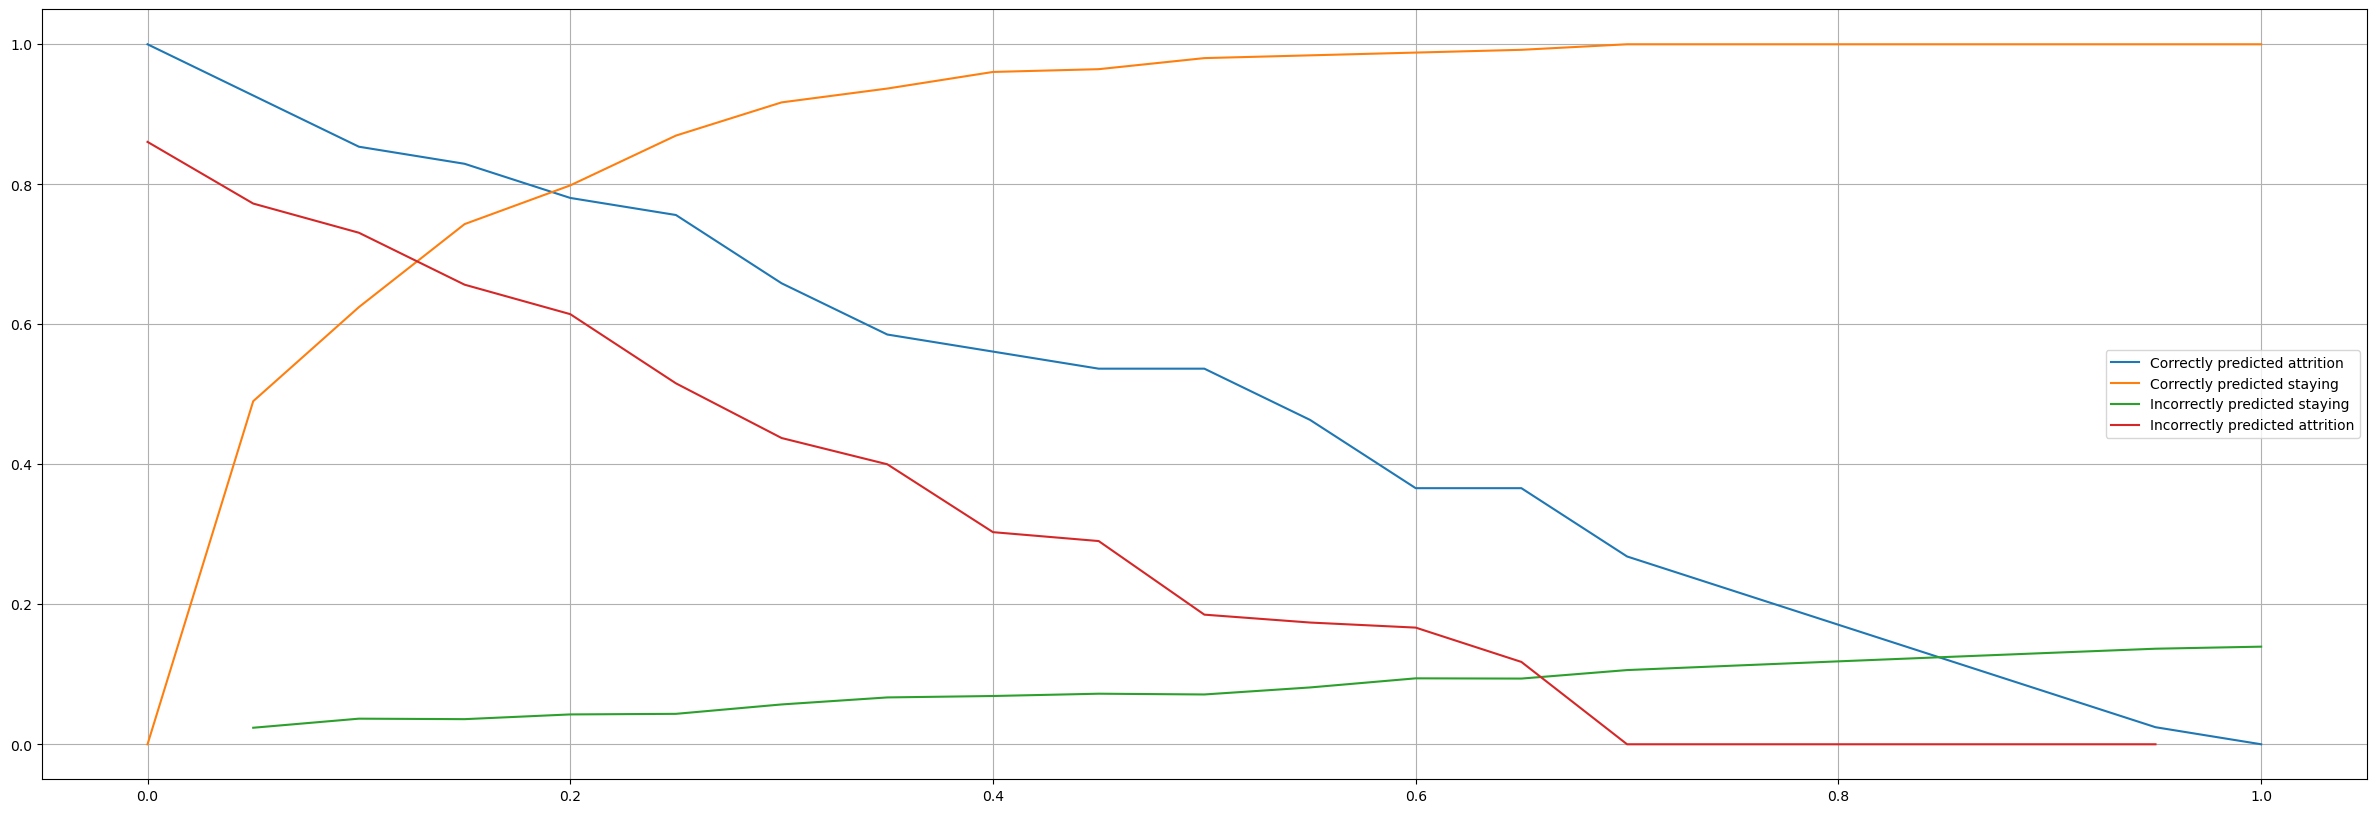

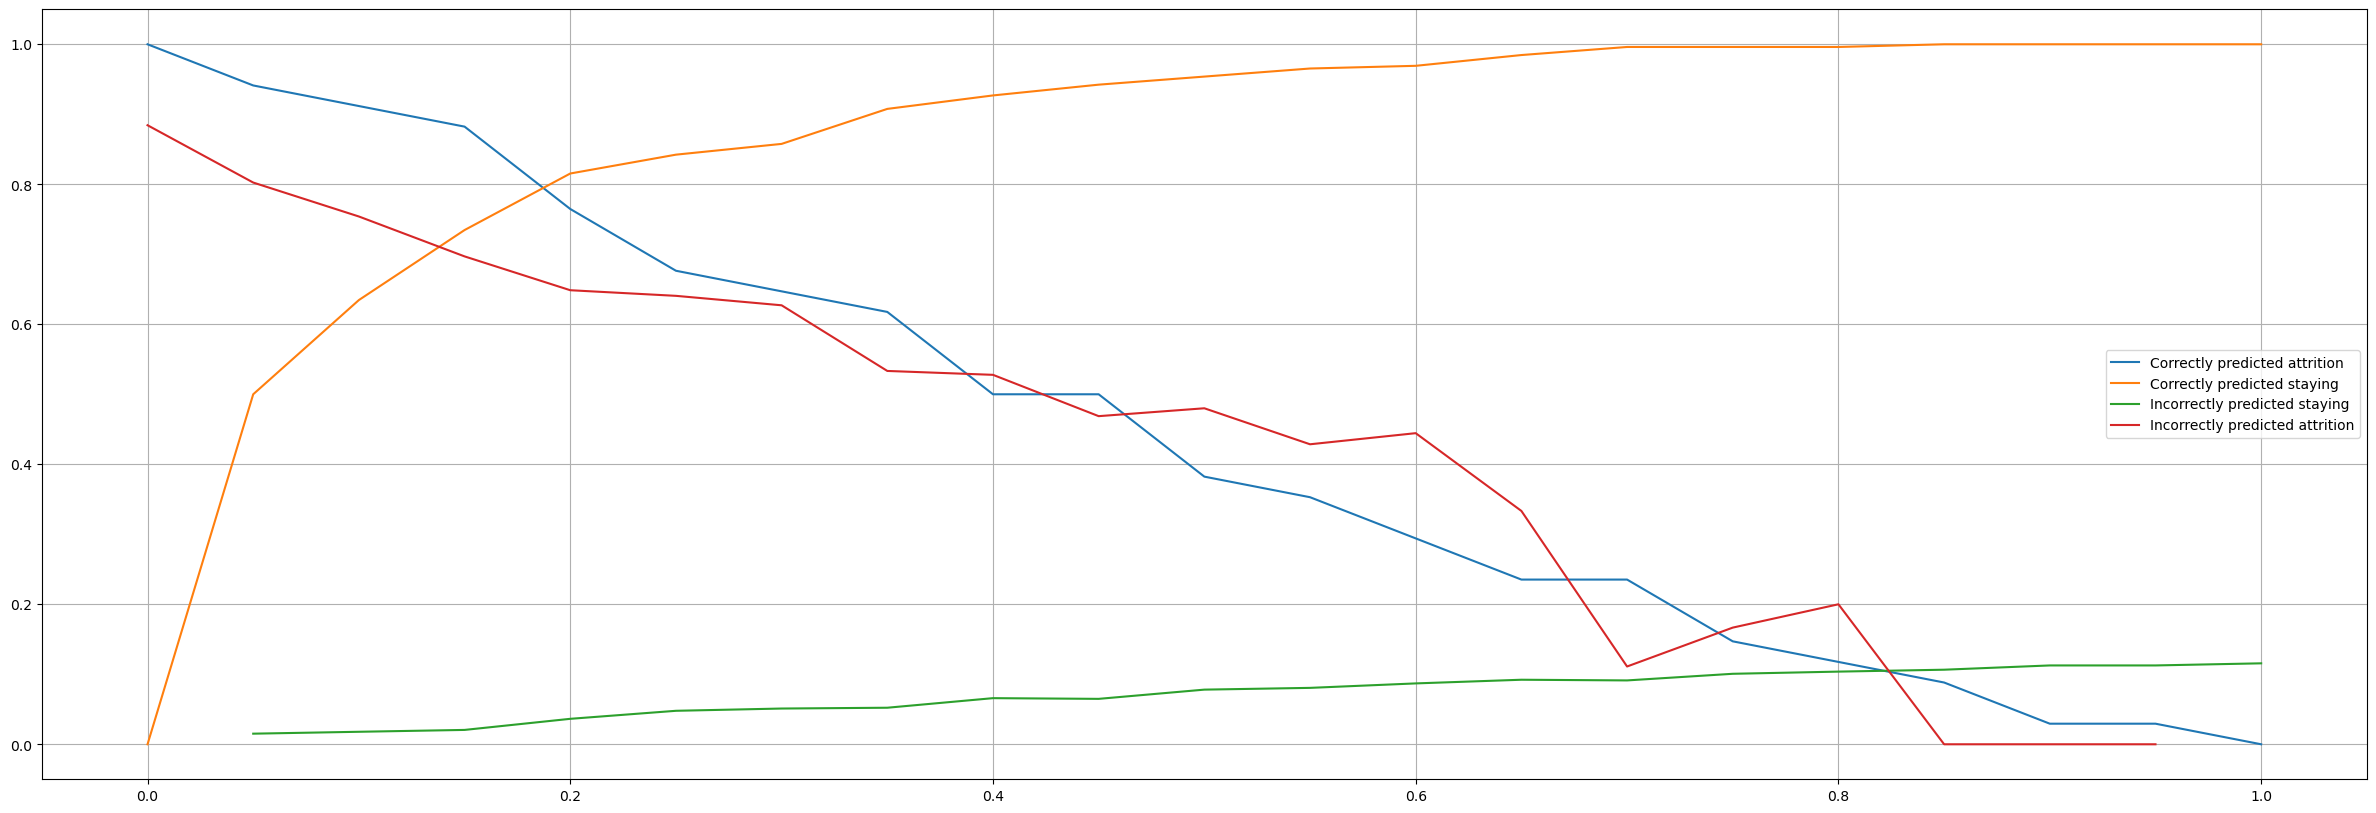

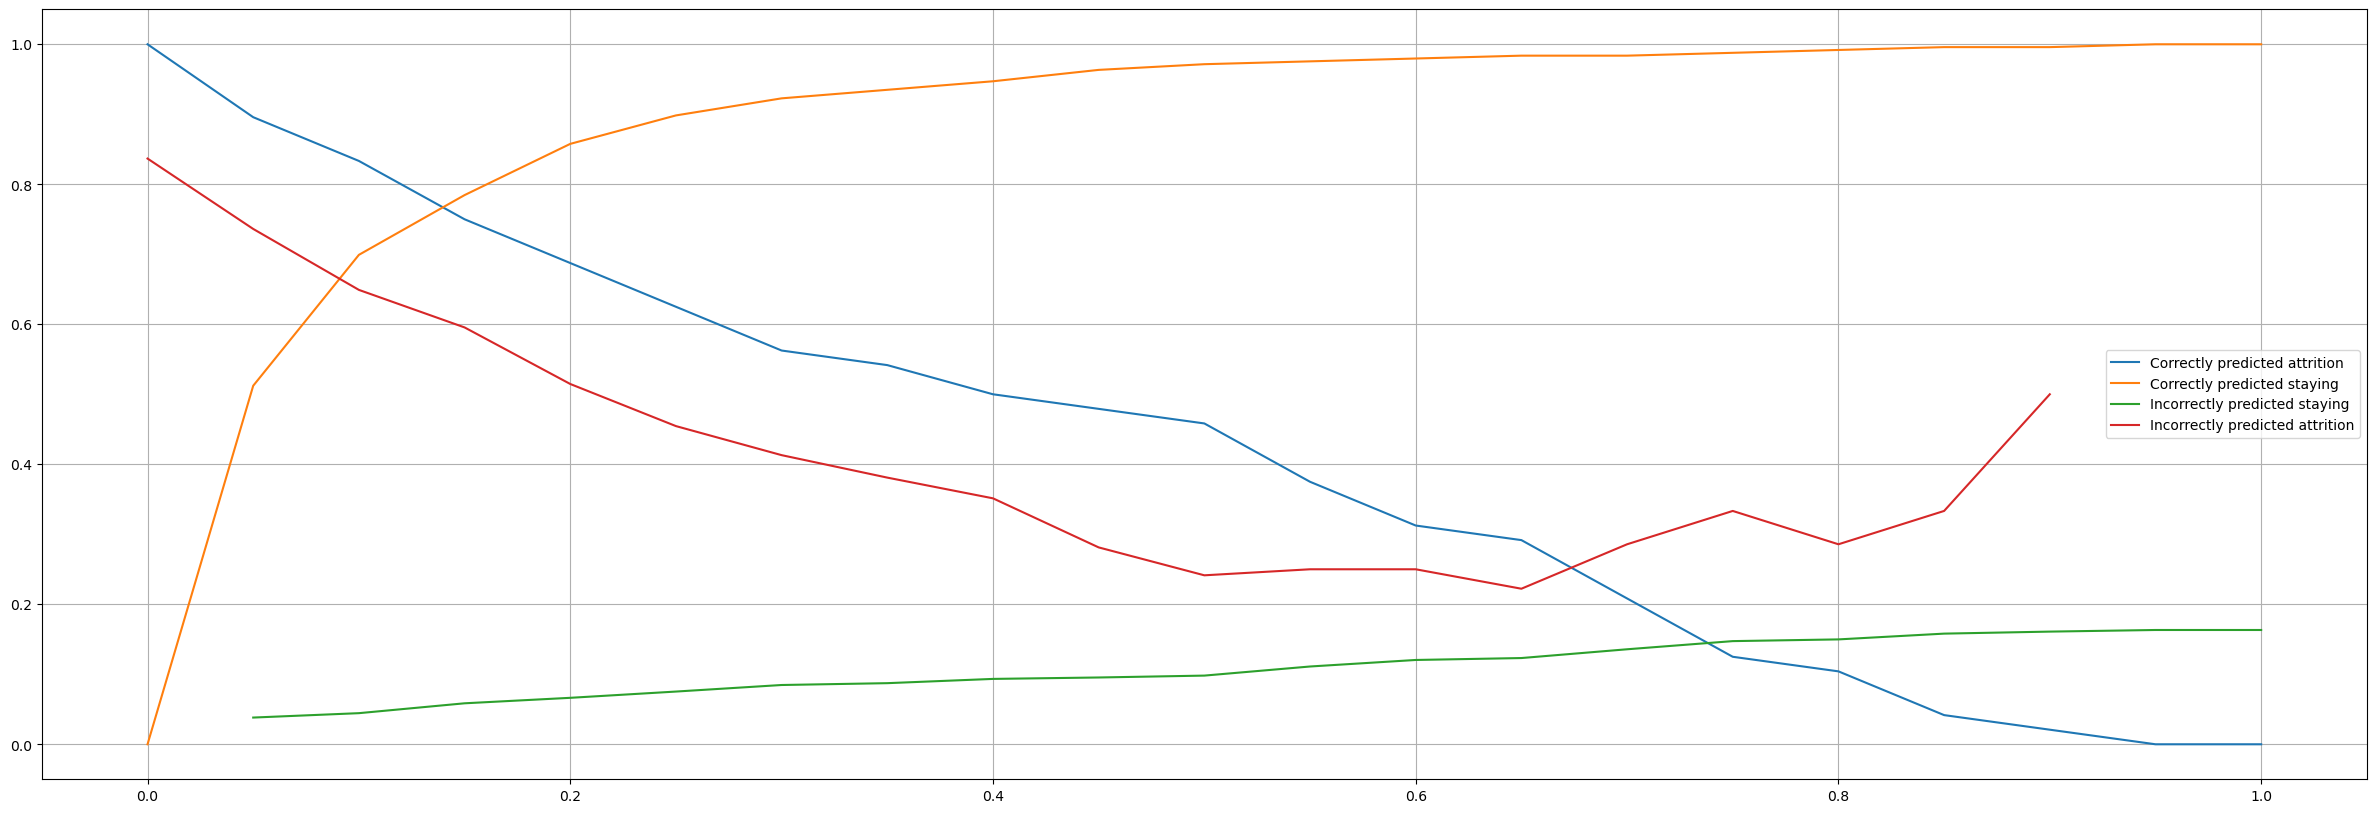

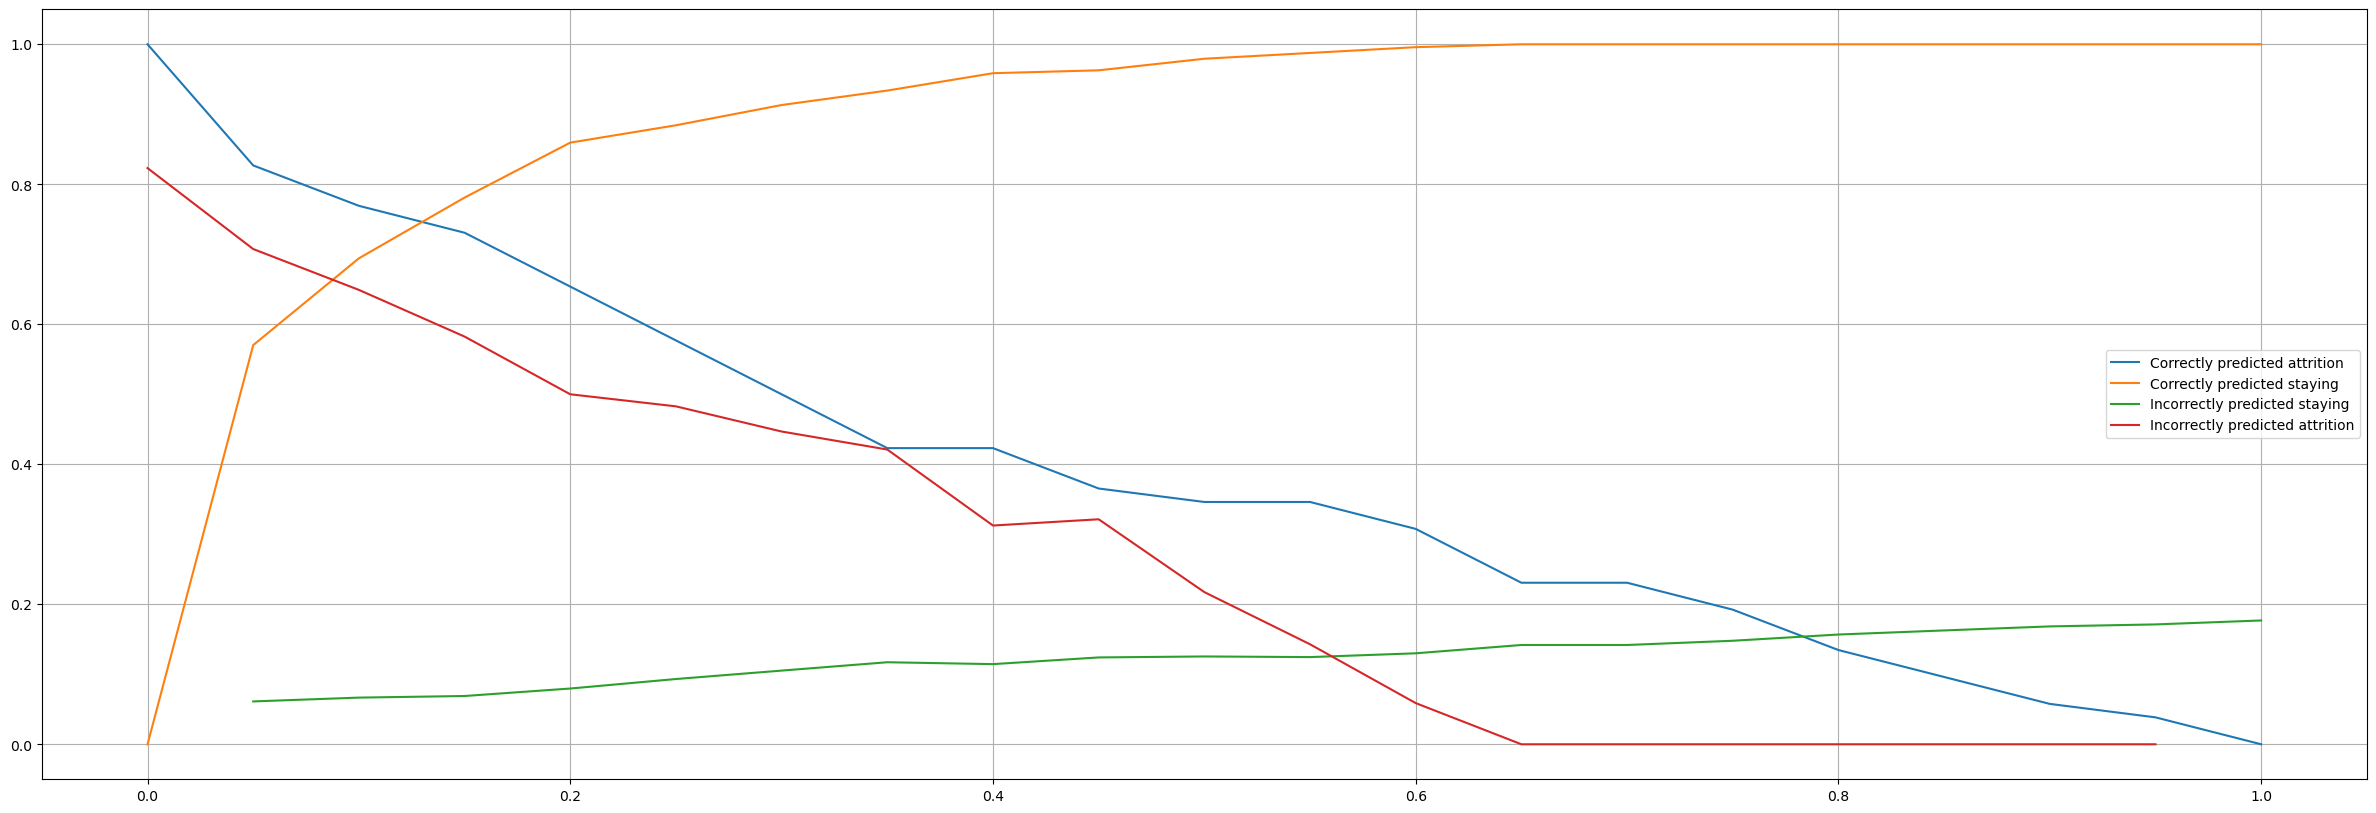

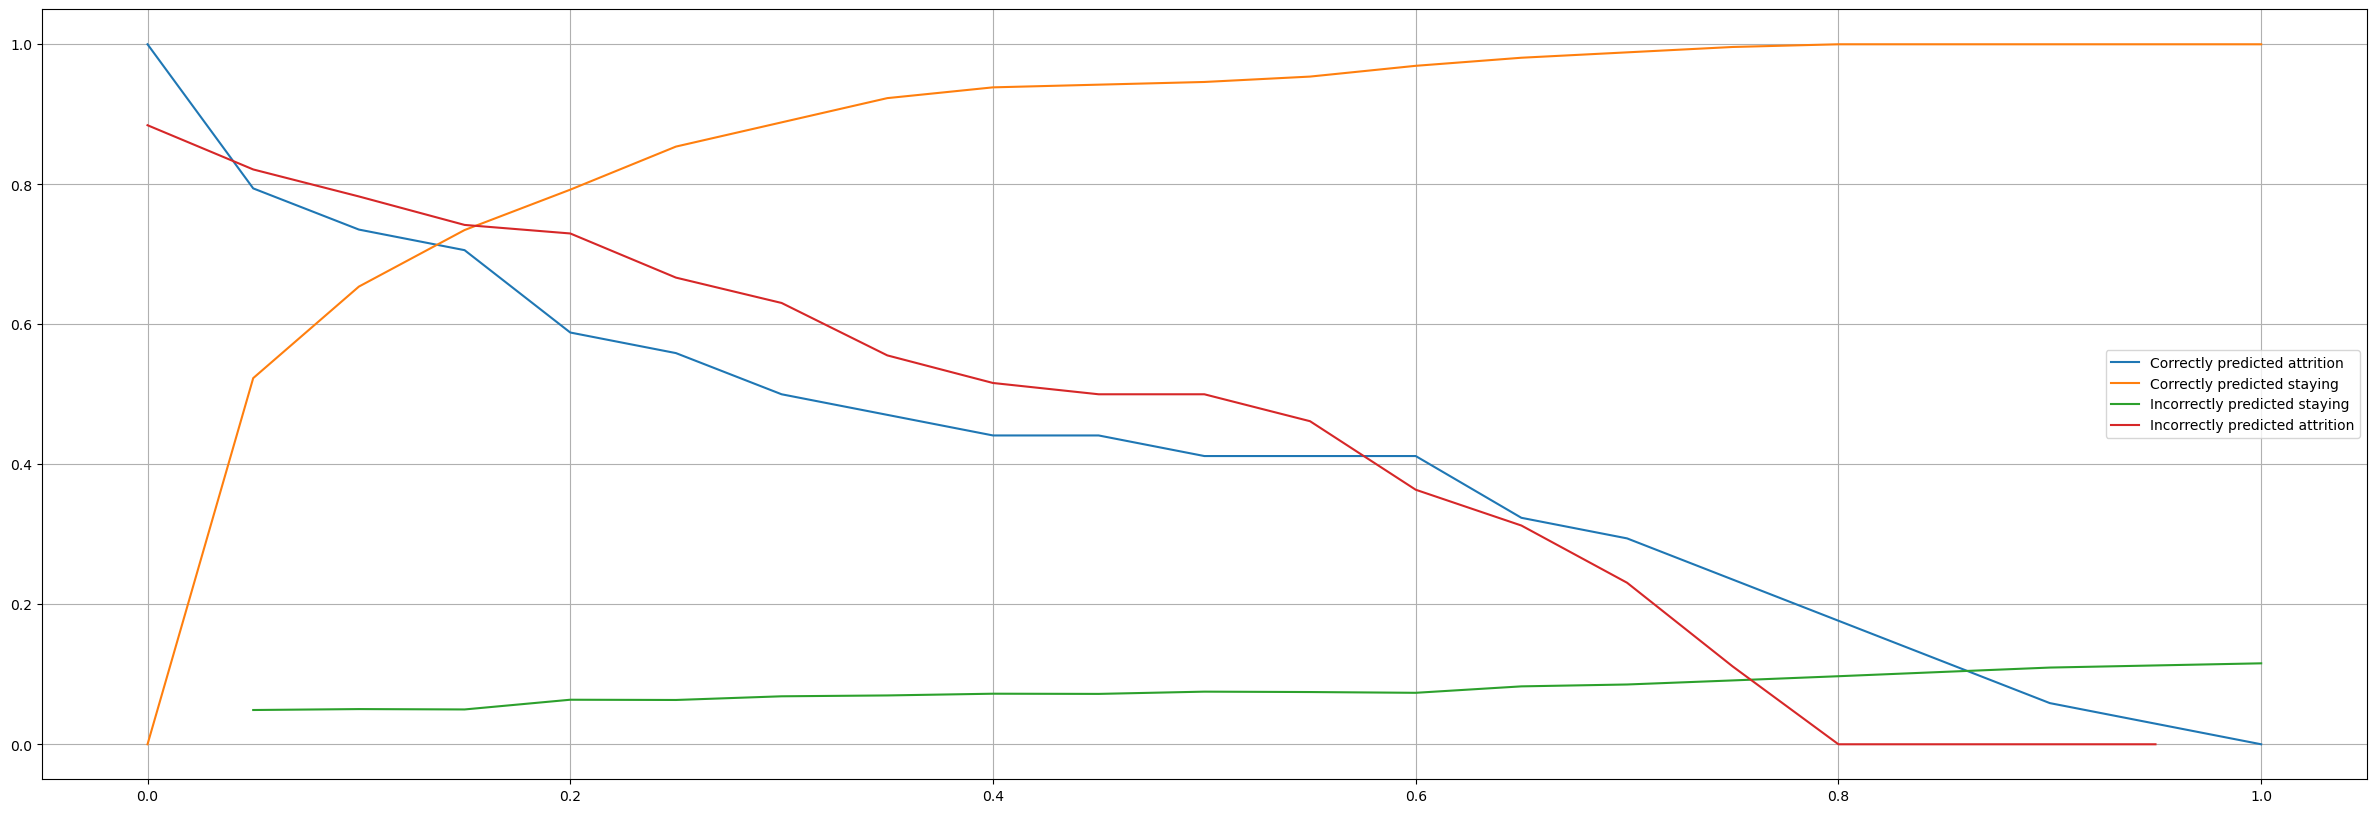

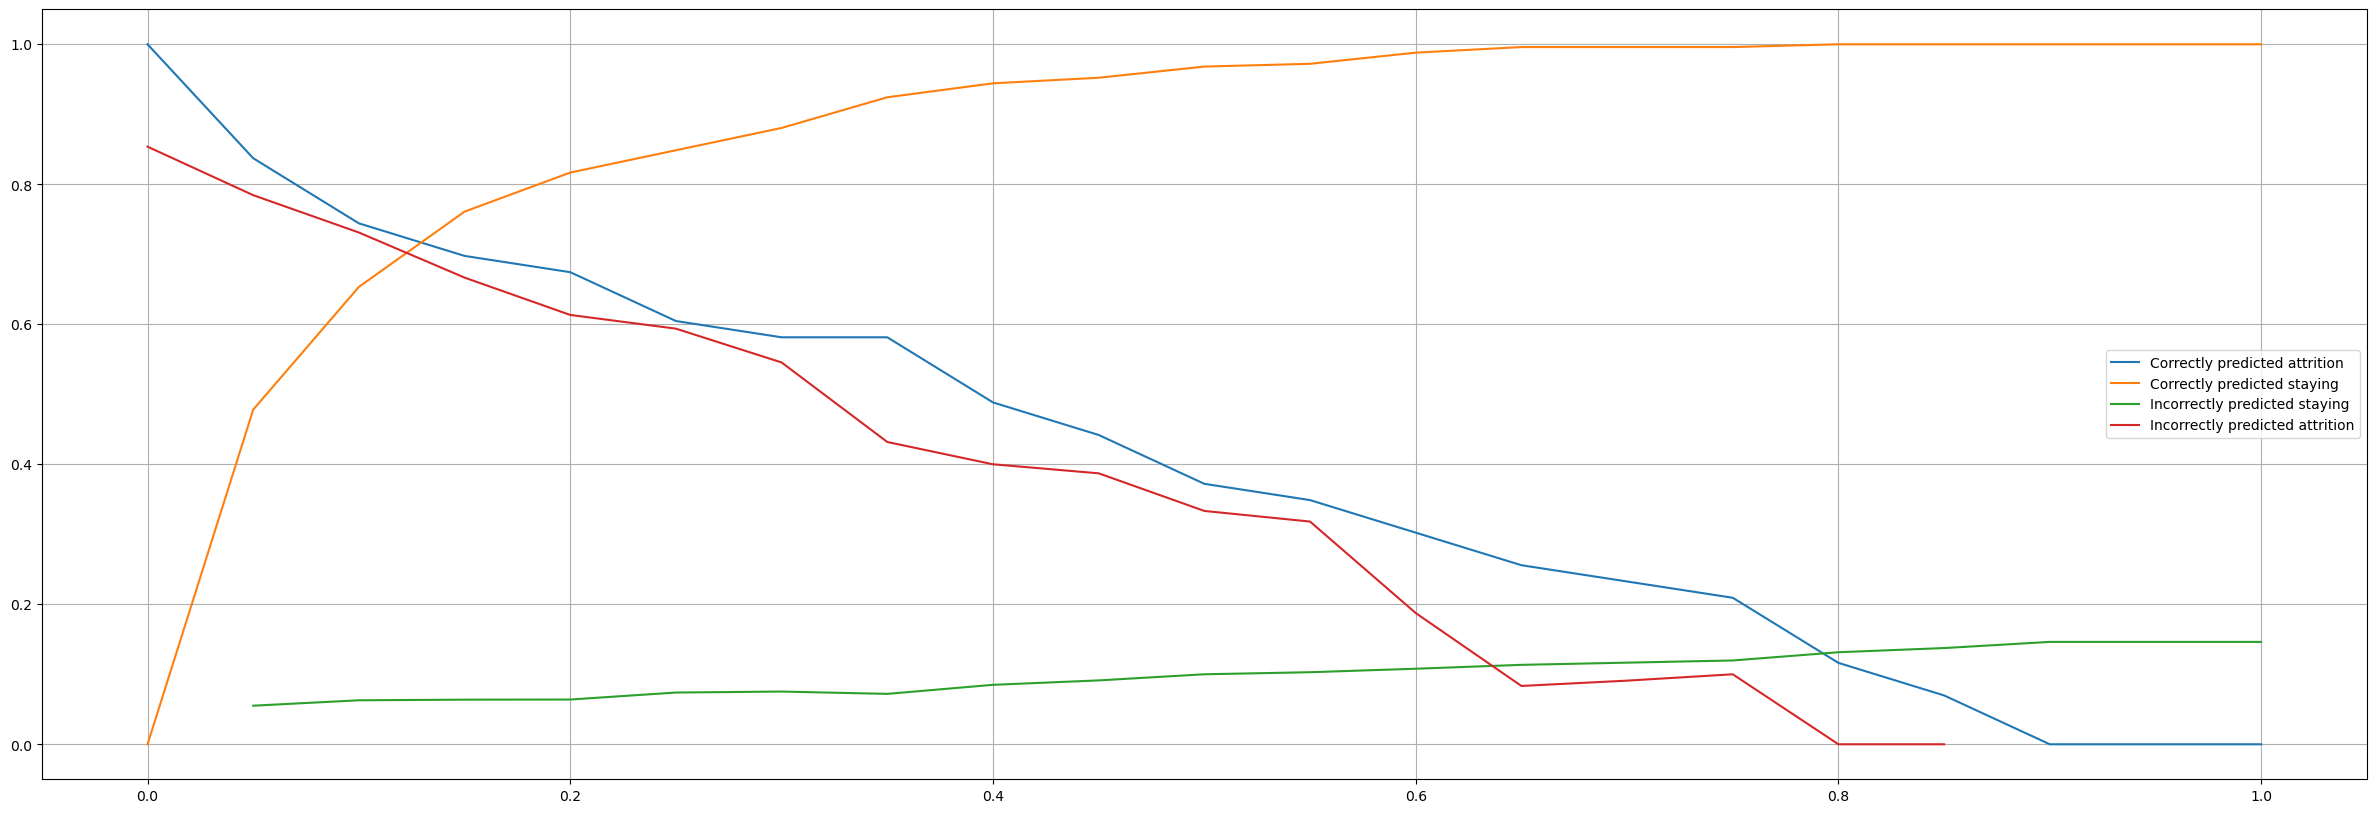

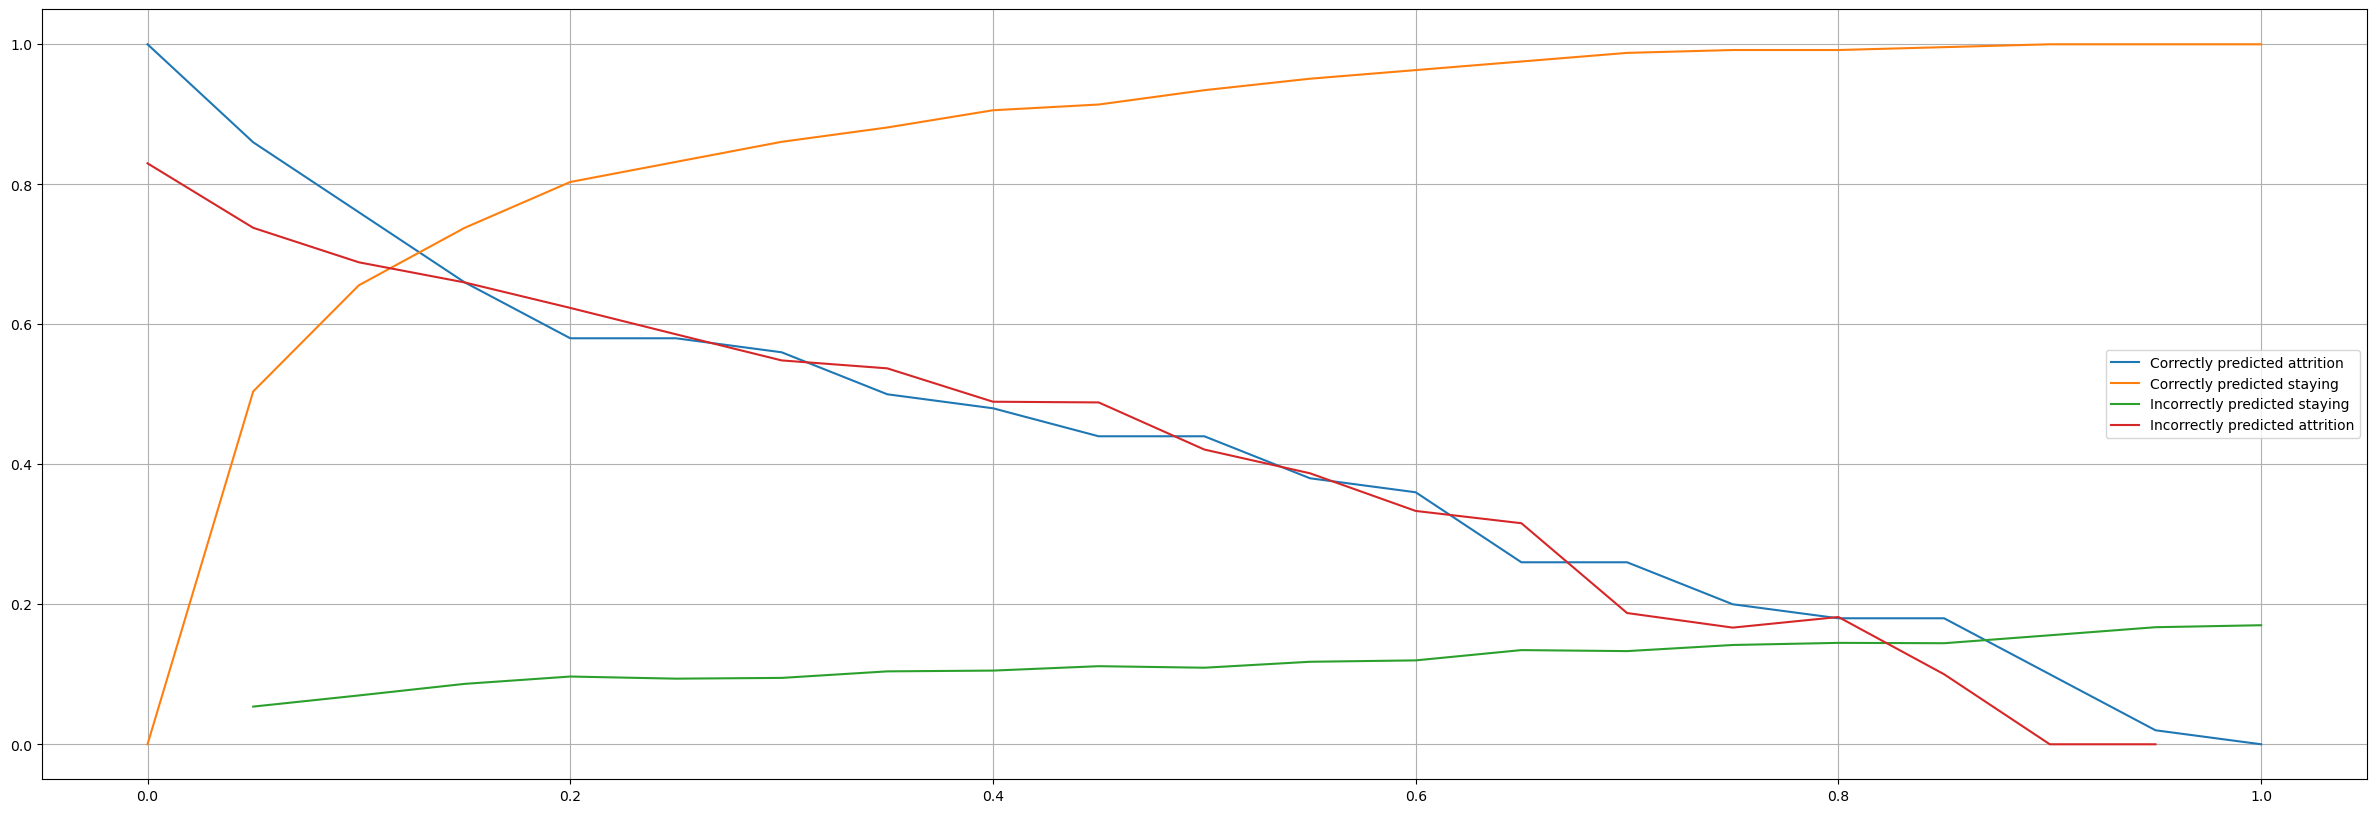

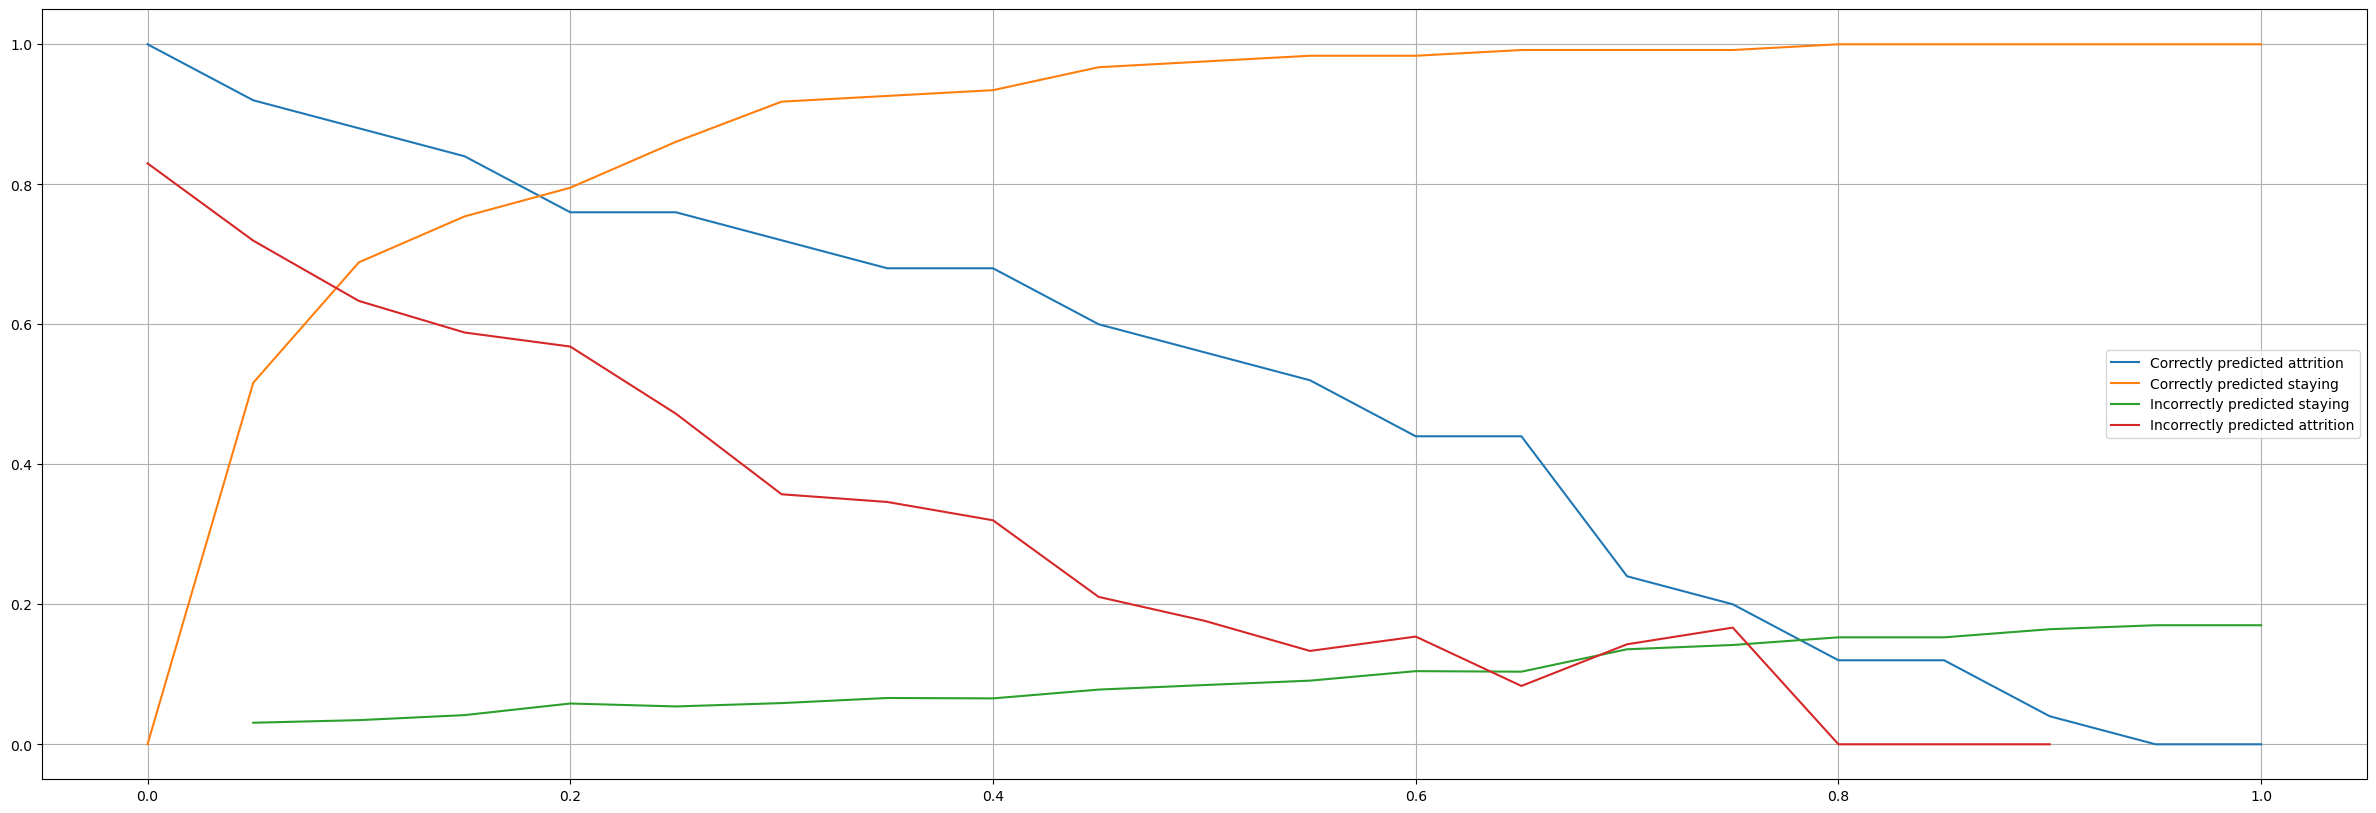

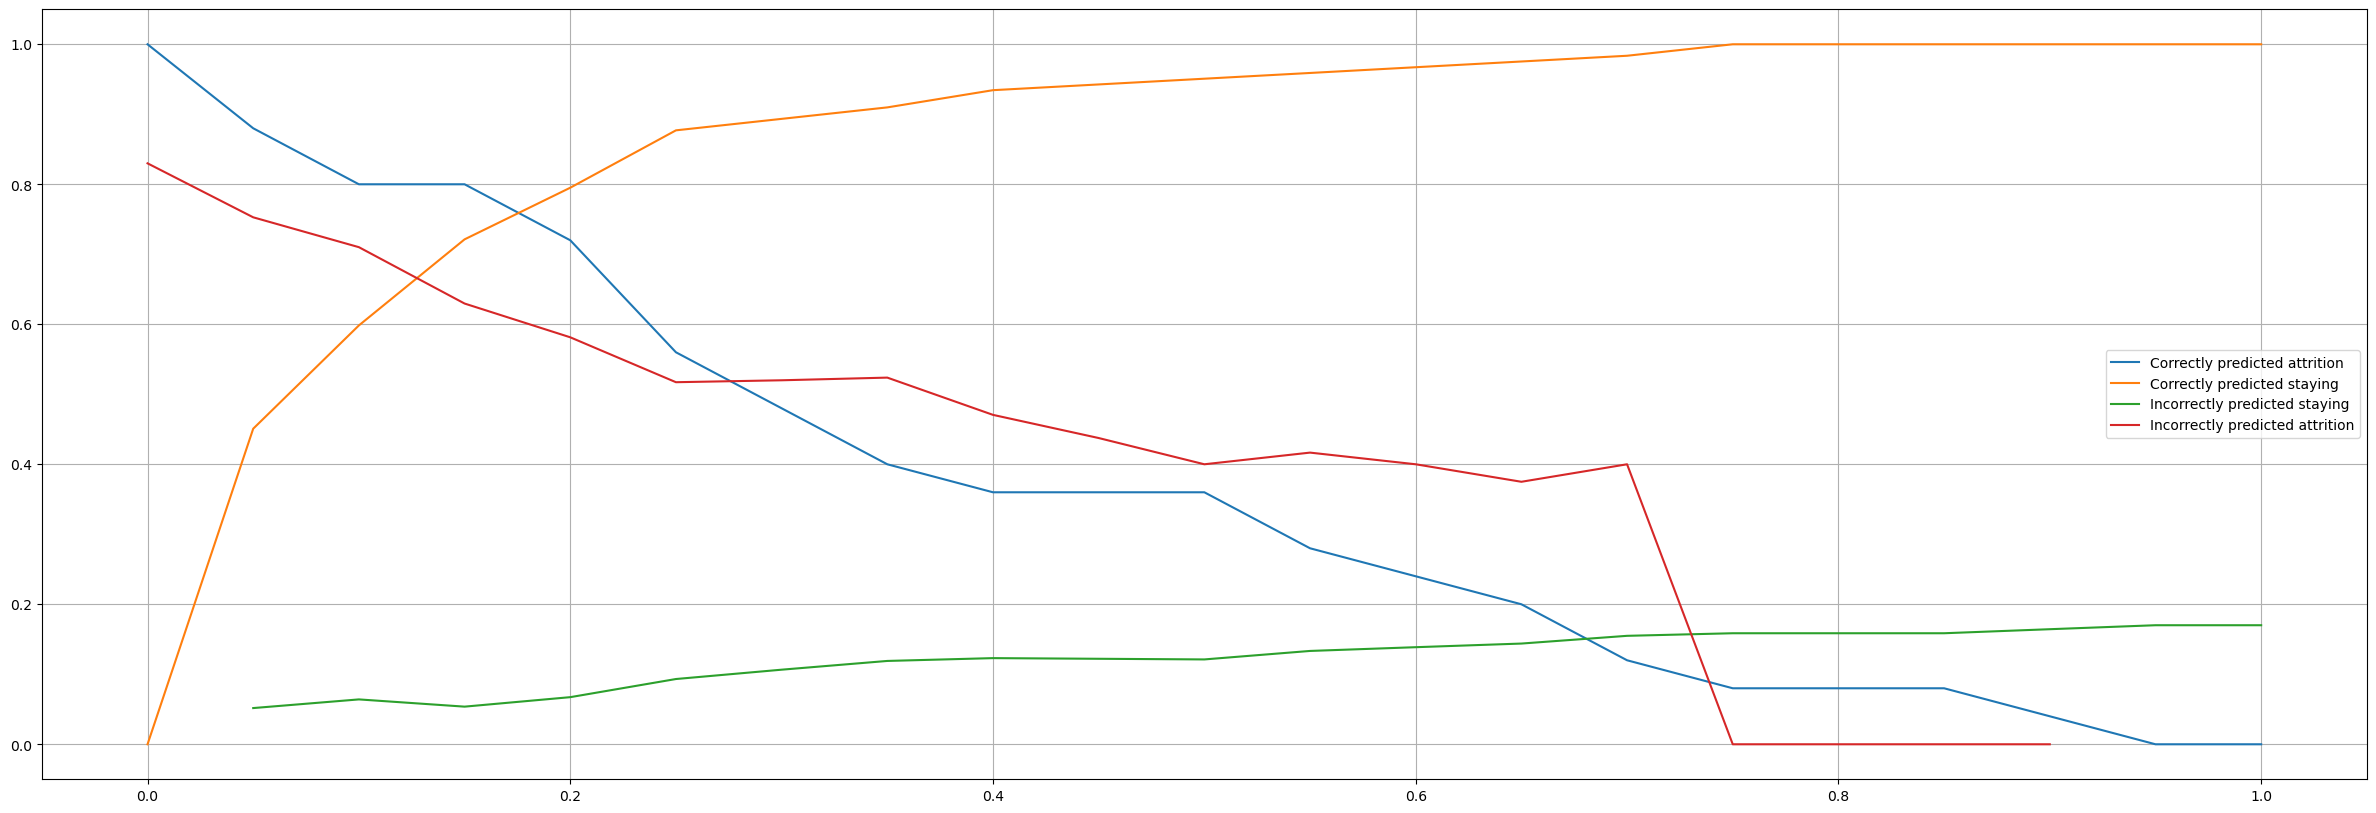

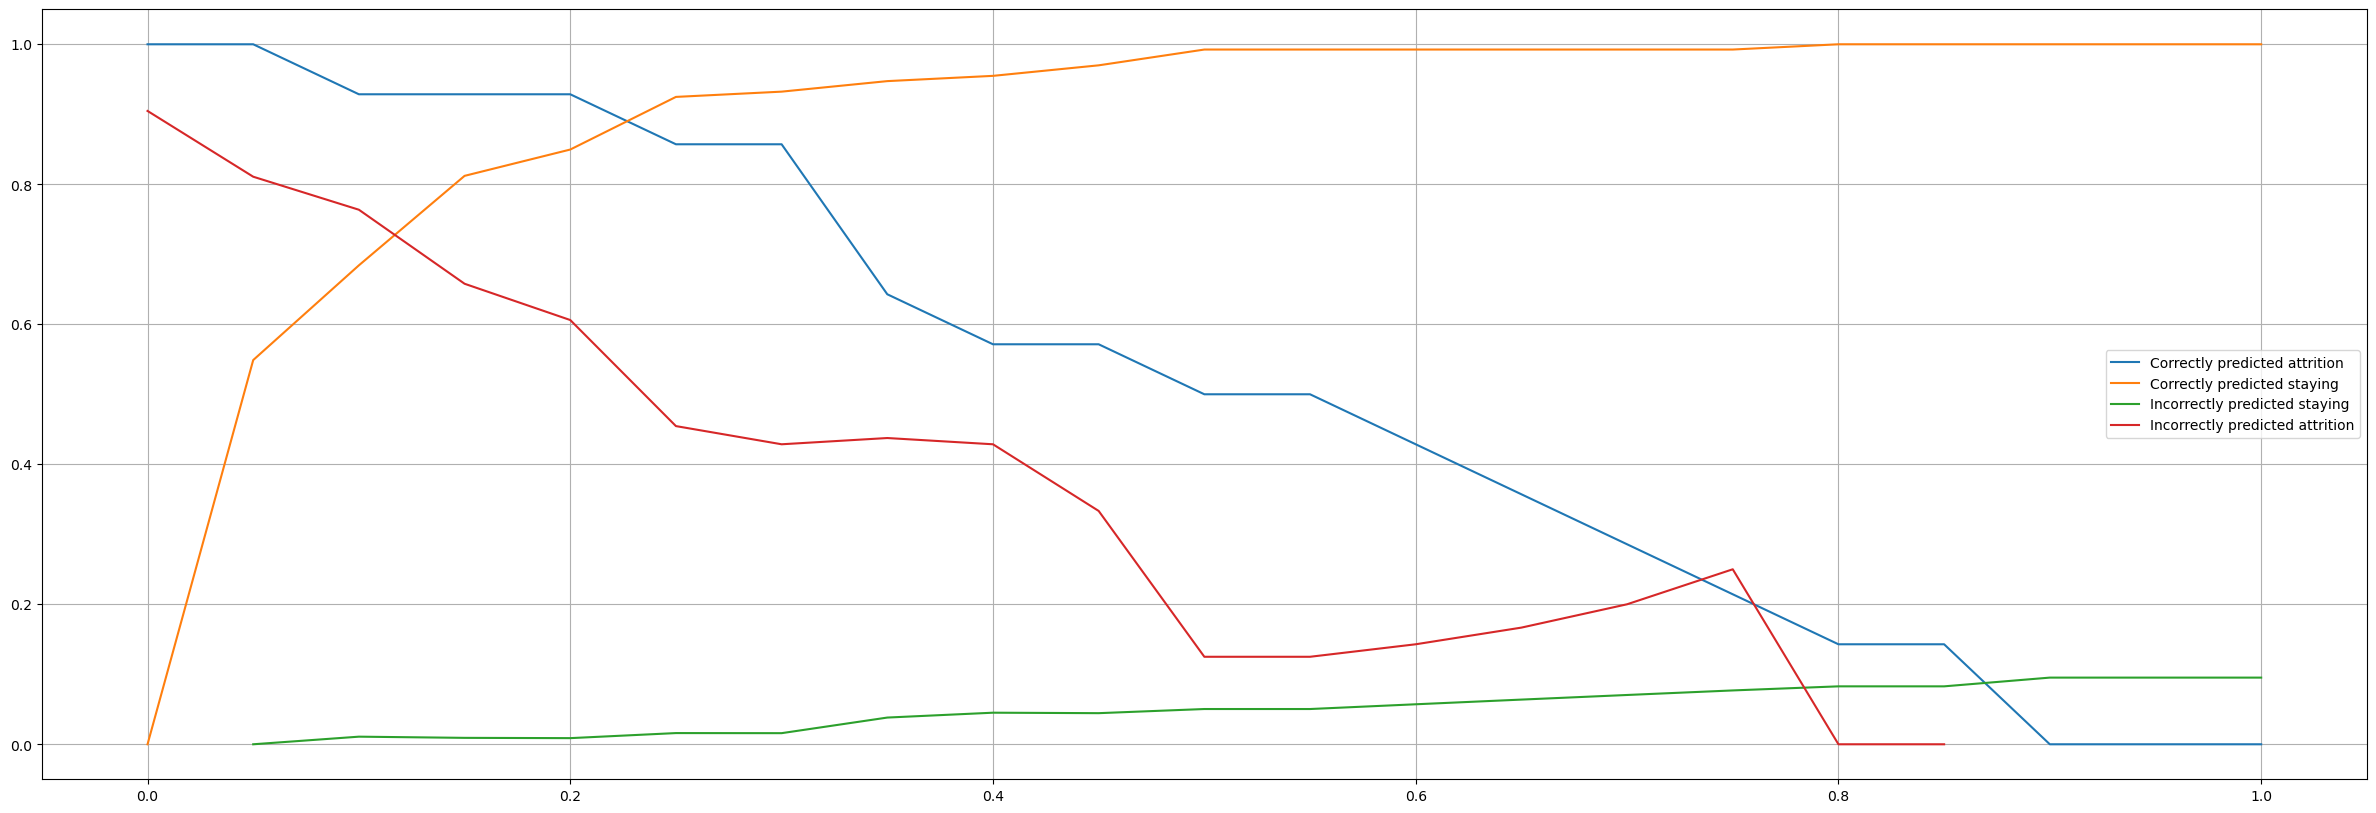

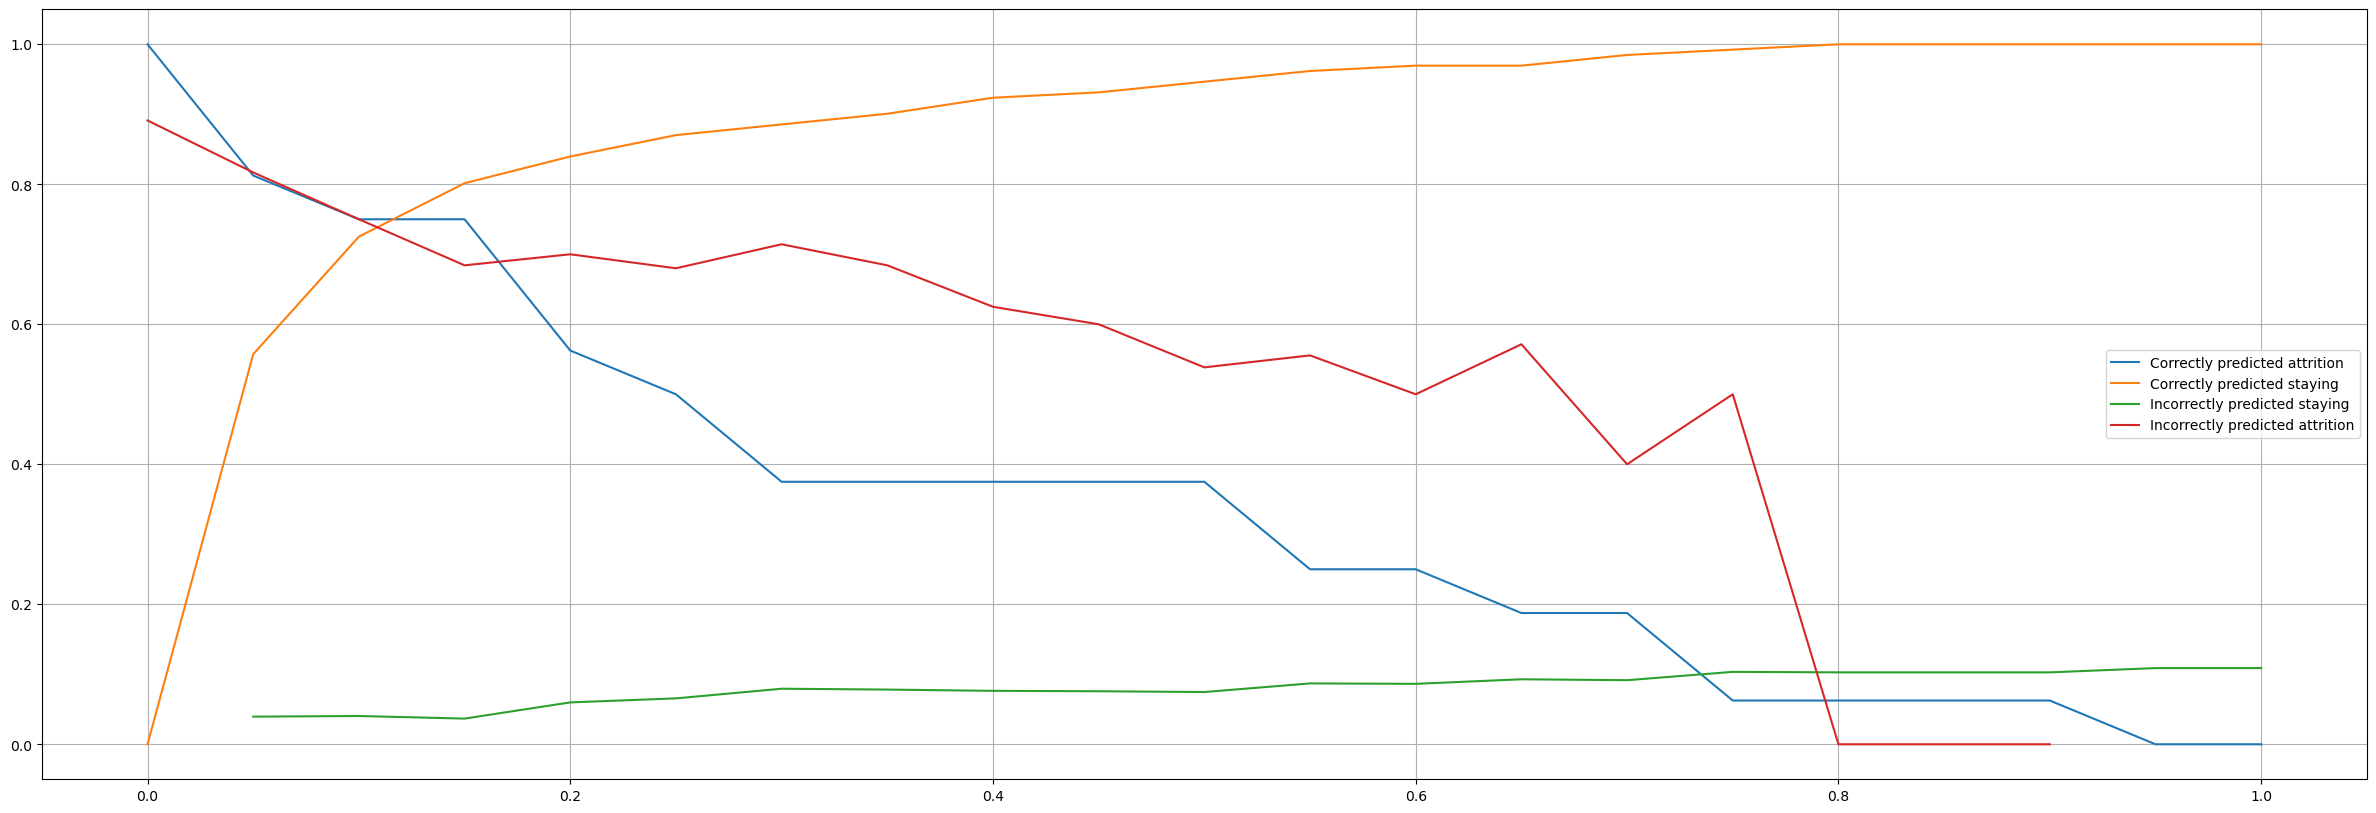

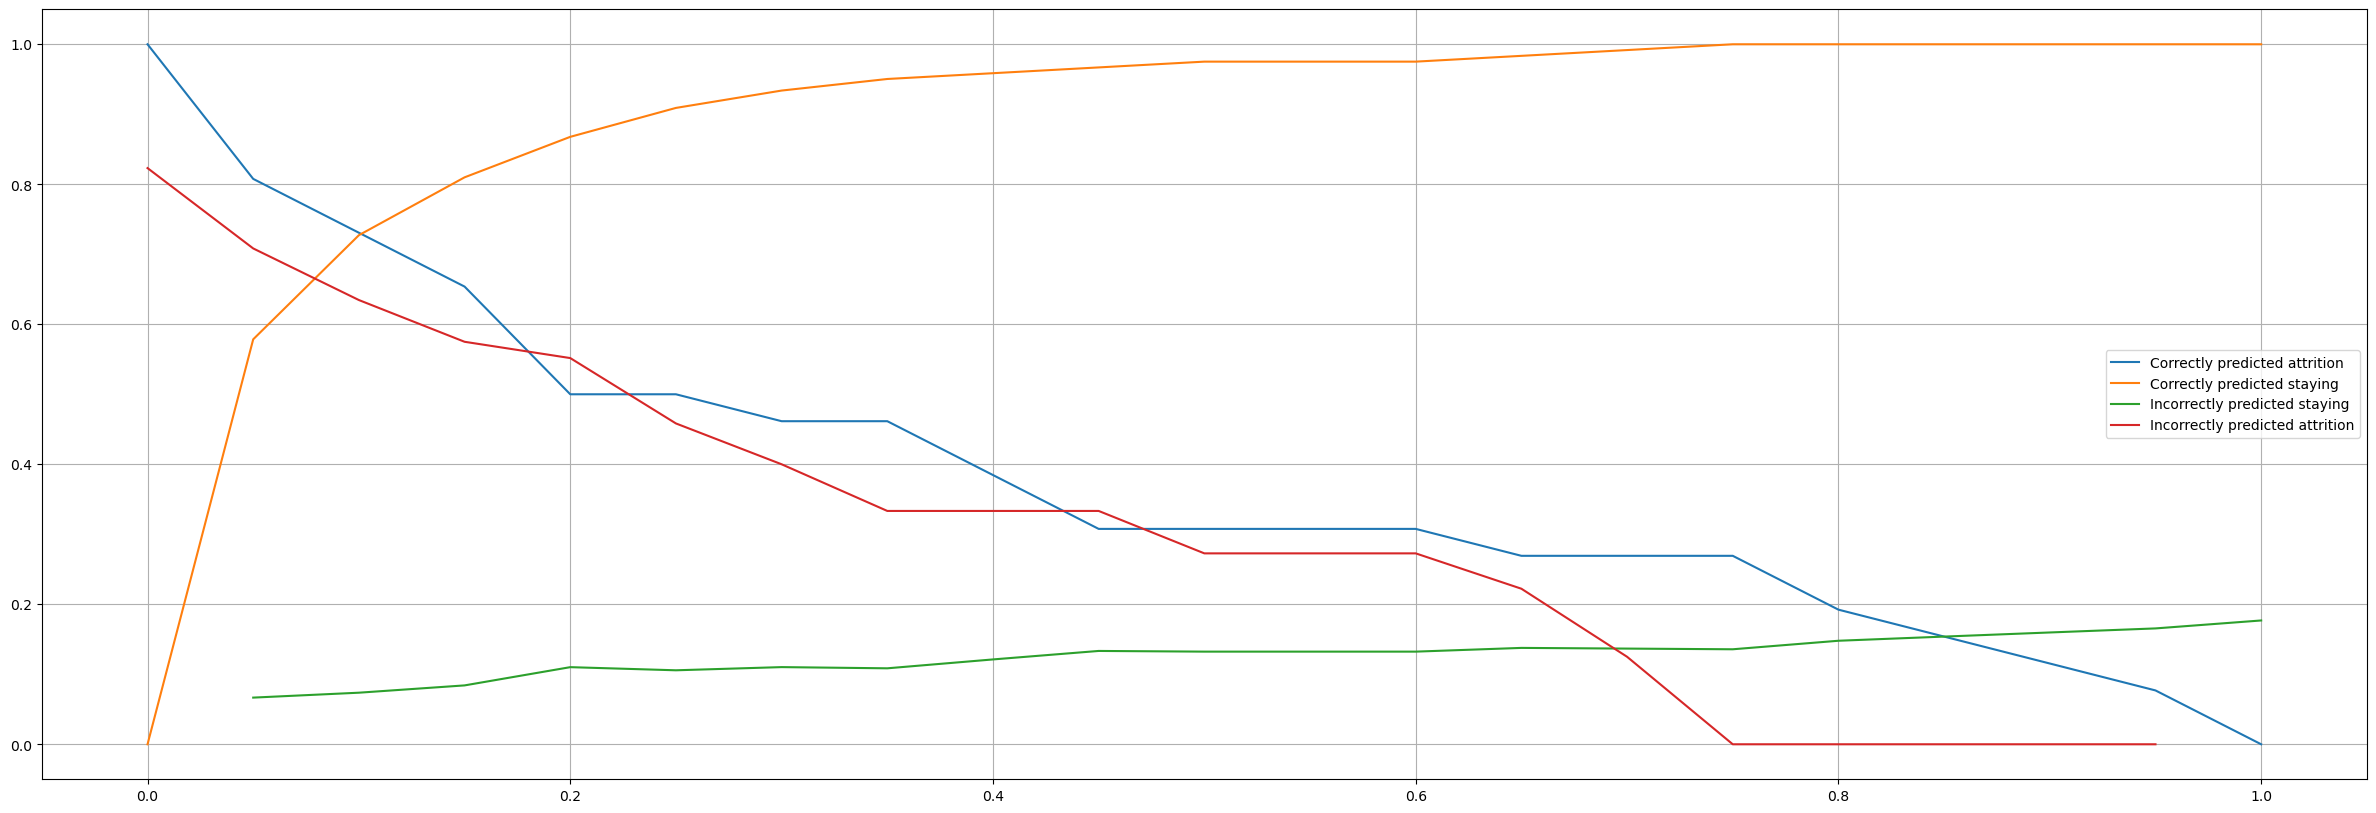

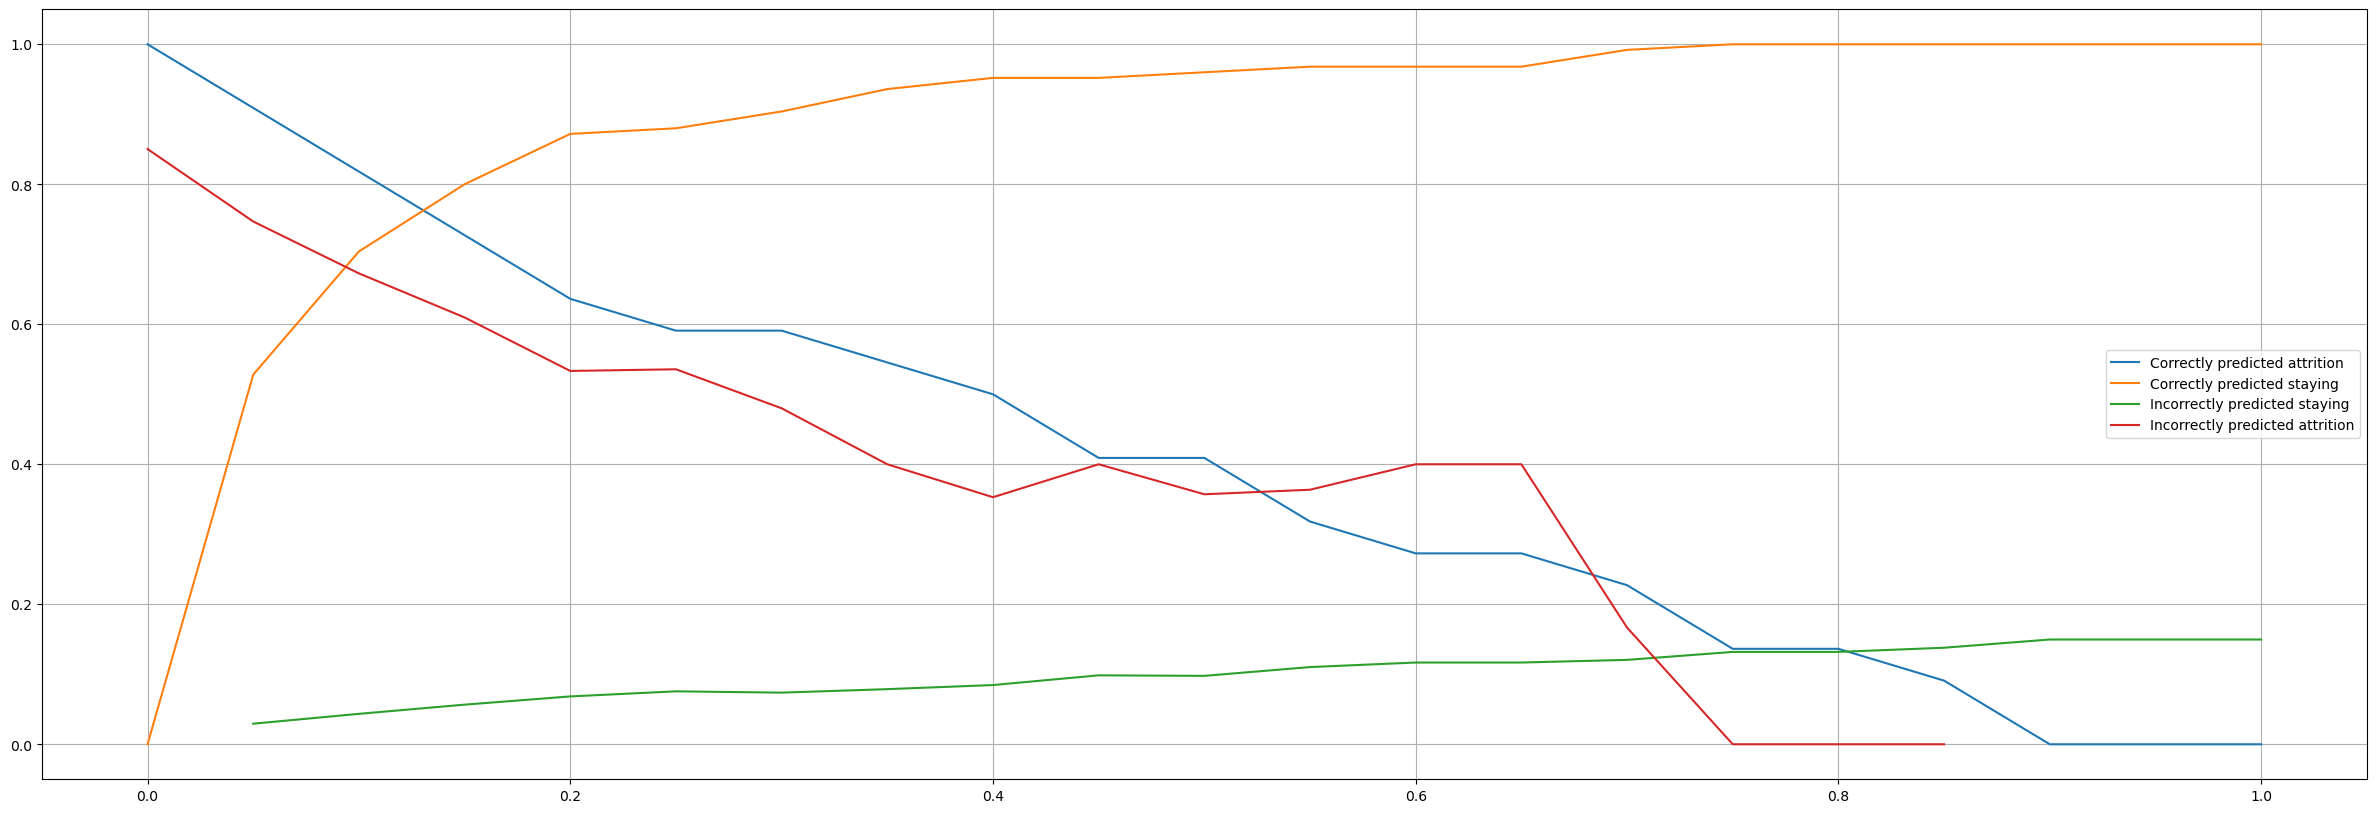

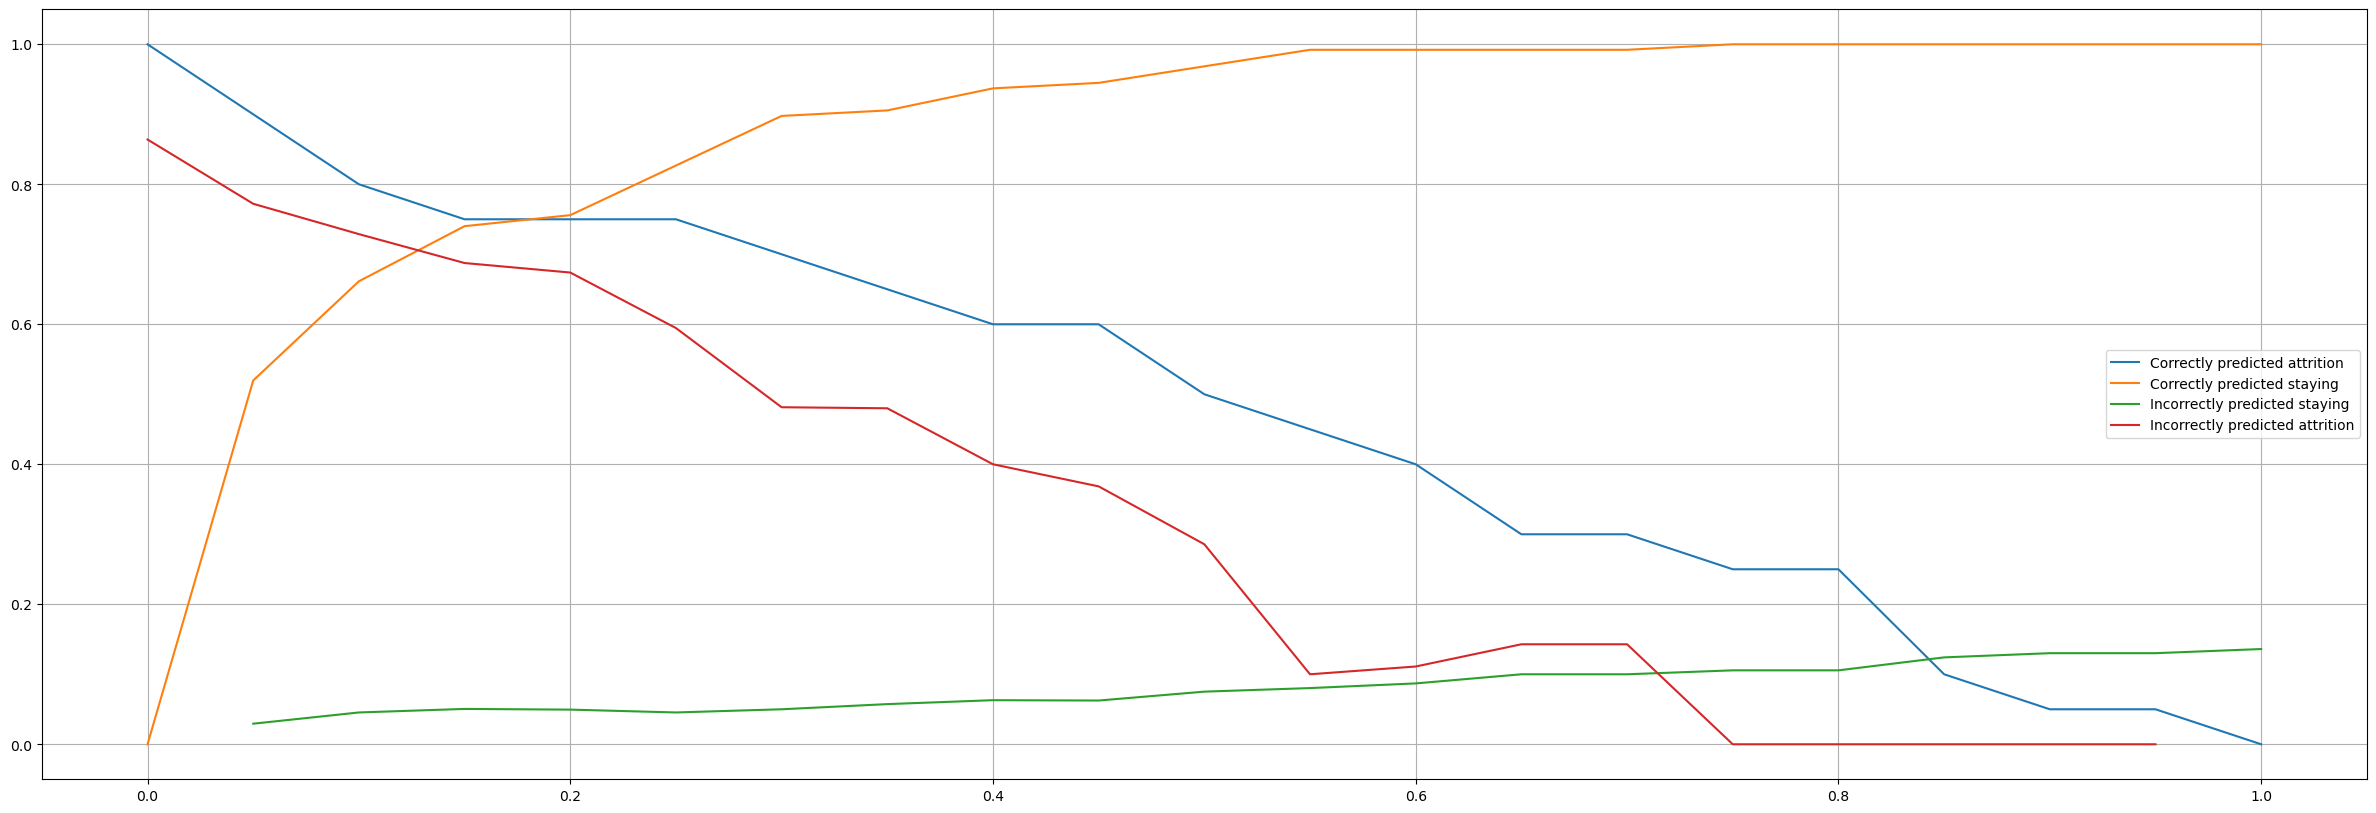

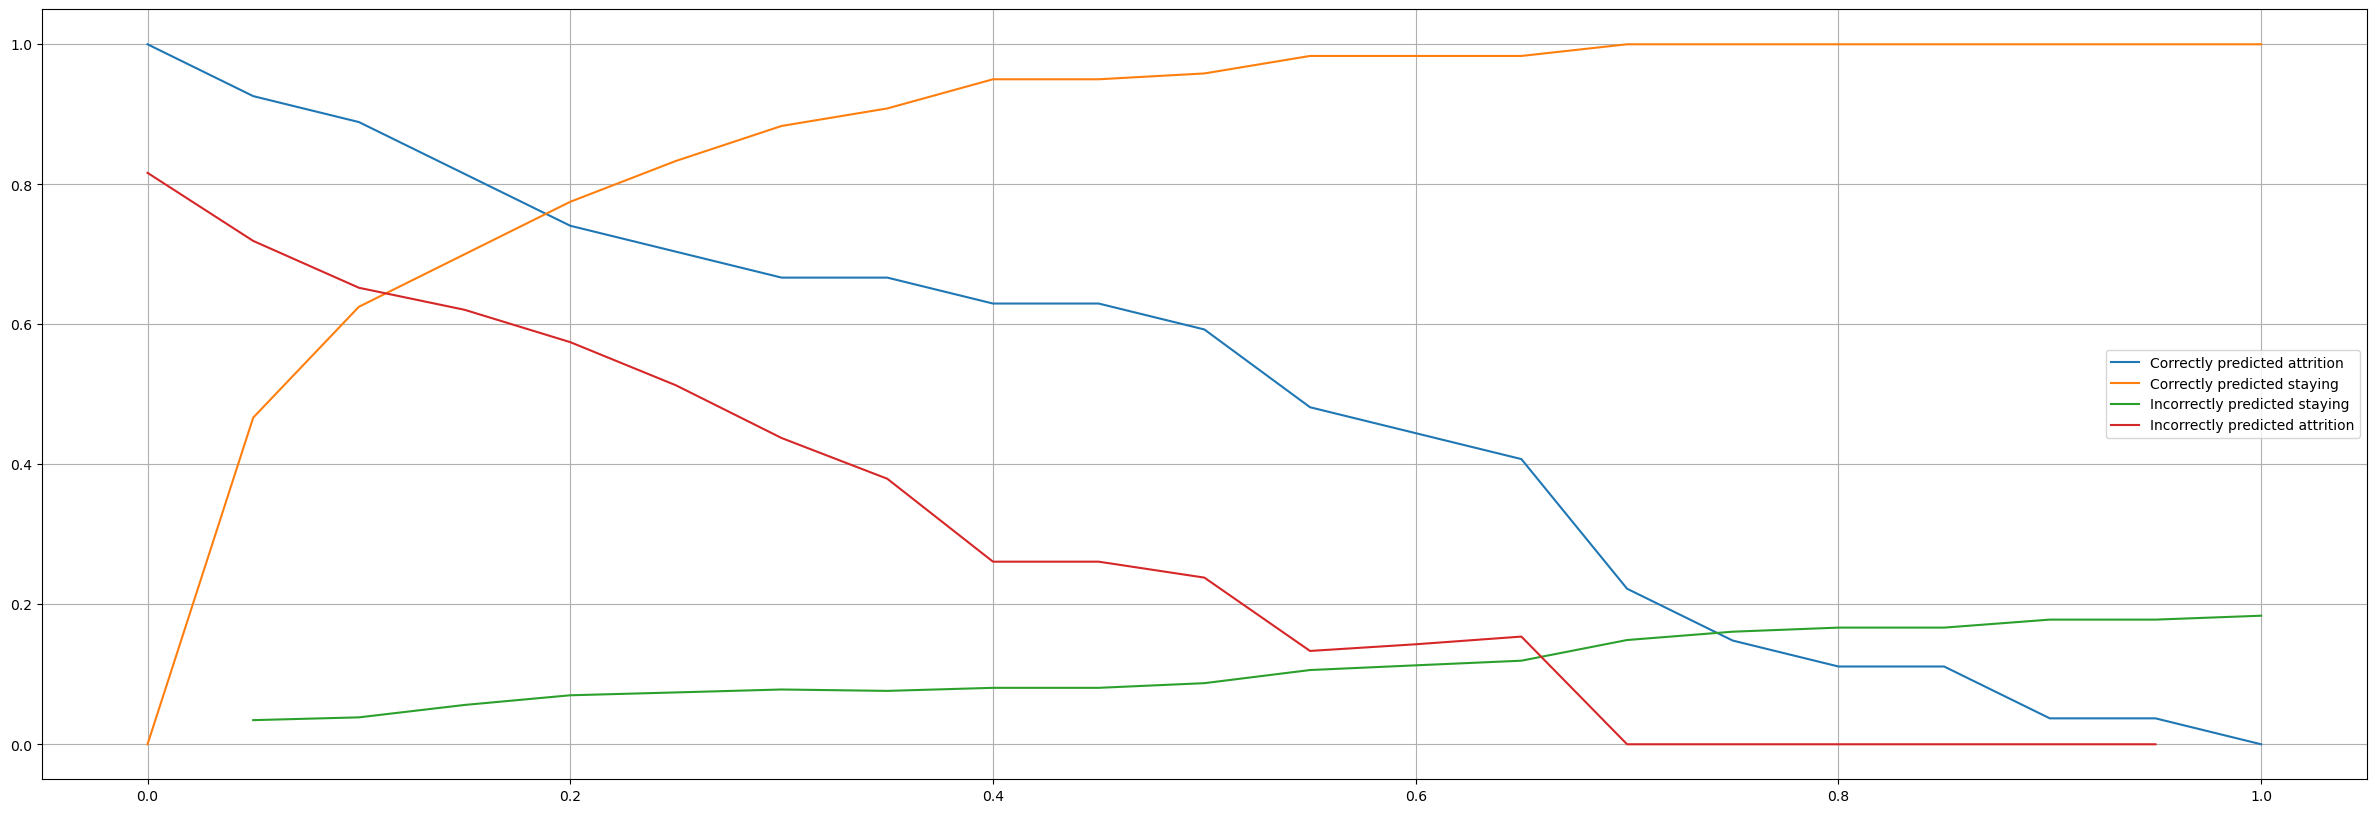

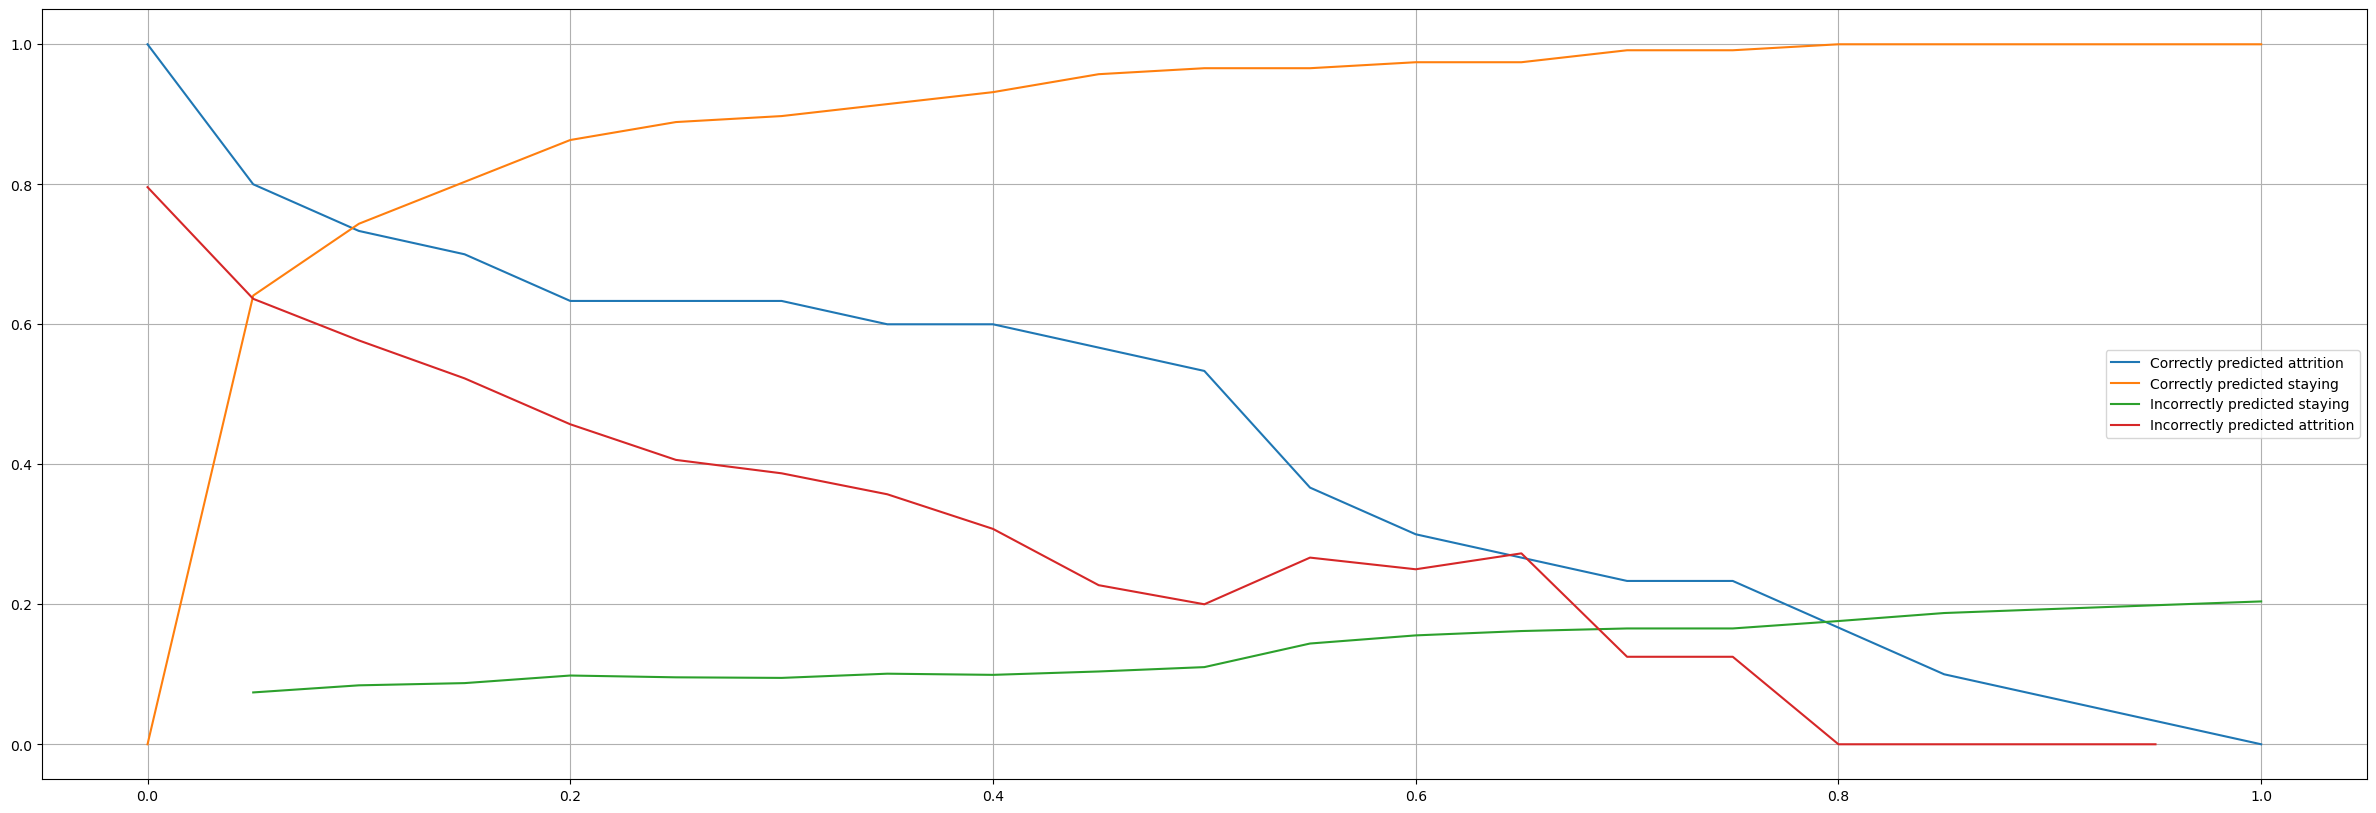

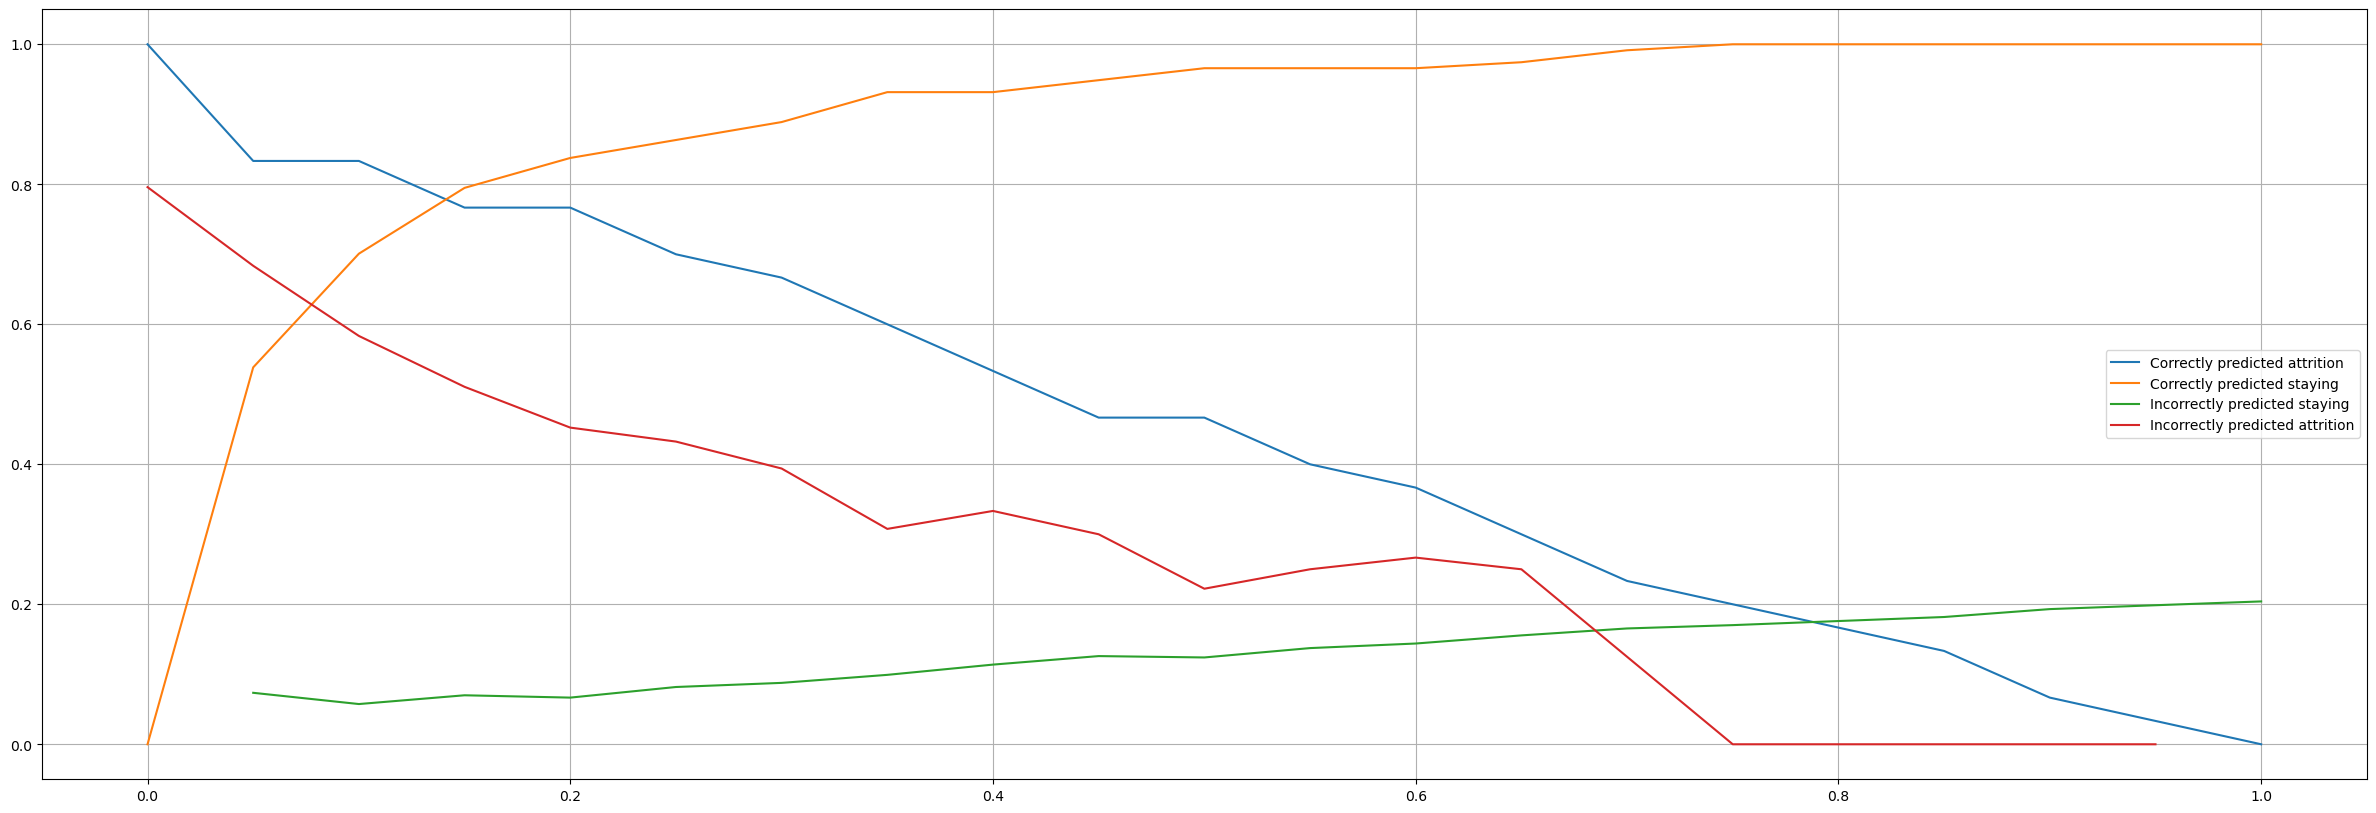

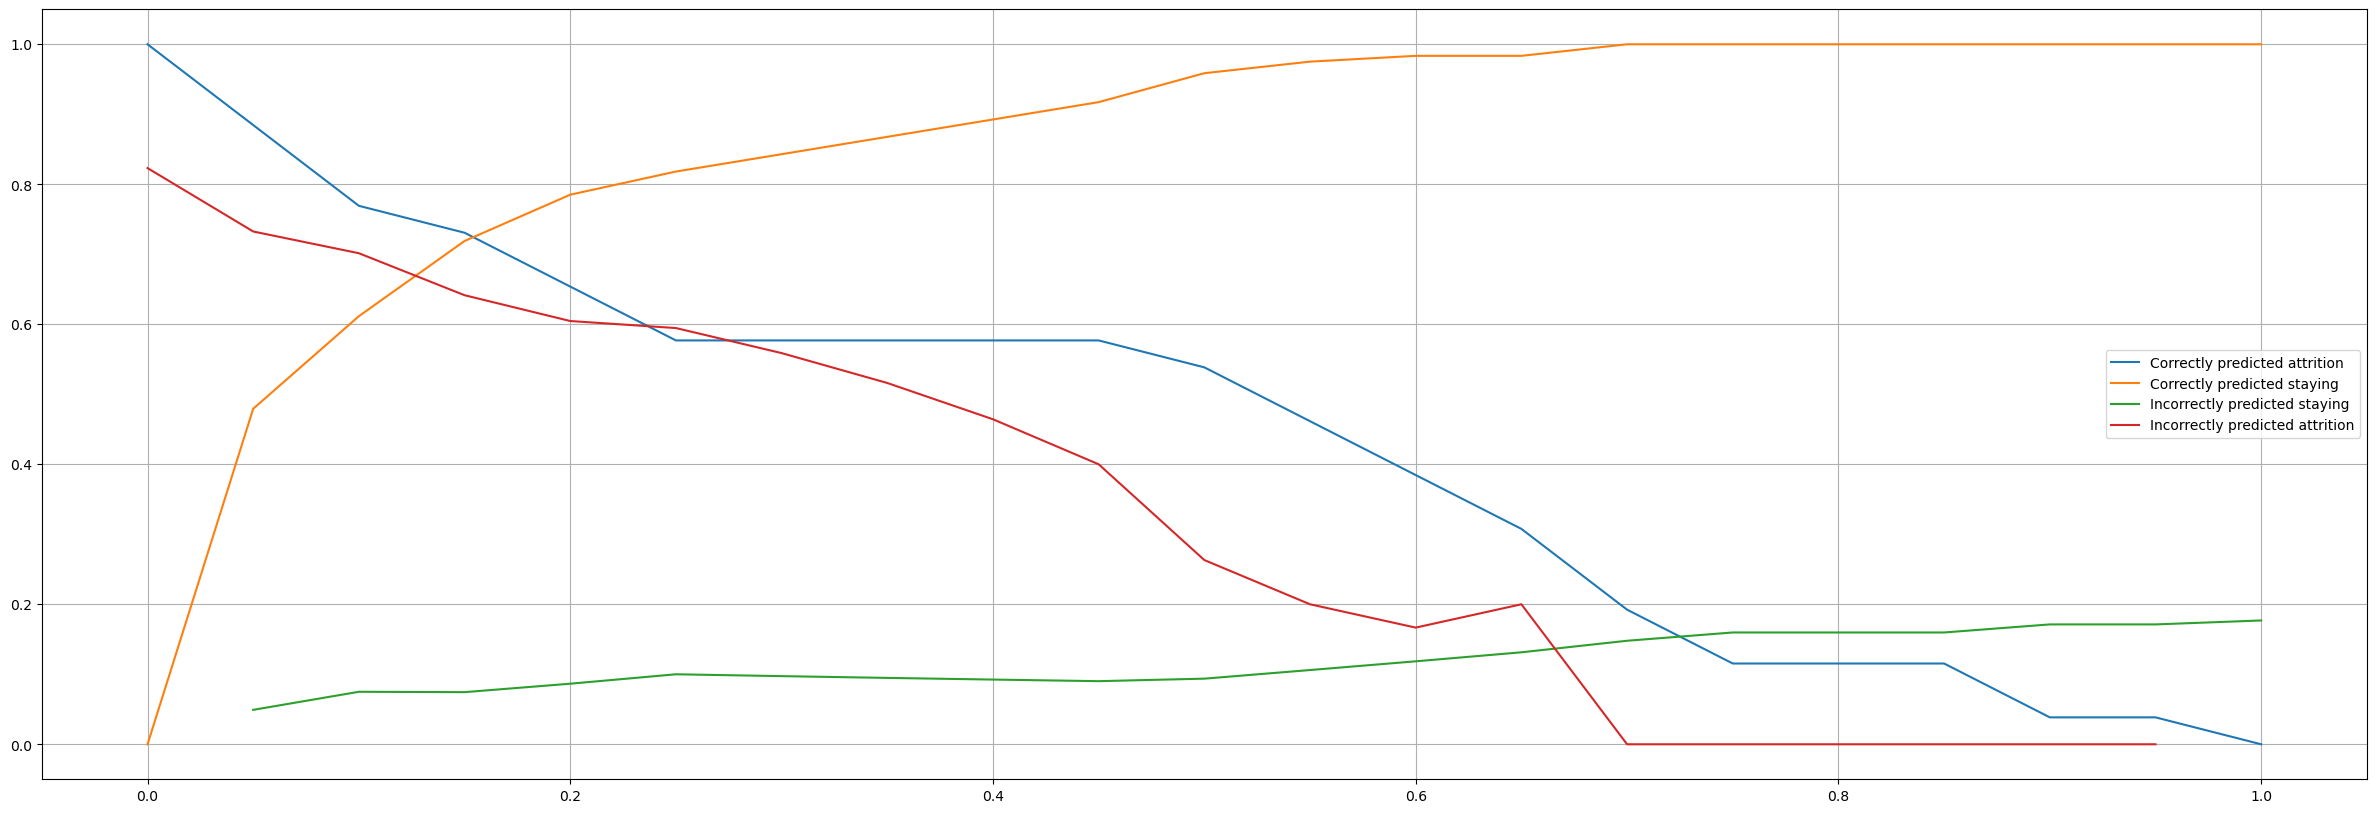

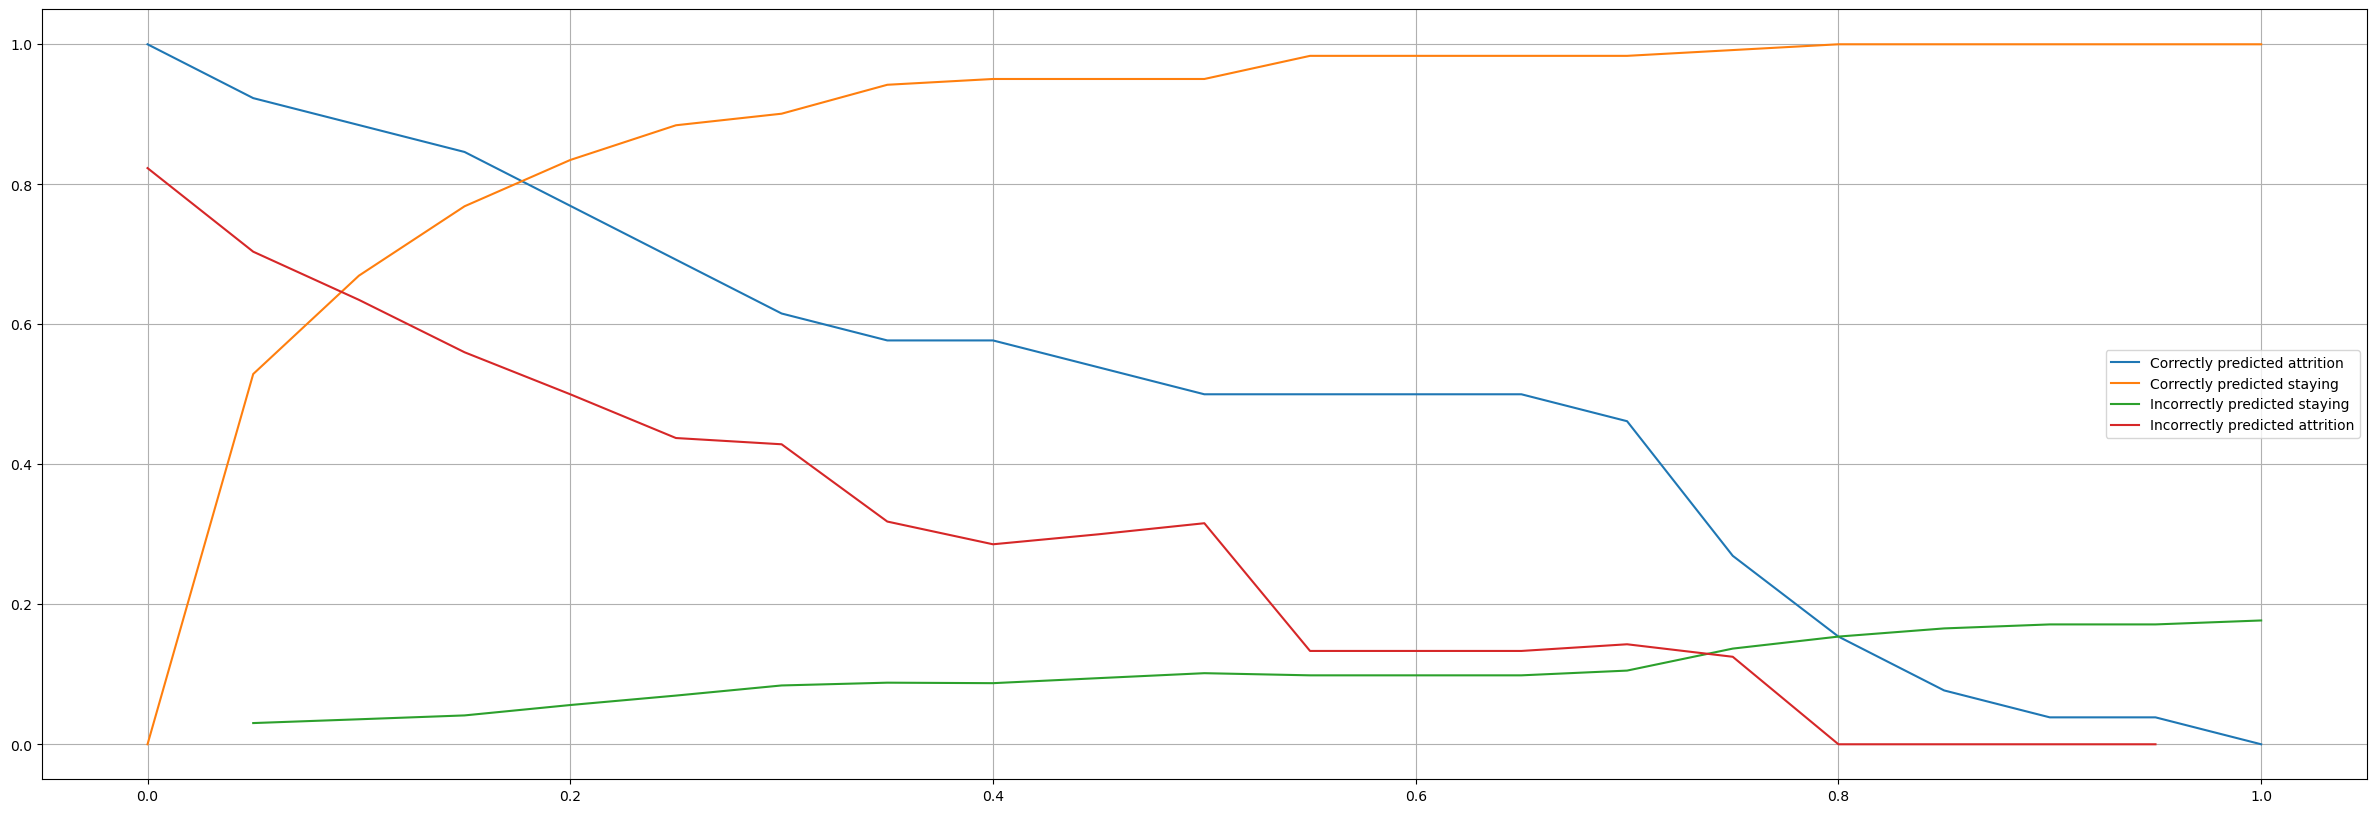

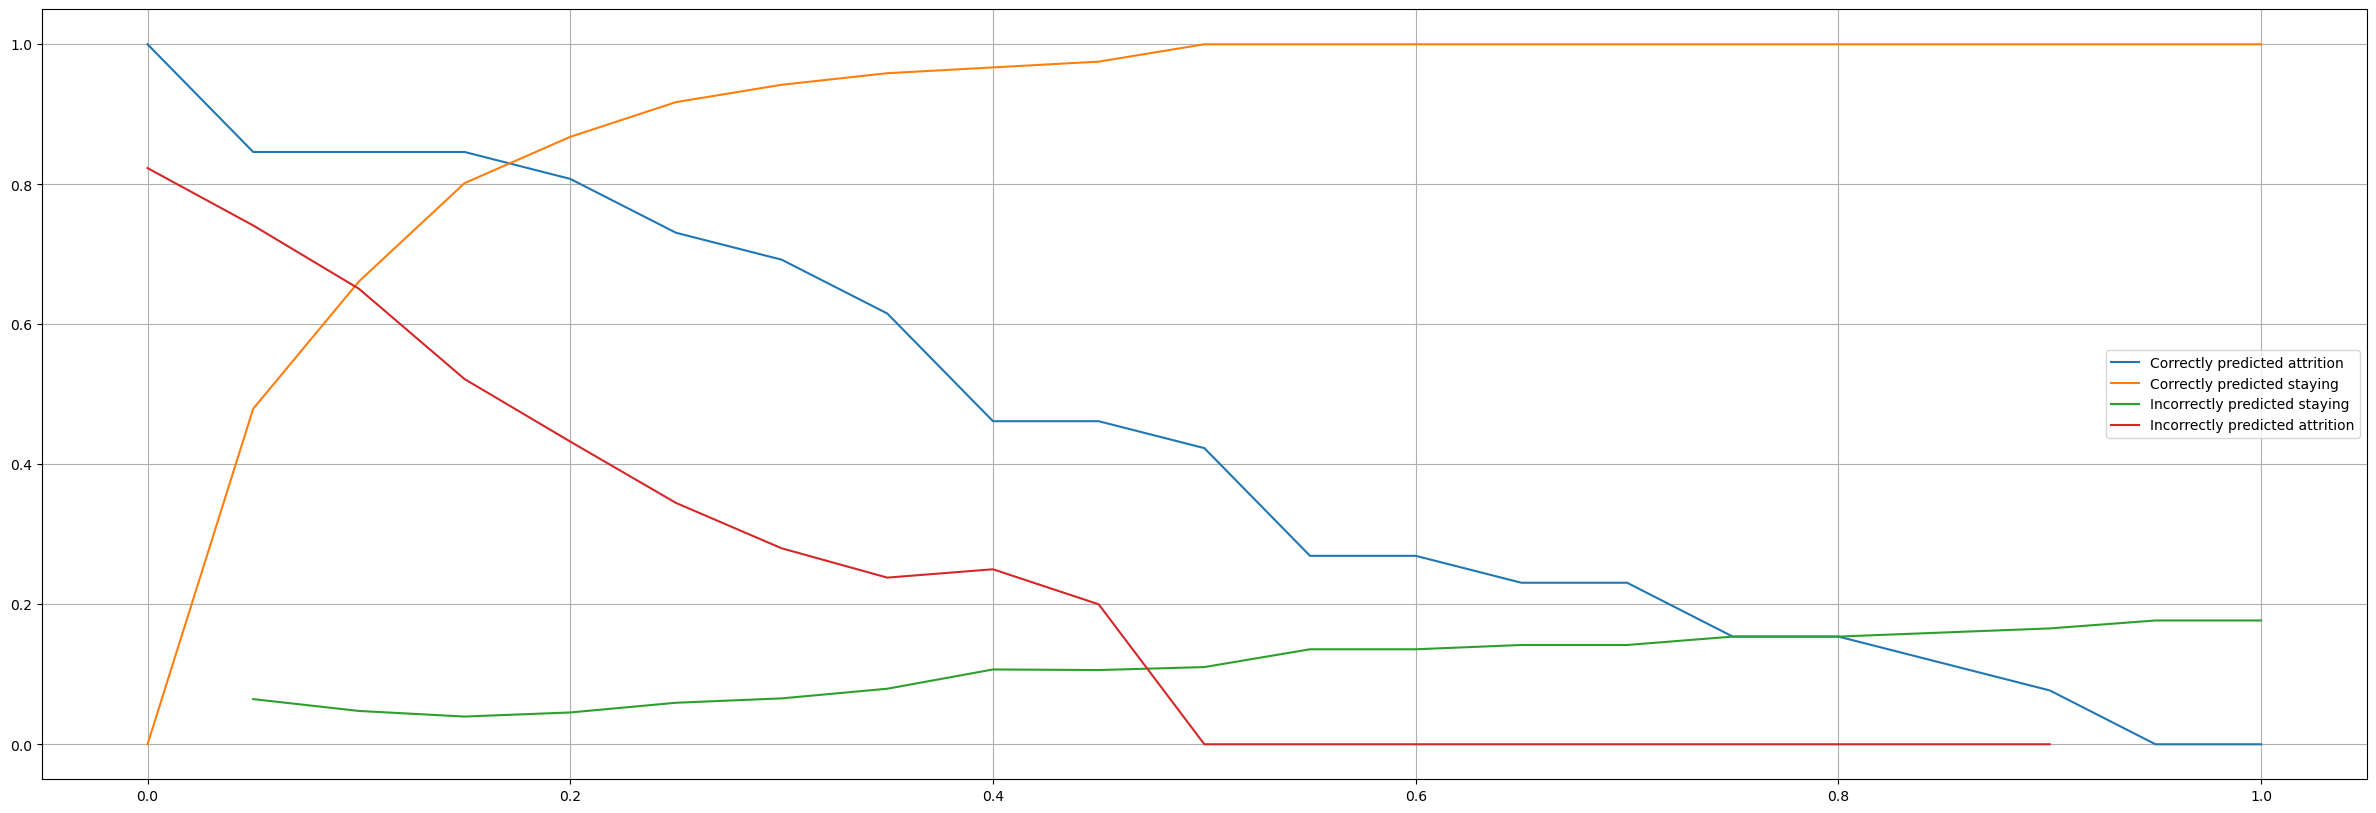

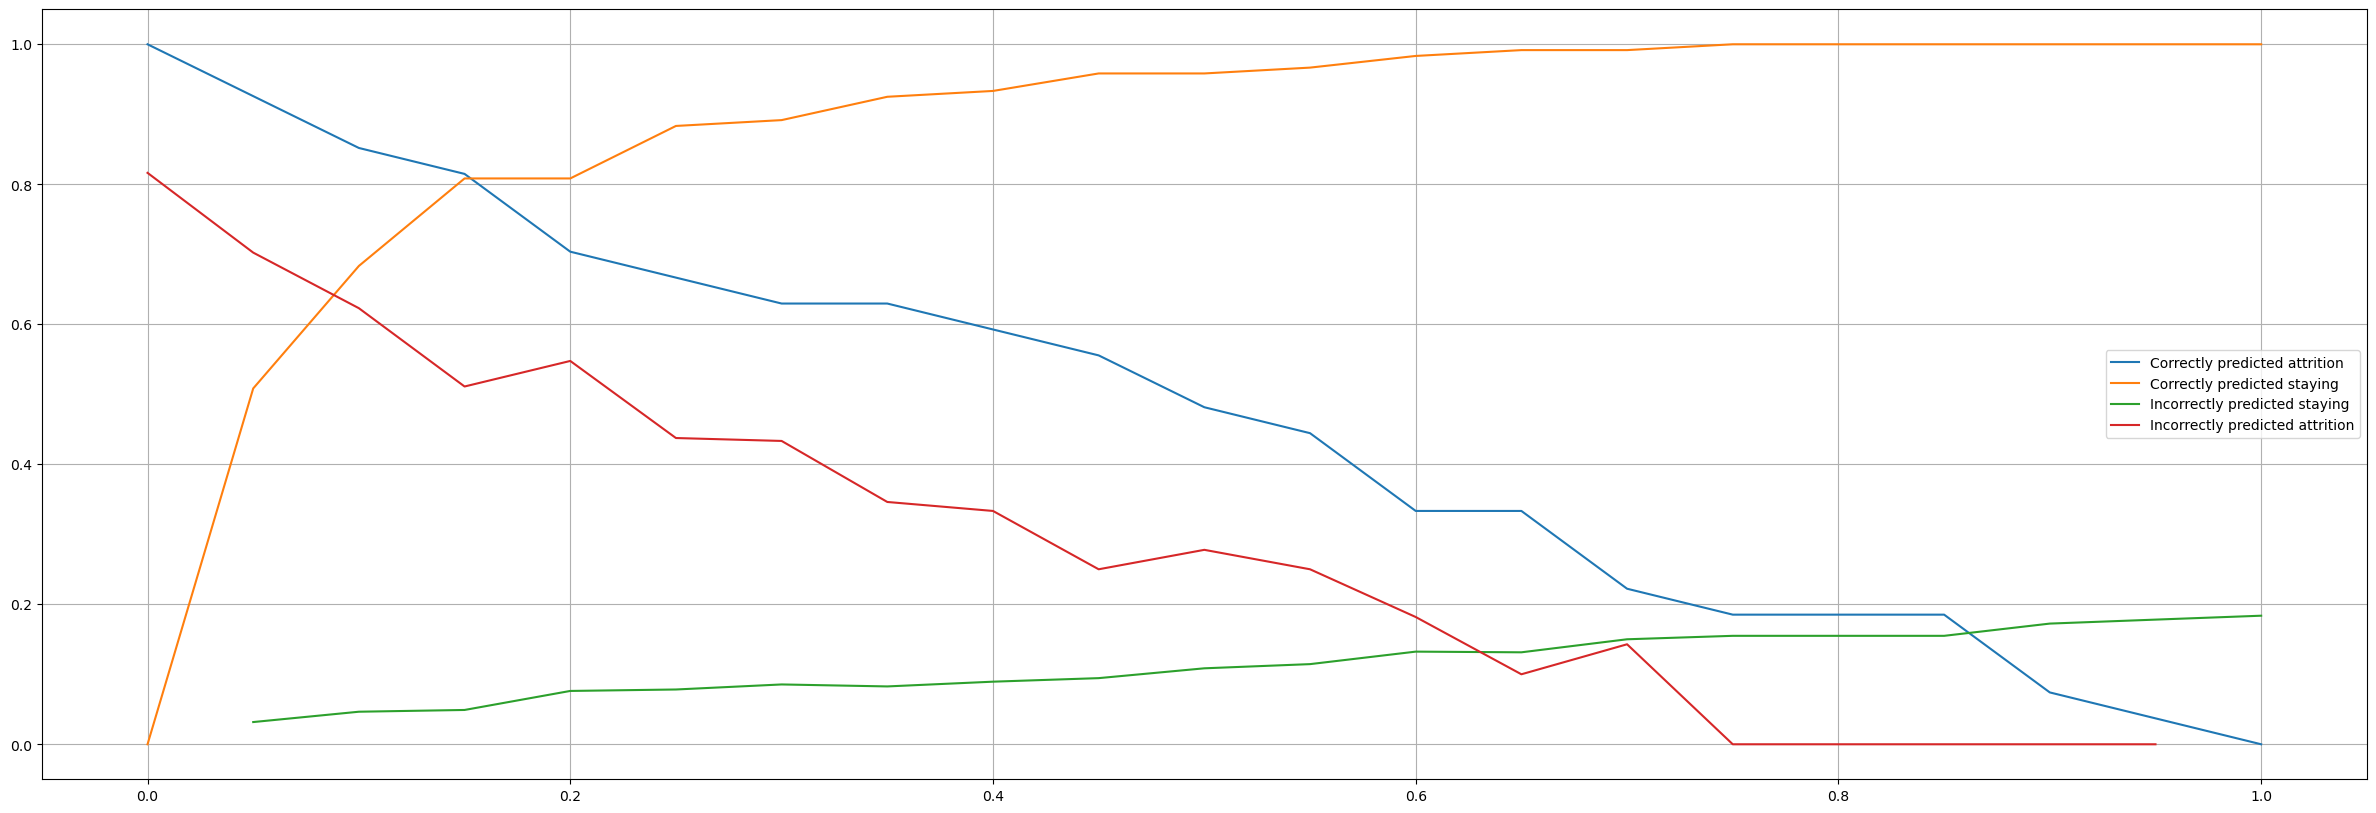

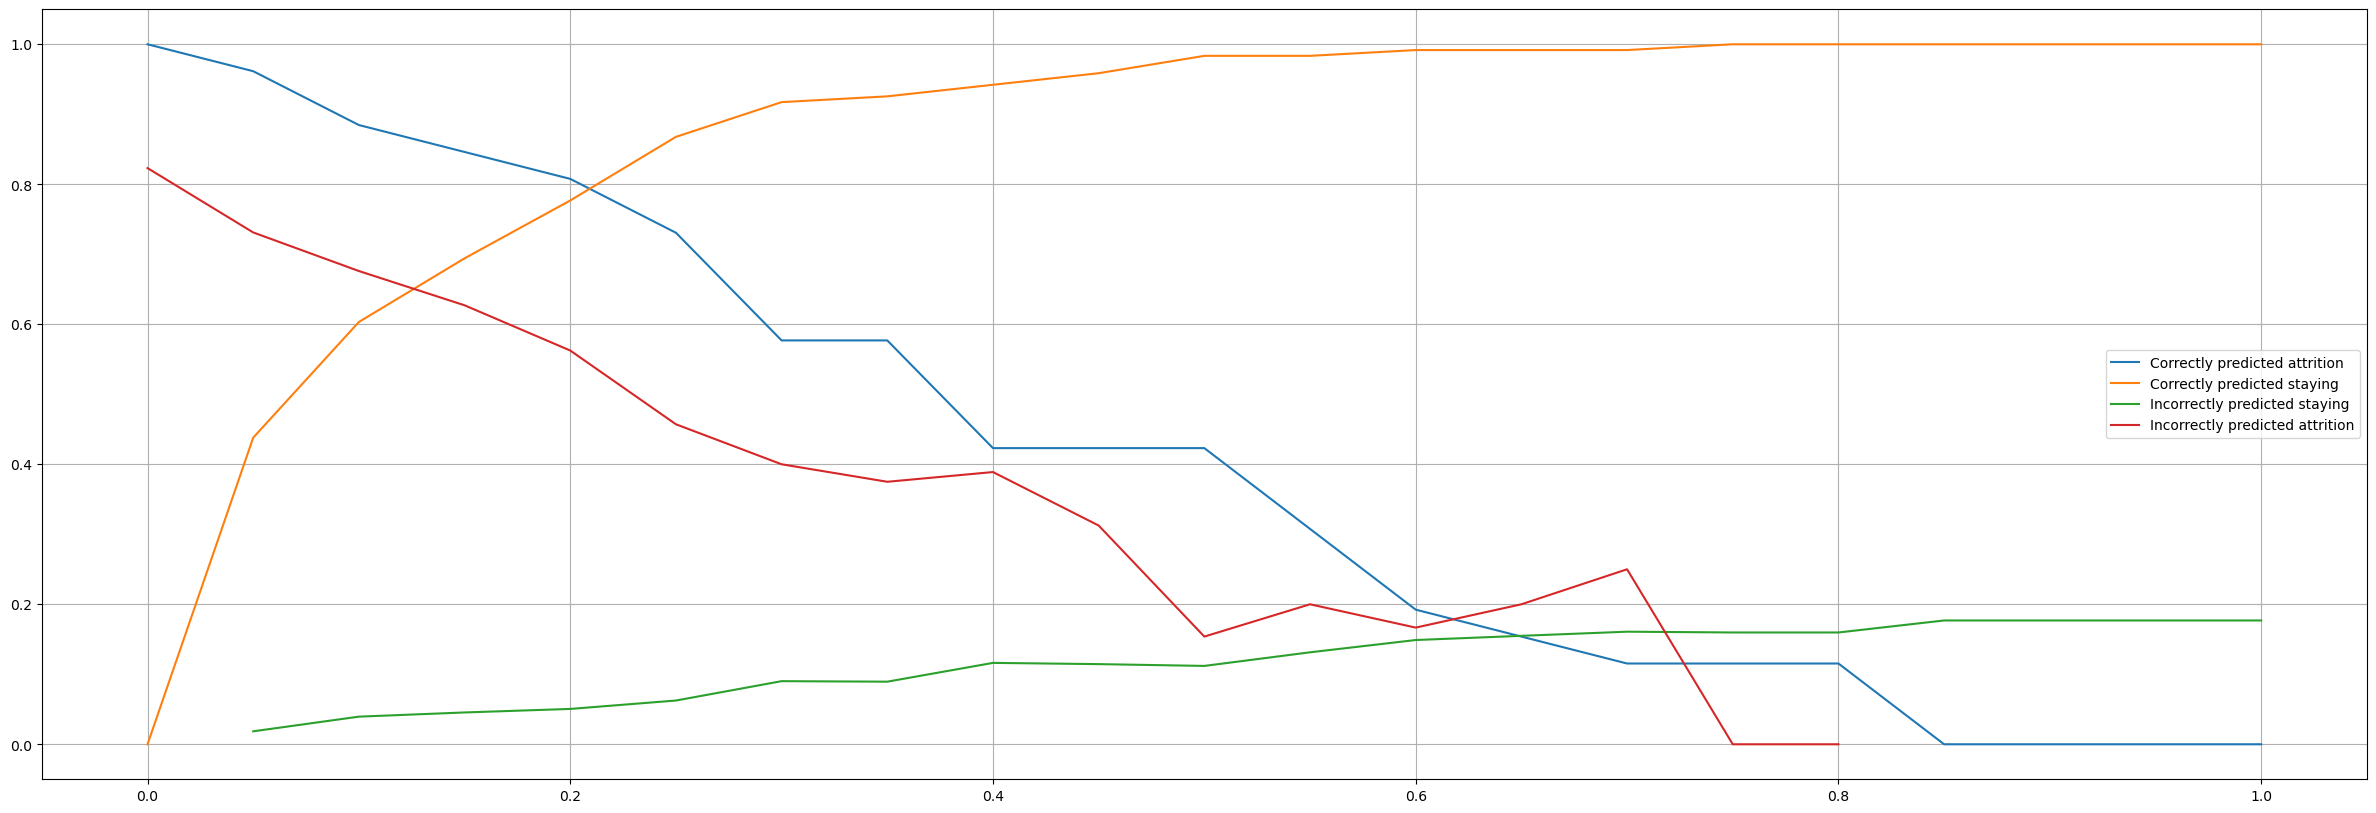

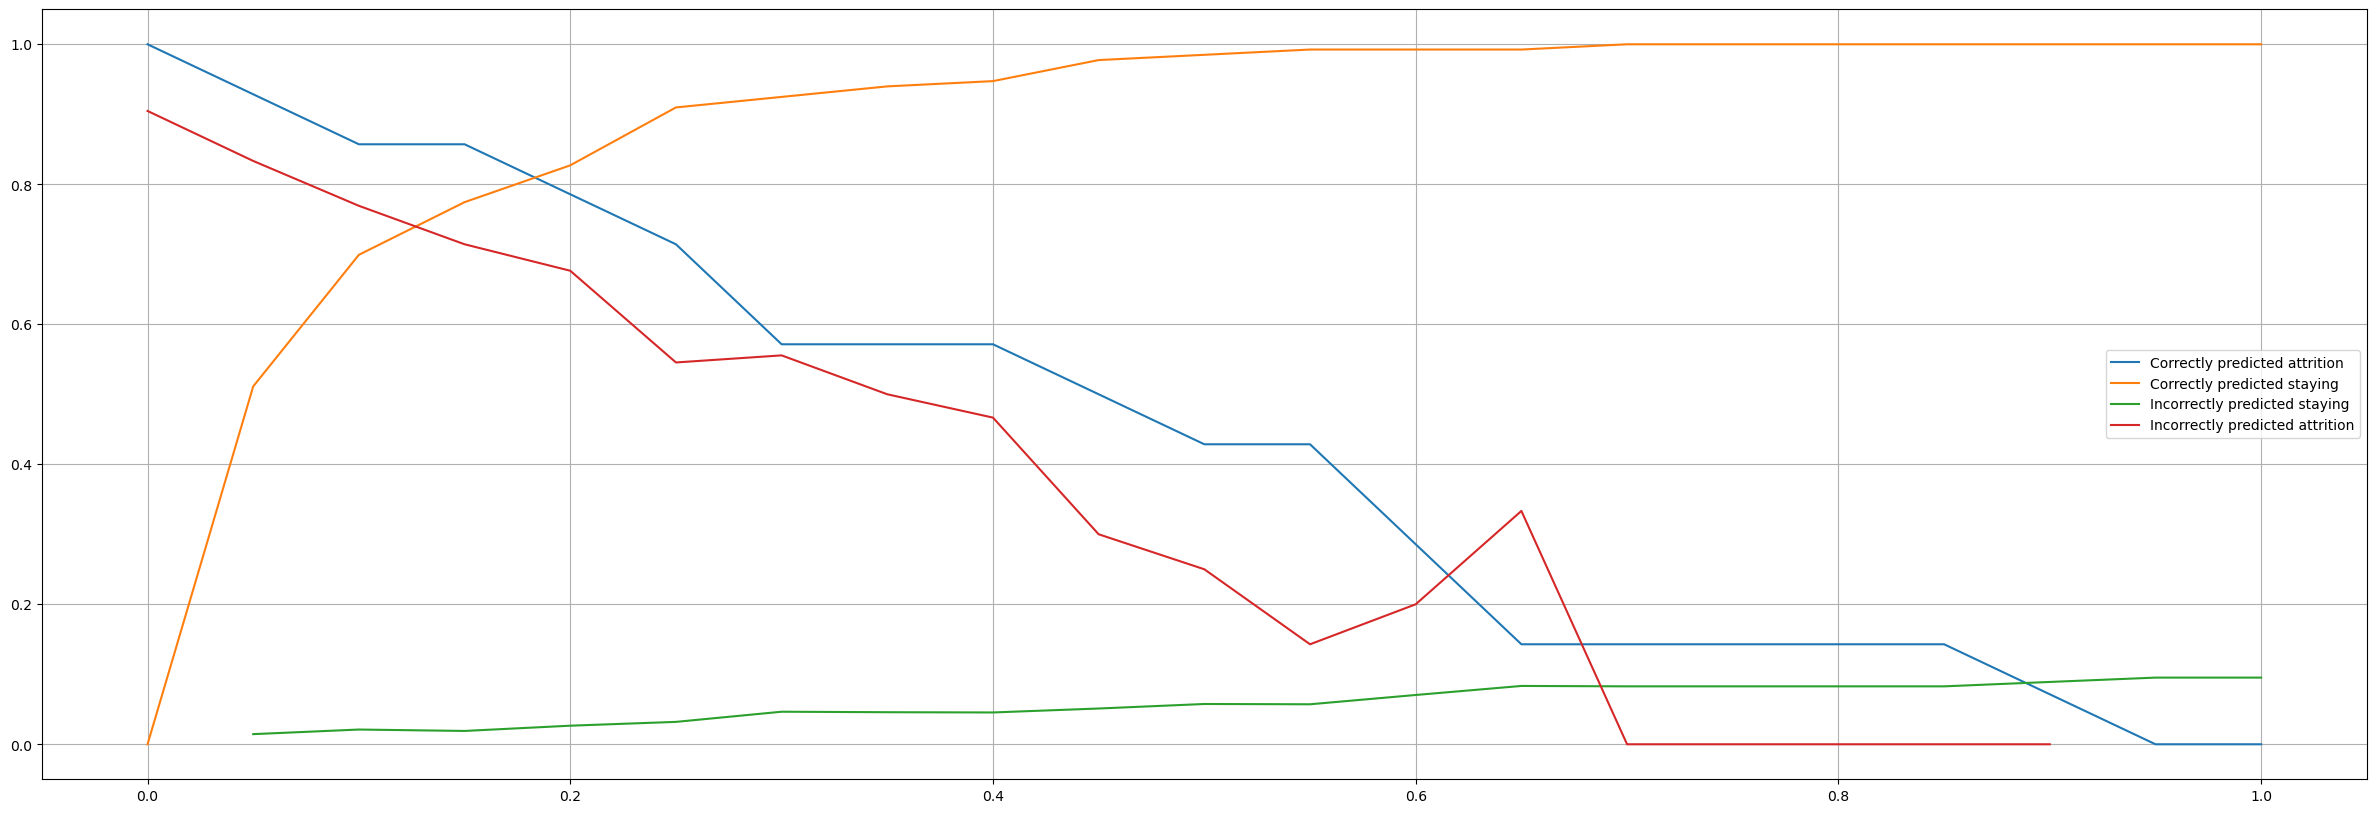

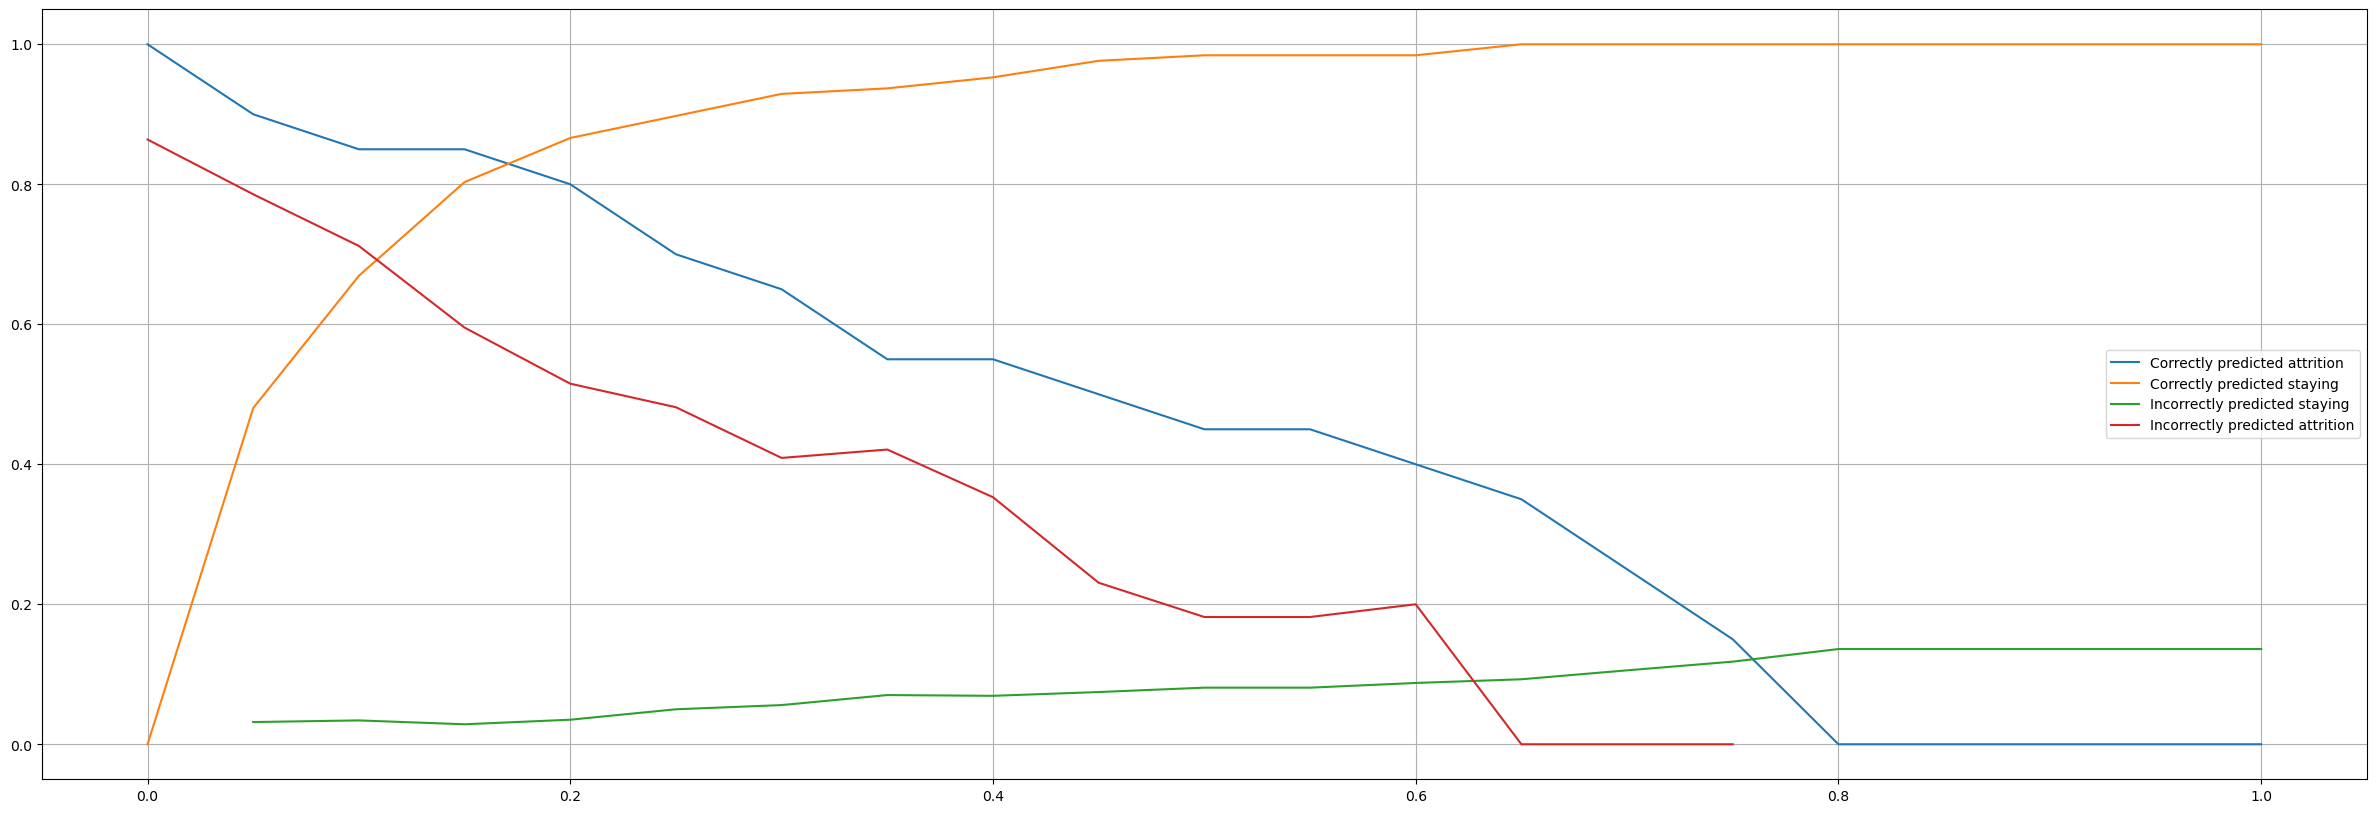

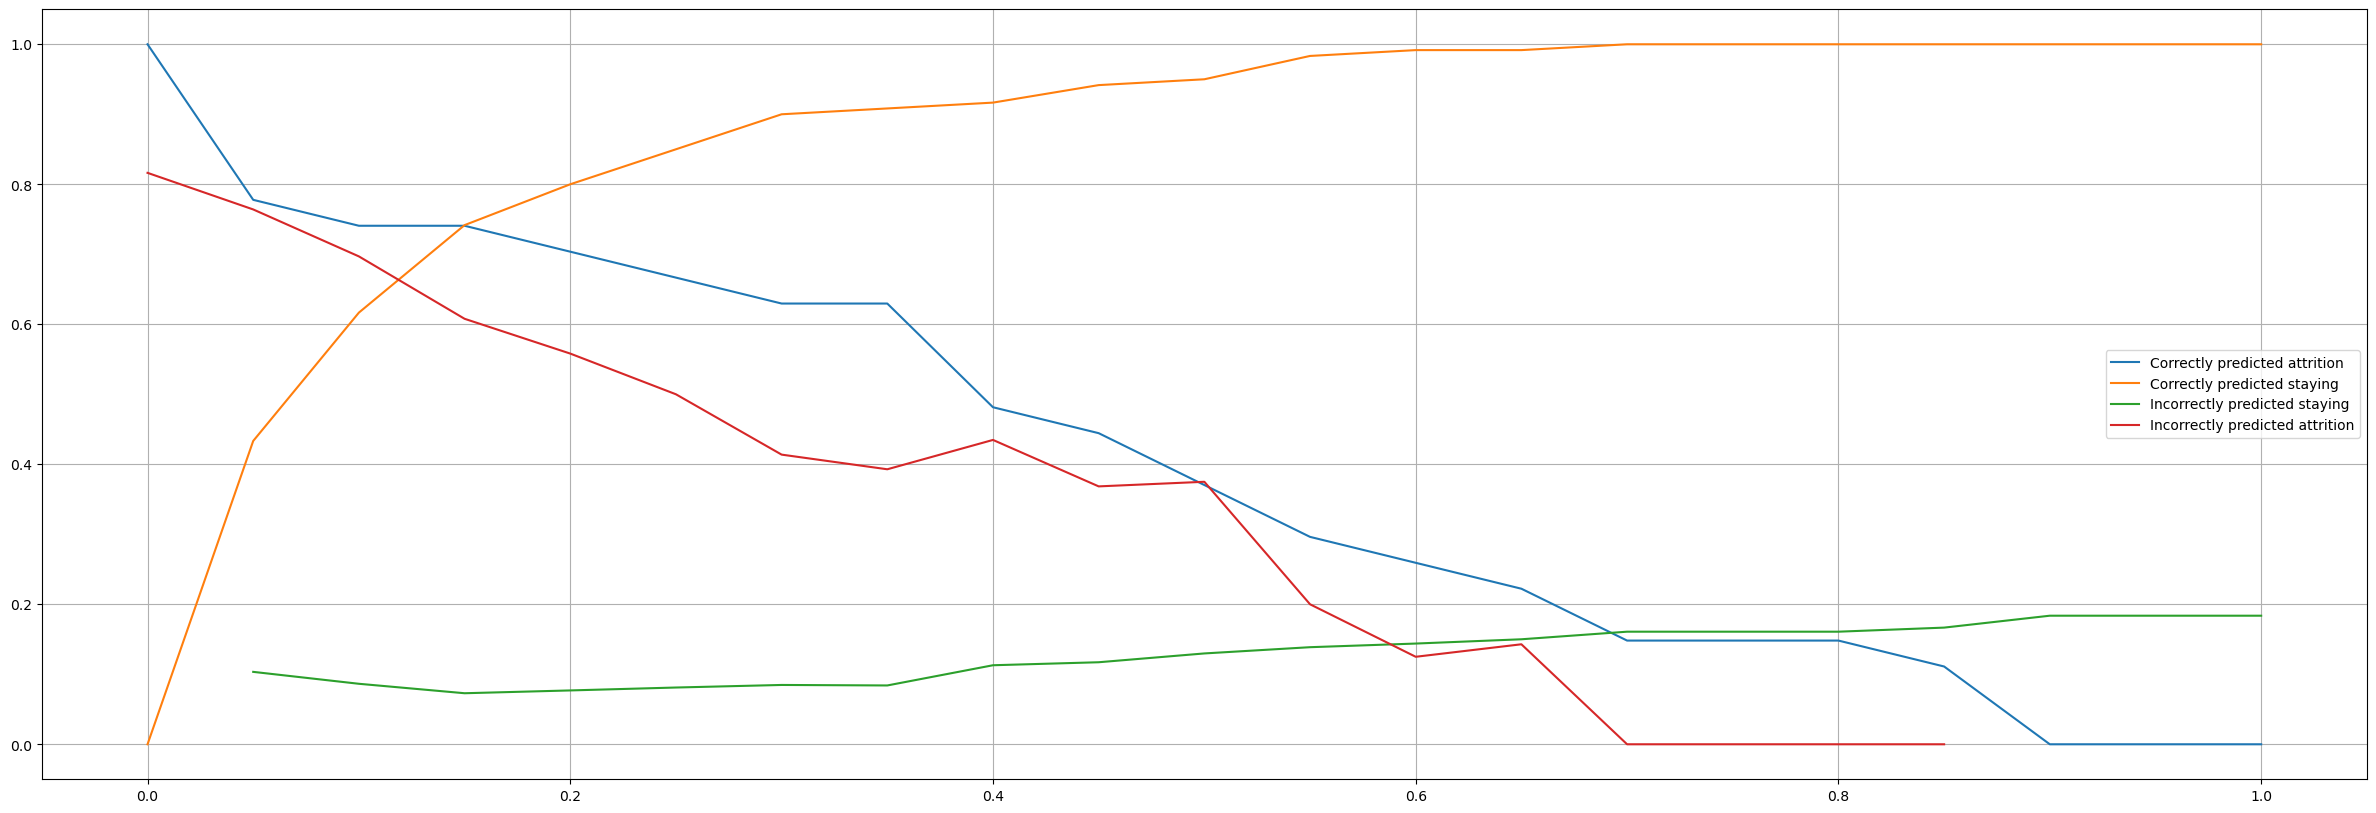

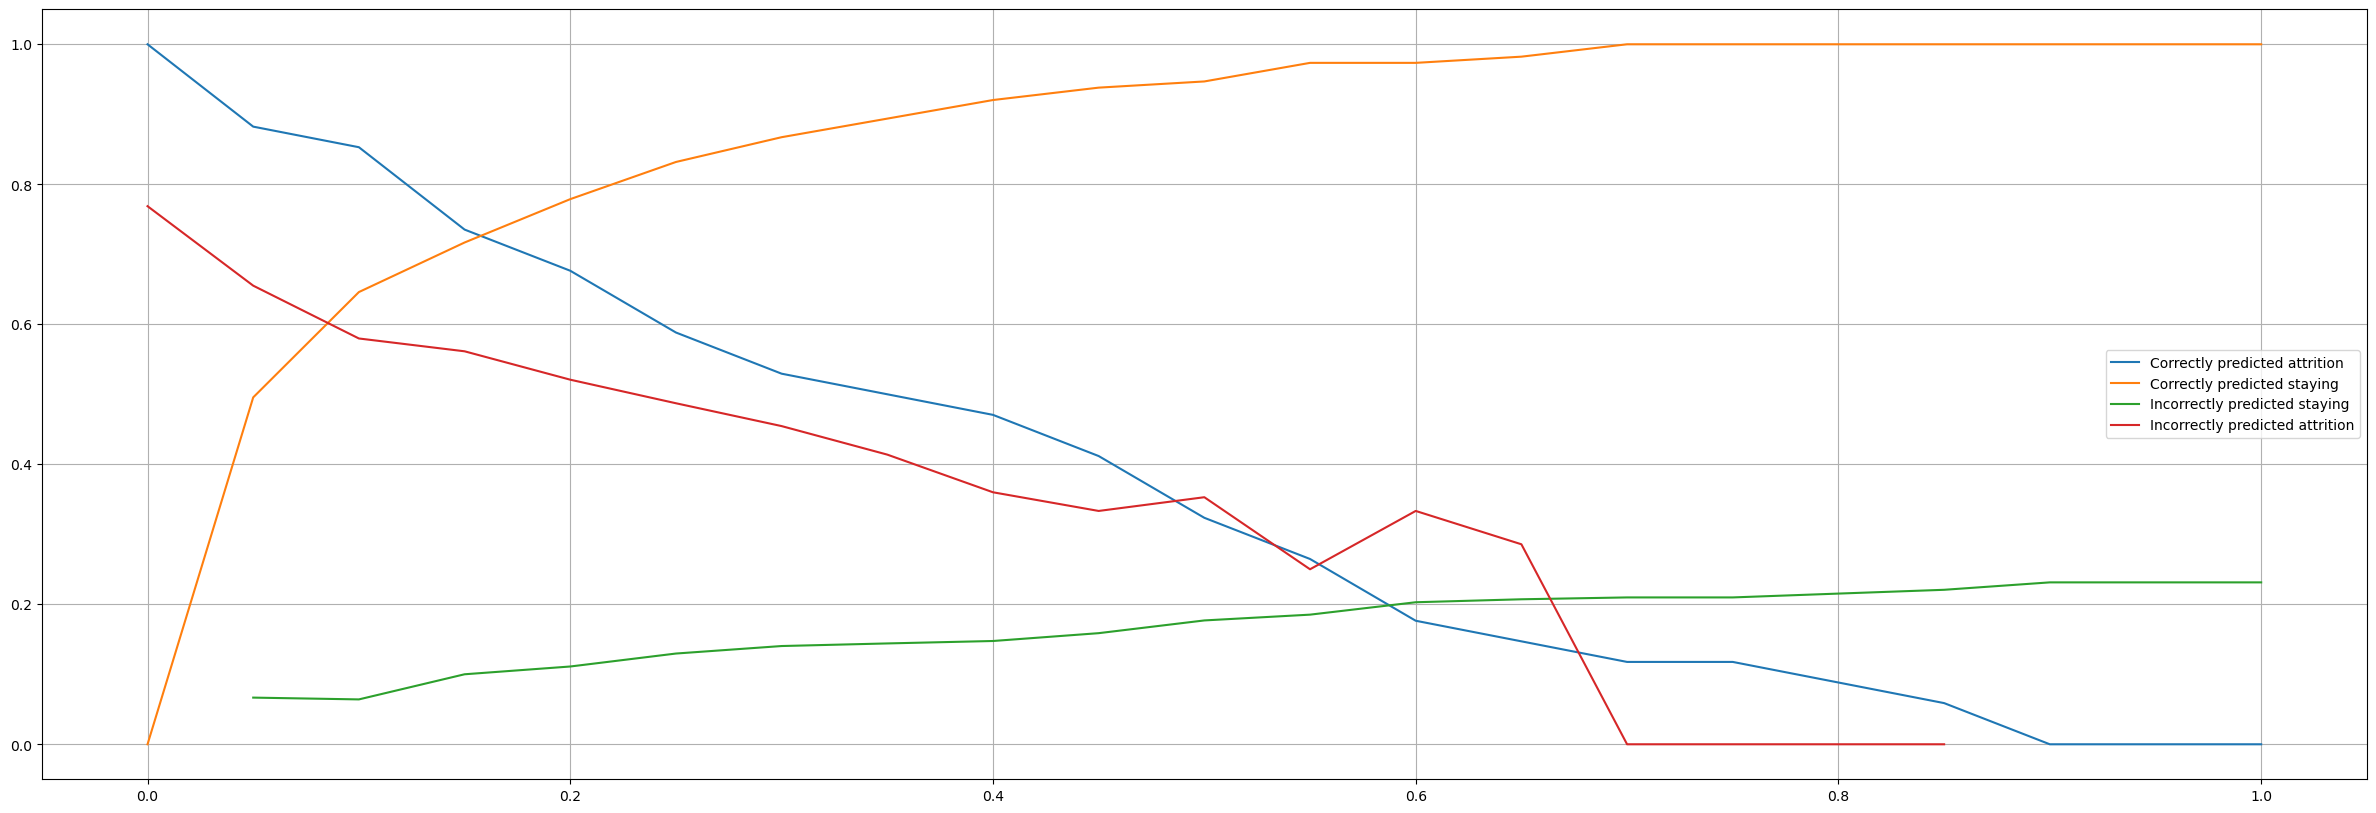

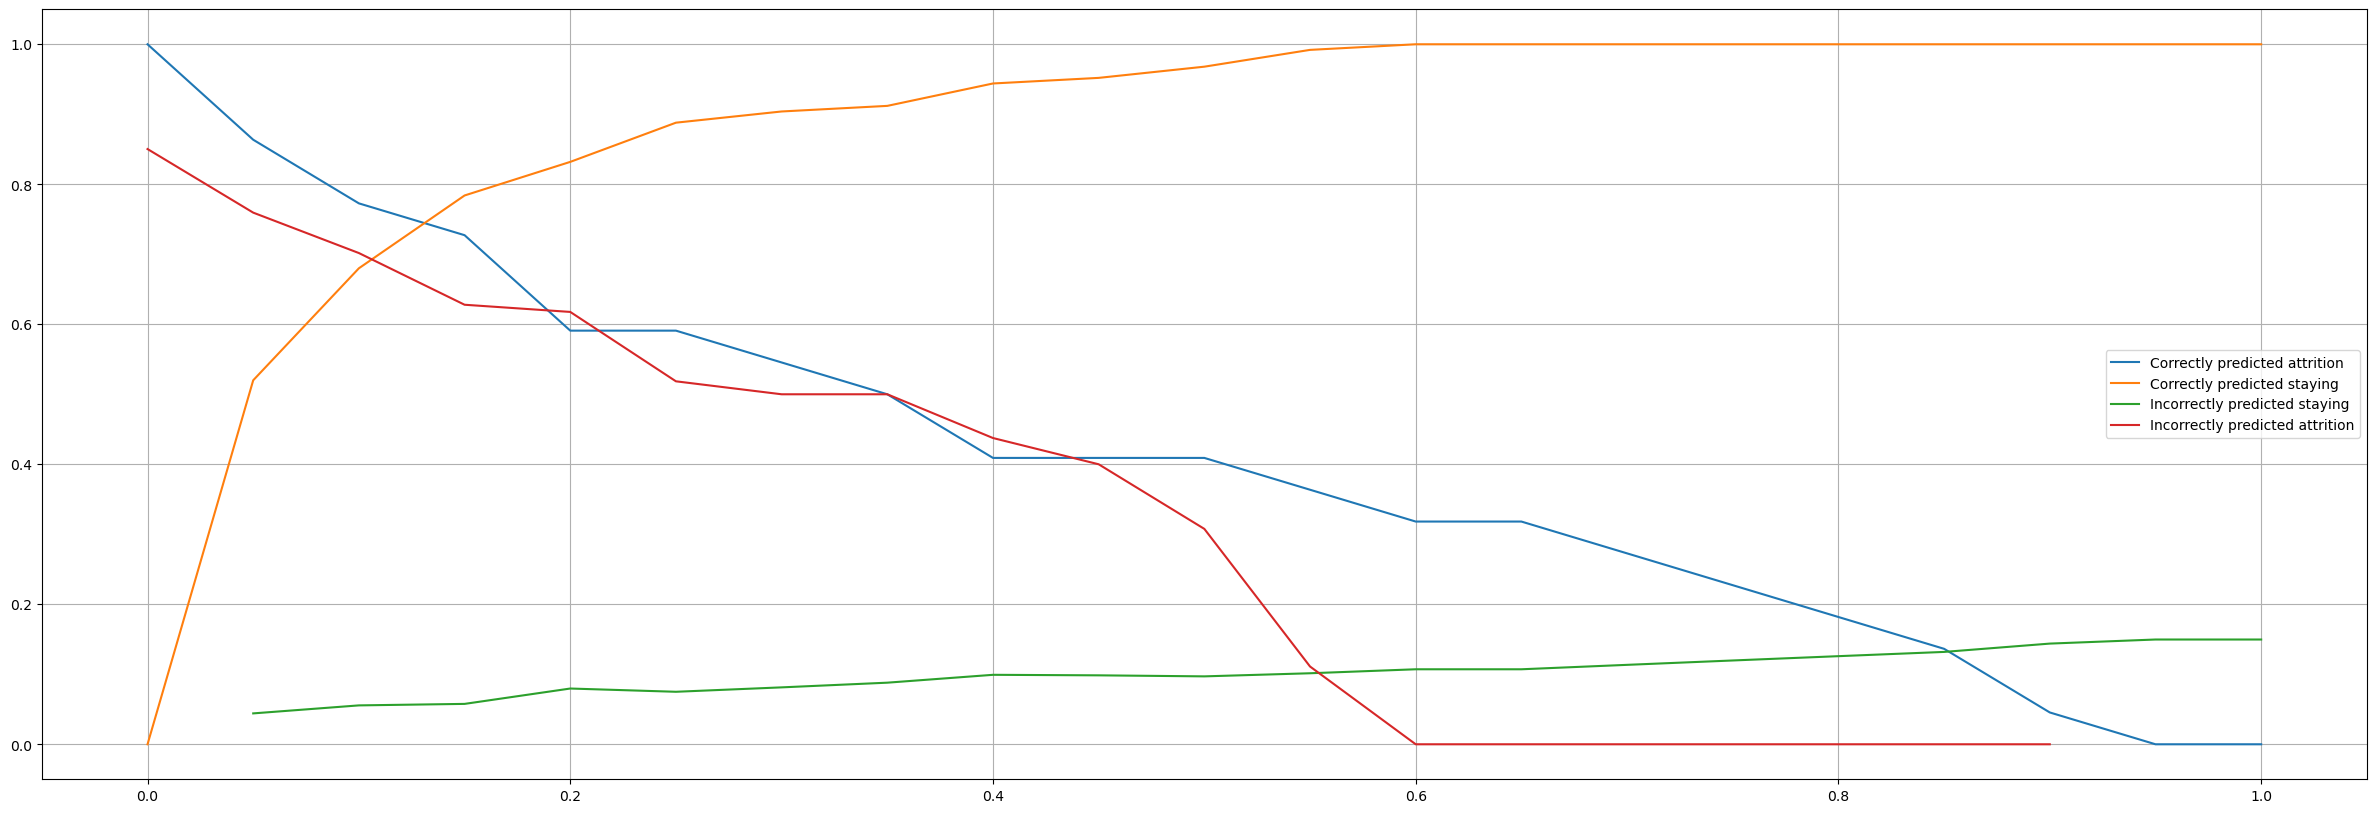

In [18]:
fractions = [0.7, 0.8, 0.9]
seeds = []
trainig_frac = []
testing_frac = []
for f in fractions:
    for j in range(20):
        tra, tes = get_confused(f, rnd.randint(0, 100000))
        seeds.append(j)
        trainig_frac.append(tra)
        testing_frac.append(tes)

In [20]:
testing_frac

[0.1746031746031746,
 0.1564625850340136,
 0.15873015873015872,
 0.16099773242630386,
 0.1473922902494331,
 0.16099773242630386,
 0.15419501133786848,
 0.16780045351473924,
 0.16326530612244897,
 0.1746031746031746,
 0.16099773242630386,
 0.1655328798185941,
 0.1564625850340136,
 0.1655328798185941,
 0.1564625850340136,
 0.17006802721088435,
 0.14512471655328799,
 0.16326530612244897,
 0.16099773242630386,
 0.12471655328798185,
 0.1870748299319728,
 0.16666666666666666,
 0.1598639455782313,
 0.16666666666666666,
 0.15306122448979592,
 0.19727891156462585,
 0.14625850340136054,
 0.1598639455782313,
 0.19727891156462585,
 0.20408163265306123,
 0.1598639455782313,
 0.1598639455782313,
 0.17006802721088435,
 0.13945578231292516,
 0.11564625850340136,
 0.16326530612244897,
 0.17687074829931973,
 0.11564625850340136,
 0.14625850340136054,
 0.17006802721088435,
 0.17006802721088435,
 0.17006802721088435,
 0.09523809523809523,
 0.10884353741496598,
 0.17687074829931973,
 0.14965986394557823,
 